# Data Cleaning

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version
import warnings;   warnings.filterwarnings("ignore")

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.
[ OK ] xgboost version 1.5.1 is installed.
[ OK ] shap version 0.40.0 is installed.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from itertools import accumulate
import six
nan = np.nan

fantasy_21_raw = pd.read_csv('../data/fantasy_21.csv')
fantasy_22_raw = pd.read_csv('../data/fantasy_22.csv')
teams_fifa_21_raw = pd.read_csv('../data/teams_fifa22.csv')
teams_fifa_22_raw = pd.read_csv('../data/teams_fifa23.csv')
matches_21_raw = pd.read_csv('../data/matches_21.csv')
matches_22_raw = pd.read_csv('../data/matches_22.csv')

In [3]:
#creates matches_21 dataset (contains all matches from 2021 season)
matches_21 = matches_21_raw[["Date", "Time","HomeTeam", "AwayTeam", "FTR", "Referee", "B365H", "B365D", "B365A"]]
matches_21 = matches_21.assign(HICT="")
matches_21 = matches_21.assign(AICT="")
matches_21.sort_index(inplace=True)
matches_21 = matches_21.reset_index(drop=True)

In [4]:
#creates fifa 21 dataset
fifa_21 = teams_fifa_21_raw[['Name','Overall']]
fifa_21 = fifa_21.head(20)
fifa_21 = fifa_21.sort_values(['Name'])
fifa_21['Overall'] = fifa_21['Overall'].apply(lambda x: x*100)

#creates list of overall team scores 
overall_21_away = fifa_21.Overall.to_list()
overall_21_home = fifa_21.Overall.to_list()

In [5]:
#creates fifa 22 dataset
fifa_22 = teams_fifa_22_raw[['Name','Overall']]
fifa_22 = fifa_22.head(21)
fifa_22 = fifa_22[fifa_22.Name != 'AFC Richmond'].reset_index(drop = True)
fifa_22 = fifa_22.replace('AFC Bournemouth', 'Bournemouth')
fifa_22 = fifa_22.sort_values(['Name'])
fifa_22['Overall'] = fifa_22['Overall'].apply(lambda x: x*100)

#creates list of overall team scores 
overall_22_away = fifa_22.Overall.to_list()
overall_22_home = fifa_22.Overall.to_list()

In [6]:
#creates matches_22 dataset (contains all matches from 2022 season)
matches_22 = matches_22_raw[["Date", "GW","HomeTeam", "AwayTeam", "FTR", "Referee", "B365H", "B365D", "B365A"]]
matches_22 = matches_22.assign(HICT="")
matches_22 = matches_22.assign(AICT="")
matches_22.sort_index(inplace=True)
matches_22 = matches_22.reset_index(drop=True)

In [7]:
#creates ICT score dataset for 2021 season
fantasy_21_raw[['Date', 'Time']] = fantasy_21_raw['kickoff_time'].str.split('T', 1, expand=True)
fantasy_21 = fantasy_21_raw[["team", "ict_index", "Date", 'minutes']] 
fantasy_21 = fantasy_21.sort_values(by=['team', 'Date'])
fantasy_21 = fantasy_21.groupby(by=['team', 'Date'])['ict_index'].sum().to_frame()
ICT_2021 = fantasy_21.pivot_table(index=['team'], 
            columns=['Date'], values='ict_index').fillna(0)
ICT_2021.sort_index(inplace=True)
ICT_2021.reset_index(inplace=True)

In [8]:
#creates ICT score dataset for 2022 season
fantasy_22 = fantasy_22_raw[["team", "ict_index", "GW", 'minutes']]  
fantasy_22 = fantasy_22.sort_values(by=['team', 'GW'])
fantasy_22 = fantasy_22.groupby(by=['team', 'GW'])['ict_index'].sum().to_frame()
ICT_2022 = fantasy_22.pivot_table(index=['team'], 
            columns=['GW'], values='ict_index').fillna(0)
ICT_2022.sort_index(inplace=True)
ICT_2022.reset_index(inplace=True)

In [9]:
#creates boolean dataset showing when each team was home for 2021 season
fantasy_21 = fantasy_21_raw[["team", "was_home", "Date"]]
fantasy_21 = fantasy_21.sort_values(by=['team', 'Date'])
WH_2021 = fantasy_21.pivot_table(index=['team'], 
            columns=['Date'], values='was_home').fillna(0)
WH_2021.sort_index(inplace=True)
WH_2021.reset_index(inplace=True)

In [10]:
#creates boolean dataset showing when each team was home for 2022 season
fantasy_22 = fantasy_22_raw[["team", "was_home", "GW"]]
fantasy_22 = fantasy_22.sort_values(by=['team', 'GW'])
WH_2022 = fantasy_22.pivot_table(index=['team'], 
            columns=['GW'], values='was_home').fillna(0)
WH_2022.sort_index(inplace=True)
WH_2022.reset_index(inplace=True)

In [11]:
#helper funtions

#returns average of list
def Average(lst):
    return sum(lst) / len(lst)

#returns scores of each team
def get_score_21_away():
    empty_list_21 = []
    for score in overall_21_away:
        if score not in empty_list_21:
            empty_list_21.append(score)
            overall_21_away.remove(score)
            return score

def get_score_22_away():
    empty_list_22 = []
    for score in overall_22_away:
        if score not in empty_list_22:
            empty_list_22.append(score)
            overall_22_away.remove(score)
            return score
        
def get_score_21_home():
    empty_list_21 = []
    for score in overall_21_home:
        if score not in empty_list_21:
            empty_list_21.append(score)
            overall_21_home.remove(score)
            return score

def get_score_22_home():
    empty_list_22 = []
    for score in overall_22_home:
        if score not in empty_list_22:
            empty_list_22.append(score)
            overall_22_home.remove(score)
            return score

In [12]:
#sorts matches 21 dataset by date and awayteam and converts to datetime object
matches_21['Date'] = pd.to_datetime(matches_21['Date'], format='%m/%d/%y')
matches_21 = matches_21.sort_values(['AwayTeam','Date']).reset_index(drop=True)

#combines matches 21 with a mask of boolean was home dataset (away)
away_team_ict_21 = ICT_2021.mask(WH_2021 == 1.0)

#populates AICT column for Matches 21 dataframe
away_team_rows_21 =[]
if 'Away Team' in away_team_ict_21.columns:
    away_team_ict_21 = away_team_ict_21.drop('Away Team', axis=1)  
for index, rows in away_team_ict_21.iterrows():
    my_list = [rows["2021-08-13"],rows["2021-08-14"],rows["2021-08-15"],rows["2021-08-21"],
               rows["2021-08-22"],rows["2021-08-23"],rows["2021-08-28"],rows["2021-08-29"],rows["2021-09-11"],
               rows["2021-09-12"],rows["2021-09-13"],rows["2021-09-17"],rows["2021-09-18"],rows["2021-09-19"],
               rows["2021-09-25"],rows["2021-09-26"],rows["2021-09-27"],rows["2021-10-02"],rows["2021-10-03"],
               rows["2021-10-16"],rows["2021-10-17"],rows["2021-10-18"],rows["2021-10-22"],rows["2021-10-23"],
               rows["2021-10-24"],rows["2021-10-30"],rows["2021-10-31"],rows["2021-11-01"],rows["2021-11-05"],
               rows["2021-11-06"],rows["2021-11-07"],rows["2021-11-20"],rows["2021-11-21"],rows["2021-11-27"],
               rows["2021-11-28"],rows["2021-11-30"],rows["2021-12-01"],rows["2021-12-02"],rows["2021-12-04"],
               rows["2021-12-05"],rows["2021-12-06"],rows["2021-12-10"],rows["2021-12-11"],rows["2021-12-12"],
               rows["2021-12-14"],rows["2021-12-15"],rows["2021-12-16"],rows["2021-12-18"],rows["2021-12-19"],
               rows["2021-12-26"],rows["2021-12-27"],rows["2021-12-28"],rows["2021-12-29"],rows["2021-12-30"],
               rows["2022-01-01"],rows["2022-01-02"],rows["2022-01-03"],rows["2022-01-11"],rows["2022-01-12"],
               rows["2022-01-14"],rows["2022-01-15"],rows["2022-01-16"],rows["2022-01-18"],rows["2022-01-19"],
               rows["2022-01-21"],rows["2022-01-22"],rows["2022-01-23"],rows["2022-02-05"],rows["2022-02-08"],
               rows["2022-02-09"],rows["2022-02-10"],rows["2022-02-12"],rows["2022-02-13"],rows["2022-02-15"],
               rows["2022-02-19"],rows["2022-02-20"],rows["2022-02-23"],rows["2022-02-24"],rows["2022-02-25"],
               rows["2022-02-26"],rows["2022-02-27"],rows["2022-03-01"],rows["2022-03-05"],rows["2022-03-06"],
               rows["2022-03-07"],rows["2022-03-10"],rows["2022-03-12"],rows["2022-03-13"],rows["2022-03-14"],
               rows["2022-03-16"],rows["2022-03-17"],rows["2022-03-18"],rows["2022-03-19"],rows["2022-03-20"],
               rows["2022-04-02"],rows["2022-04-03"],rows["2022-04-04"],rows["2022-04-06"],rows["2022-04-08"],
               rows["2022-04-09"],rows["2022-04-10"],rows["2022-04-16"],rows["2022-04-17"],rows["2022-04-19"],
               rows["2022-04-20"],rows["2022-04-21"],rows["2022-04-23"],rows["2022-04-24"],rows["2022-04-25"],
               rows["2022-04-28"],rows["2022-04-30"],rows["2022-05-01"],rows["2022-05-02"],rows["2022-05-07"],
               rows["2022-05-08"],rows["2022-05-10"],rows["2022-05-11"],rows["2022-05-12"],rows["2022-05-15"],
               rows["2022-05-16"],rows["2022-05-17"],rows["2022-05-19"], rows["2022-05-22"]]
    away_team_rows_21.append(my_list)
away_team_rows_21 = [[x for x in y if str(x) != 'nan'] for y in away_team_rows_21]
away_team_rows_21 = [[x for x in y if str(x) != '0.0'] for y in away_team_rows_21]

team_list_sum = []
for team in away_team_rows_21:
    team.insert(0, get_score_21_away())
    team.pop()
    team_list_sum.append(list(accumulate(team)))
flat_list_a21 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_a21.append(item)
matches_21 = matches_21.assign(AICT=flat_list_a21)

#combines matches 21 with a mask of boolean was home dataset (home)
home_team_ict_21 = ICT_2021.mask(WH_2021 == 0.0)

#populates HICT column for Matches 21 dataframe
matches_21 = matches_21.sort_values(['HomeTeam','Date']).reset_index(drop=True)
home_team_rows_21 = []
if 'Home Team' in home_team_ict_21.columns:
    home_team_ict_21 = home_team_ict_21.drop('Home Team', axis=1)  
for index, rows in home_team_ict_21.iterrows():
    my_list = [rows["2021-08-13"],rows["2021-08-14"],rows["2021-08-15"],rows["2021-08-21"],
               rows["2021-08-22"],rows["2021-08-23"],rows["2021-08-28"],rows["2021-08-29"],rows["2021-09-11"],
               rows["2021-09-12"],rows["2021-09-13"],rows["2021-09-17"],rows["2021-09-18"],rows["2021-09-19"],
               rows["2021-09-25"],rows["2021-09-26"],rows["2021-09-27"],rows["2021-10-02"],rows["2021-10-03"],
               rows["2021-10-16"],rows["2021-10-17"],rows["2021-10-18"],rows["2021-10-22"],rows["2021-10-23"],
               rows["2021-10-24"],rows["2021-10-30"],rows["2021-10-31"],rows["2021-11-01"],rows["2021-11-05"],
               rows["2021-11-06"],rows["2021-11-07"],rows["2021-11-20"],rows["2021-11-21"],rows["2021-11-27"],
               rows["2021-11-28"],rows["2021-11-30"],rows["2021-12-01"],rows["2021-12-02"],rows["2021-12-04"],
               rows["2021-12-05"],rows["2021-12-06"],rows["2021-12-10"],rows["2021-12-11"],rows["2021-12-12"],
               rows["2021-12-14"],rows["2021-12-15"],rows["2021-12-16"],rows["2021-12-18"],rows["2021-12-19"],
               rows["2021-12-26"],rows["2021-12-27"],rows["2021-12-28"],rows["2021-12-29"],rows["2021-12-30"],
               rows["2022-01-01"],rows["2022-01-02"],rows["2022-01-03"],rows["2022-01-11"],rows["2022-01-12"],
               rows["2022-01-14"],rows["2022-01-15"],rows["2022-01-16"],rows["2022-01-18"],rows["2022-01-19"],
               rows["2022-01-21"],rows["2022-01-22"],rows["2022-01-23"],rows["2022-02-05"],rows["2022-02-08"],
               rows["2022-02-09"],rows["2022-02-10"],rows["2022-02-12"],rows["2022-02-13"],rows["2022-02-15"],
               rows["2022-02-19"],rows["2022-02-20"],rows["2022-02-23"],rows["2022-02-24"],rows["2022-02-25"],
               rows["2022-02-26"],rows["2022-02-27"],rows["2022-03-01"],rows["2022-03-05"],rows["2022-03-06"],
               rows["2022-03-07"],rows["2022-03-10"],rows["2022-03-12"],rows["2022-03-13"],rows["2022-03-14"],
               rows["2022-03-16"],rows["2022-03-17"],rows["2022-03-18"],rows["2022-03-19"],rows["2022-03-20"],
               rows["2022-04-02"],rows["2022-04-03"],rows["2022-04-04"],rows["2022-04-06"],rows["2022-04-08"],
               rows["2022-04-09"],rows["2022-04-10"],rows["2022-04-16"],rows["2022-04-17"],rows["2022-04-19"],
               rows["2022-04-20"],rows["2022-04-21"],rows["2022-04-23"],rows["2022-04-24"],rows["2022-04-25"],
               rows["2022-04-28"],rows["2022-04-30"],rows["2022-05-01"],rows["2022-05-02"],rows["2022-05-07"],
               rows["2022-05-08"],rows["2022-05-10"],rows["2022-05-11"],rows["2022-05-12"],rows["2022-05-15"],
               rows["2022-05-16"],rows["2022-05-17"],rows["2022-05-19"], rows["2022-05-22"]]
    home_team_rows_21.append(my_list)
home_team_rows_21 = [[x for x in y if str(x) != 'nan'] for y in home_team_rows_21]
home_team_rows_21 = [[x for x in y if str(x) != '0.0'] for y in home_team_rows_21]

team_list_sum = []
for team in home_team_rows_21:
    team.insert(0, get_score_21_home())
    team.pop()
    team_list_sum.append(list(accumulate(team)))

flat_list_h21 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_h21.append(item)
matches_21 = matches_21.assign(HICT=flat_list_h21)

In [13]:
#sorts matches 22 dataset by date and converts to datetime object
matches_22['Date'] = pd.to_datetime(matches_22['Date'], format='%m/%d/%y')
matches_22 = matches_22.sort_values(['AwayTeam','Date']).reset_index(drop=True)

#combines matches 22 with a mask of boolean was home dataset (away)
away_team_ict_22 = ICT_2022.mask(WH_2022 == 1.0)
away_team_ict_22 = away_team_ict_22.rename({'team': 'Away Team', 1: 'GW1', 2: 'GW2', 3: 'GW3', 4: 'GW4', 
                            5: 'GW5', 6: 'GW6', 8: 'GW8', 9: 'GW9', 10: 'GW10'}, axis=1)

#populates AICT column for Matches 22 dataframe
away_team_rows_22 =[]
if 'Away Team' in away_team_ict_22.columns:
    away_team_ict_22 = away_team_ict_22.drop('Away Team', axis=1)  

for index, rows in away_team_ict_22.iterrows():
    my_list =[rows.GW1, rows.GW2, rows.GW3, rows.GW4, 
              rows.GW5, rows.GW6, rows.GW8, rows.GW9, rows.GW10]
    away_team_rows_22.append(my_list)

away_team_rows_22 = [[x for x in y if str(x) != 'nan'] for y in away_team_rows_22]
away_team_rows_22 = [[x for x in y if str(x) != '0.0'] for y in away_team_rows_22]


team_list_sum = []
for team in away_team_rows_22:
    team.insert(0, get_score_22_away())
    team.pop()
    team_list_sum.append(list(accumulate(team)))

flat_list_a22 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_a22.append(item)
matches_22 = matches_22.assign(AICT=flat_list_a22)

#combines matches 22 with a mask of boolean was home dataset (home)
home_team_ict_22 = ICT_2022.mask(WH_2022 == 0.0)
home_team_ict_22 = home_team_ict_22.rename({'team': 'Home Team', 1: 'GW1', 2: 'GW2', 3: 'GW3', 4: 'GW4', 
                            5: 'GW5', 6: 'GW6', 8: 'GW8', 9: 'GW9', 10: 'GW10'}, axis=1) 

#populates HICT column for Matches 22 dataframe
matches_22 = matches_22.sort_values(['HomeTeam','Date'])
home_team_rows_22 =[]
if 'Home Team' in home_team_ict_22.columns:
    home_team_ict_22.drop('Home Team', axis=1)  
for index, rows in home_team_ict_22.iterrows():
    my_list =[rows.GW1, rows.GW2, rows.GW3, rows.GW4, 
              rows.GW5, rows.GW6, rows.GW8, rows.GW9, rows.GW10]
    home_team_rows_22.append(my_list)
home_team_rows_22 = [[x for x in y if str(x) != 'nan'] for y in home_team_rows_22]
home_team_rows_22 = [[x for x in y if str(x) != '0.0'] for y in home_team_rows_22]

team_list_sum = []
for team in home_team_rows_22:
    team.insert(0, get_score_22_home())
    team.pop()
    team_list_sum.append(list(accumulate(team)))

flat_list_h22 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_h22.append(item)
matches_22 = matches_22.assign(HICT=flat_list_h22)

In [14]:
#creates final dataset with cleaned data
final_dataset = pd.concat([matches_21, matches_22]) 

final_dataset = final_dataset.sort_values(by='Date').reset_index(drop=True)
final_dataset = final_dataset.drop(['Time','GW'], axis=1)
final_dataset['DifICT'] = (final_dataset['HICT'] - final_dataset['AICT'])

if 'FTR' in final_dataset.columns:
    final_dataset['Result']=final_dataset['FTR']
    final_dataset = final_dataset.drop('FTR', axis=1)
    
#converts target variable to nominal data
final_dataset['Result'] = final_dataset['Result'].astype('category')
final_dataset['Result'].cat.categories = [0,1,2]
final_dataset['Result'] = final_dataset['Result'].astype('float')
date = final_dataset.copy()

if 'Date' in final_dataset.columns:
    final_dataset = final_dataset.drop('Date', axis=1)

ref_impact = final_dataset

if 'HomeTeam' in final_dataset.columns:
    final_dataset = final_dataset.drop('HomeTeam', axis=1)

if 'AwayTeam' in final_dataset.columns:
    final_dataset = final_dataset.drop('AwayTeam', axis=1)

final_dataset.to_csv('../results/Tables/final_dataset.csv')
final_dataset

Referee  B365H  B365D  B365A    HICT    AICT  DifICT  Result
0      M Oliver   4.00   3.40   1.95  7300.0  7900.0  -600.0     2.0
1      A Madley   1.90   3.50   4.00  7900.0  7600.0   300.0     2.0
2       D Coote   3.10   3.10   2.45  7600.0  7600.0     0.0     0.0
3        J Moss   1.25   5.75  13.00  8300.0  7600.0   700.0     2.0
4        M Dean   3.10   3.20   2.37  7500.0  7800.0  -300.0     2.0
..          ...    ...    ...    ...     ...     ...     ...     ...
452    M Oliver   2.50   3.60   2.62  8323.8  8698.8  -375.0     2.0
453   P Tierney   2.05   3.50   3.60  7795.1  7765.2    29.9     2.0
454  C Kavanagh   1.72   3.80   4.75  8176.2  7793.7   382.5     2.0
455     D Coote   3.60   3.50   2.05  8001.2  8402.0  -400.8     0.0
456    A Taylor   3.30   3.40   2.20  7796.1  8081.8  -285.7     1.0

[457 rows x 8 columns]

# EDA

In [15]:
#prints dtypes of all columns
pd.set_option('display.max_rows', 120)
final_dataset.dtypes

Referee     object
B365H      float64
B365D      float64
B365A      float64
HICT       float64
AICT       float64
DifICT     float64
Result     float64
dtype: object

In [16]:
#prints stats on target variable
final_dataset.Result.describe().to_frame().transpose()

count      mean       std  min  25%  50%  75%  max
Result  457.0  1.118162  0.863006  0.0  0.0  1.0  2.0  2.0

In [17]:
# Checking the missing values of all columns
final_dataset.isnull().sum()

Referee    0
B365H      0
B365D      0
B365A      0
HICT       0
AICT       0
DifICT     0
Result     0
dtype: int64

In [18]:
#value counts of target variable
final_dataset.Result.value_counts()

2.0    200
0.0    146
1.0    111
Name: Result, dtype: int64

In [19]:
#How many games each ref reffed
final_dataset.Referee.value_counts()

A Taylor        35
M Oliver        33
P Tierney       33
C Pawson        30
M Dean          25
M Atkinson      25
S Attwell       25
D Coote         24
J Moss          24
A Marriner      22
A Madley        22
S Hooper        21
C Kavanagh      19
D England       19
R Jones         17
K Friend        17
P Bankes        16
J Gillett       13
G Scott         13
J Brooks         8
M Salisbury      7
T Harrington     7
T Bramall        2
Name: Referee, dtype: int64

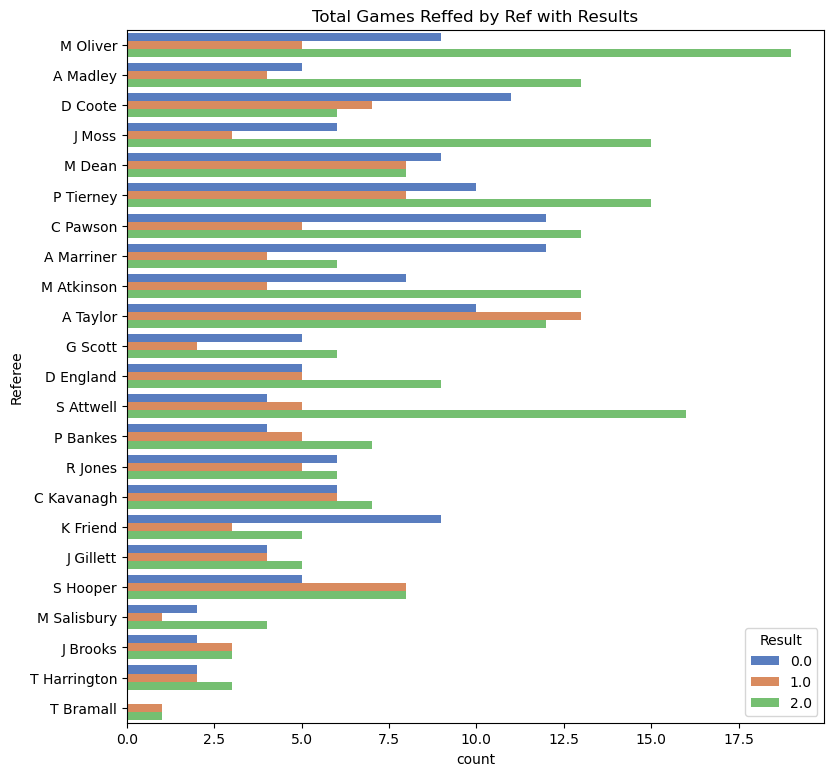

In [20]:
#Bar plot showing how many games each ref reffed
plt.figure(figsize=(9, 9))
sns.countplot(data = ref_impact, y="Referee", hue= 'Result', palette = 'muted')
plt.title("Total Games Reffed by Ref with Results")
plt.savefig(fname = '../figures/Total Games Reffed by Ref with Results', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [21]:
# percentage of value counts for target variable
final_dataset.Result.value_counts(normalize=True)

2.0    0.437637
0.0    0.319475
1.0    0.242888
Name: Result, dtype: float64

In [22]:
#stats for final_dataset
final_dataset.describe().round(2)

B365H   B365D   B365A     HICT     AICT   DifICT  Result
count  457.00  457.00  457.00   457.00   457.00   457.00  457.00
mean     3.03    4.24    4.66  8262.01  8226.76    35.24    1.12
std      2.32    1.45    4.39   505.94   496.46   590.51    0.86
min      1.06    2.80    1.14  7300.00  7300.00 -1473.20    0.00
25%      1.61    3.40    2.15  7891.30  7864.20  -354.40    0.00
50%      2.25    3.75    3.25  8198.50  8145.80    30.40    1.00
75%      3.40    4.50    5.50  8568.40  8515.20   415.00    2.00
max     19.00   13.00   29.00  9801.00  9809.20  1573.30    2.00

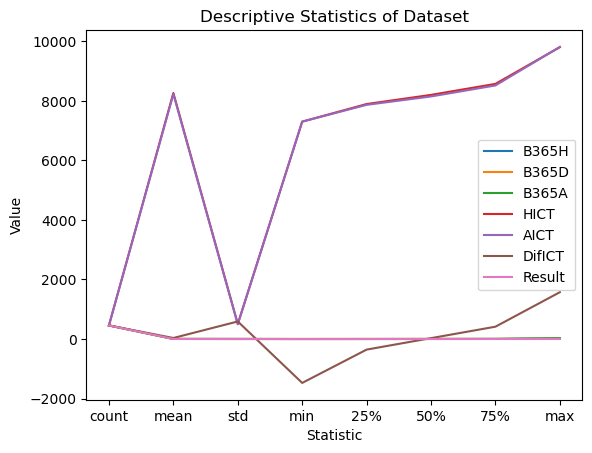

In [23]:
#stats for final_dataset plot
final_dataset.describe().round(2).plot()
plt.title("Descriptive Statistics of Dataset")
plt.ylabel("Value")
plt.xlabel("Statistic")
plt.savefig(fname = '../figures/Descriptive Statistics of Dataset', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [24]:
#info on final_dataset
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Referee  457 non-null    object 
 1   B365H    457 non-null    float64
 2   B365D    457 non-null    float64
 3   B365A    457 non-null    float64
 4   HICT     457 non-null    float64
 5   AICT     457 non-null    float64
 6   DifICT   457 non-null    float64
 7   Result   457 non-null    float64
dtypes: float64(7), object(1)
memory usage: 28.7+ KB


In [25]:
#calculates correlation between Result and other values
correlation = final_dataset.corr().abs().unstack()
correlation = correlation.sort_values(ascending=False)
correlation.Result

Result    1.000000
DifICT    0.419218
B365H     0.412218
B365A     0.360987
AICT      0.256969
HICT      0.237133
B365D     0.169424
dtype: float64

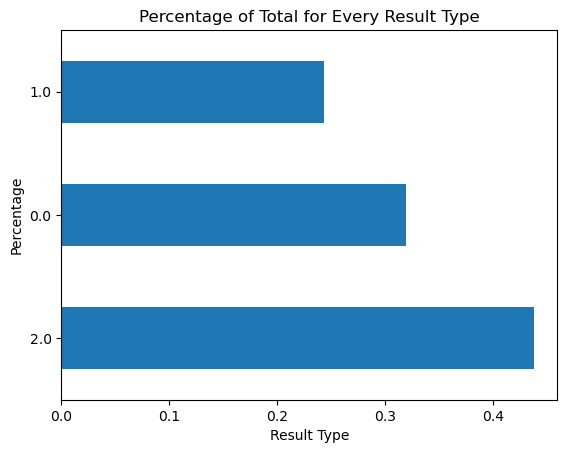

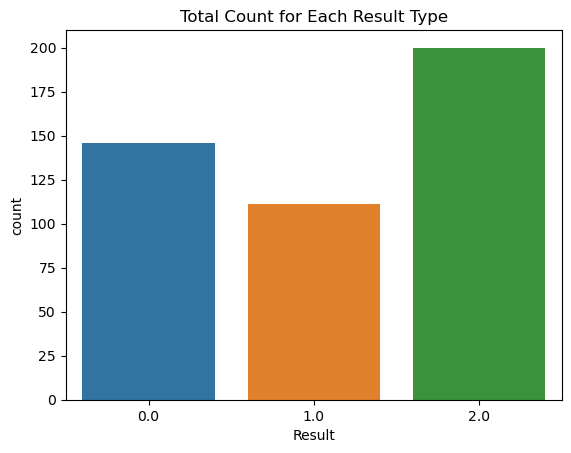

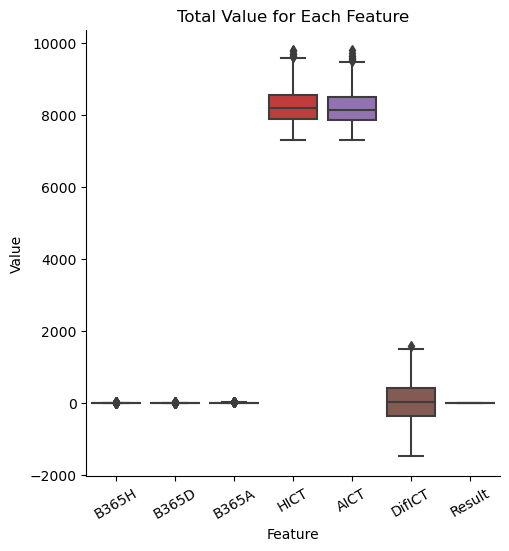

In [26]:
#count plots 
final_dataset.Result.value_counts(normalize=True).plot.barh()
plt.title("Percentage of Total for Every Result Type")
plt.savefig(fname = '../figures/Percentage of total for Each Result Type', format = 'png', dpi = 300, bbox_inches='tight')
plt.xlabel("Result Type")
plt.ylabel("Percentage")
plt.show()

count_plot = sns.countplot(x=final_dataset["Result"])
plt.title("Total Count for Each Result Type")
plt.savefig(fname = '../figures/Total Count for Each Result Type', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

fd_box = sns.catplot(data=final_dataset, kind="box")
fd_box.set_xticklabels(rotation=30)
plt.title("Total Value for Each Feature")
plt.ylabel("Value")
plt.xlabel("Feature")
plt.savefig(fname = '../figures/Total Value for Each Feature', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [27]:
#correlation between Result and specifc result outcomes
spearman = final_dataset[['Result', 'DifICT']].copy()
spearman['Home Wins']=(spearman['Result']==2.0).astype(int)
spearman['Away Wins']=(spearman['Result']==0.0).astype(int)
spearman['Draw']=(spearman['Result']==1.0).astype(int)
my_r = spearman.corr(method="spearman")
print(my_r)

             Result    DifICT  Home Wins  Away Wins      Draw
Result     1.000000  0.406597   0.921626  -0.866223 -0.124334
DifICT     0.406597  1.000000   0.356479  -0.375703 -0.003887
Home Wins  0.921626  0.356479   1.000000  -0.604428 -0.499657
Away Wins -0.866223 -0.375703  -0.604428   1.000000 -0.388079
Draw      -0.124334 -0.003887  -0.499657  -0.388079  1.000000


In [28]:
spearman_noD = final_dataset[['Result', 'DifICT']].copy()
spearman_noD = spearman_noD[spearman_noD.Result != 1.0]
spearman_noD['Home Wins']=(spearman_noD['Result']==2.0).astype(int)
spearman_noD['Away wins']=(spearman_noD['Result']==0.0).astype(int)
spearman_noD['Draw']=(spearman_noD['Result']==1.0).astype(int)
my_r = spearman_noD.corr(method="spearman")
print(my_r)

             Result    DifICT  Home Wins  Away wins  Draw
Result     1.000000  0.457151   1.000000  -1.000000   NaN
DifICT     0.457151  1.000000   0.457151  -0.457151   NaN
Home Wins  1.000000  0.457151   1.000000  -1.000000   NaN
Away wins -1.000000 -0.457151  -1.000000   1.000000   NaN
Draw            NaN       NaN        NaN        NaN   NaN


In [29]:
spearman_win_draw = final_dataset[['Result', 'DifICT']].copy()
spearman_win_draw['Away Wins/Draws']=(spearman_win_draw['Result']!=2.0).astype(int)
spearman_win_draw['Home Wins/Draws']=(spearman_win_draw['Result']!=0.0).astype(int)
my_r = spearman_win_draw.corr(method="spearman")
print(my_r)

                   Result    DifICT  Away Wins/Draws  Home Wins/Draws
Result           1.000000  0.406597        -0.921626         0.866223
DifICT           0.406597  1.000000        -0.356479         0.375703
Away Wins/Draws -0.921626 -0.356479         1.000000        -0.604428
Home Wins/Draws  0.866223  0.375703        -0.604428         1.000000


In [30]:
def display_correlation(df):
    r = df.corr(method="spearman")
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(df.corr(), vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Spearman Correlation - Result Types and DifICT")
    return(r)

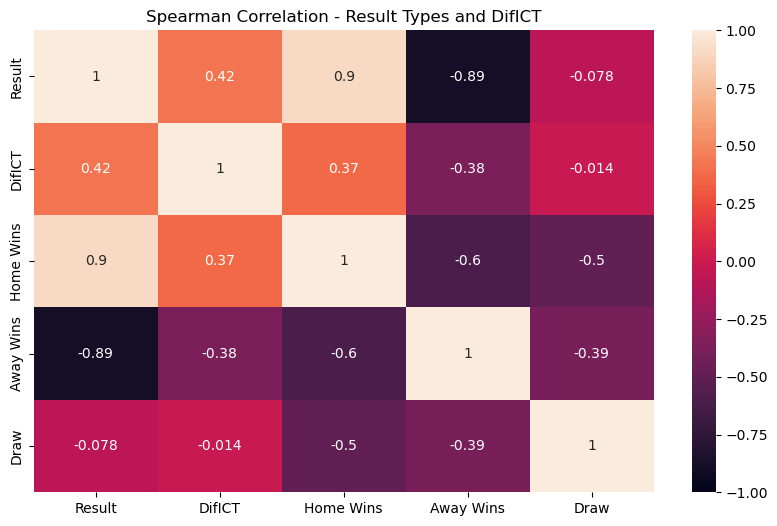

In [31]:
r_simple=display_correlation(spearman)
plt.savefig(fname = '../figures/Spearman Correlation', format = 'png', dpi = 300, bbox_inches='tight')

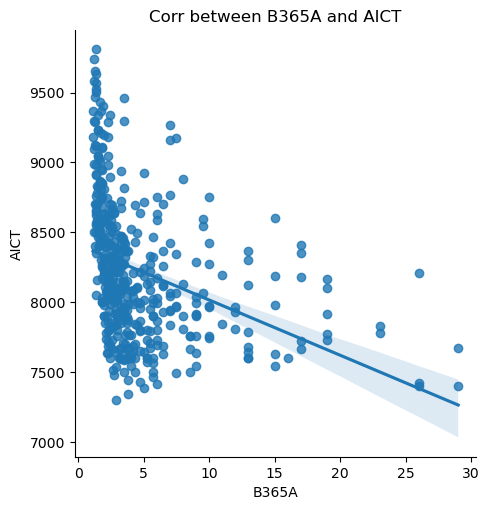

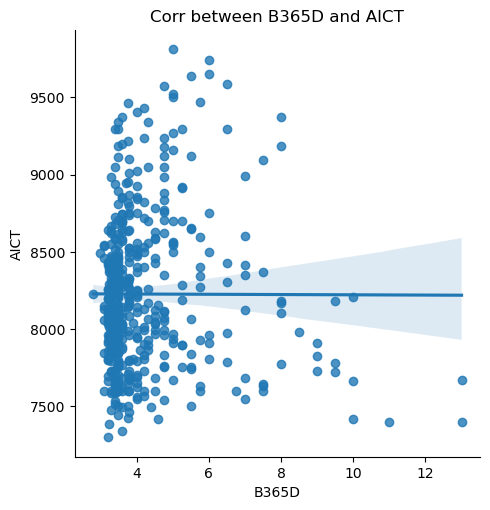

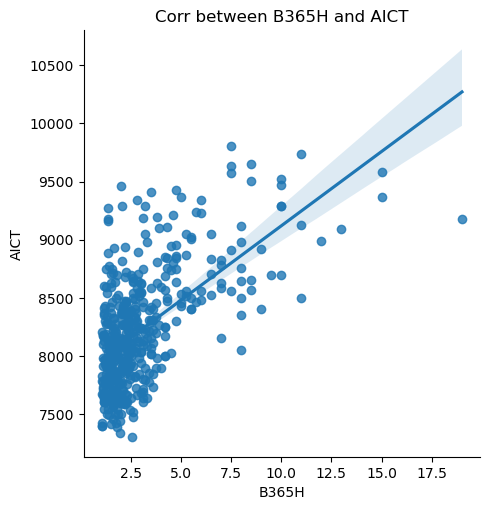

In [32]:
#scatter plots between odds and AICT
sns.lmplot(x='B365A',y='AICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365A and AICT")
plt.savefig(fname = '../figures/Corr between B365A and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365D',y='AICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365D and AICT")
plt.savefig(fname = '../figures/Corr between B365D and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365H',y='AICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365H and AICT")
plt.savefig(fname = '../figures/Corr between B365H and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

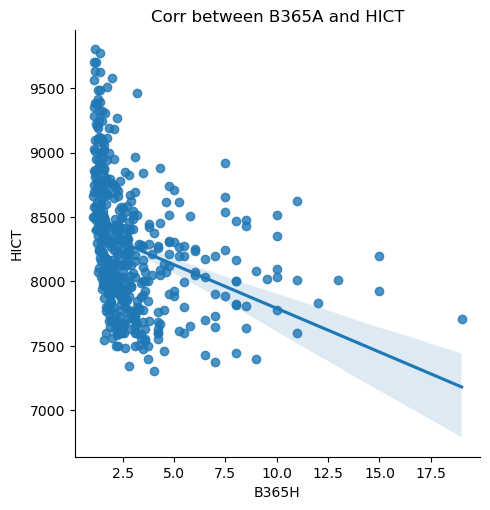

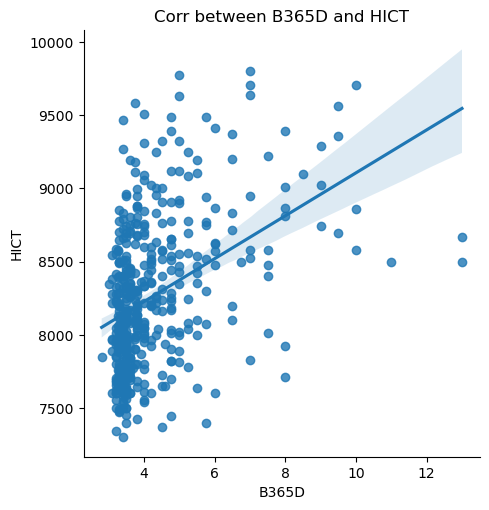

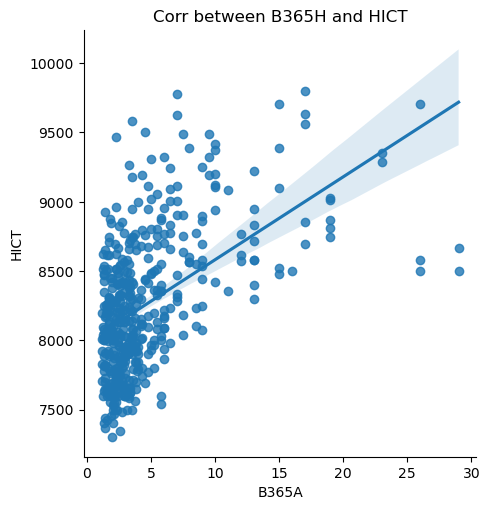

In [33]:
#scatter plots between odds and HICT
sns.lmplot(x='B365H',y='HICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365A and HICT")
plt.savefig(fname = '../figures/Corr between B365A and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365D',y='HICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365D and HICT")
plt.savefig(fname = '../figures/Corr between B365D and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365A',y='HICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365H and HICT")
plt.savefig(fname = '../figures/Corr between B365H and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

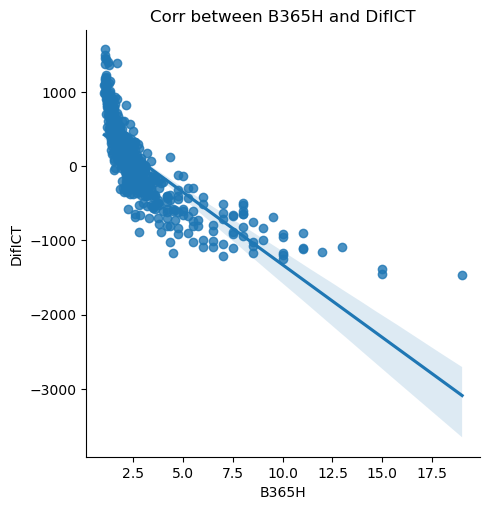

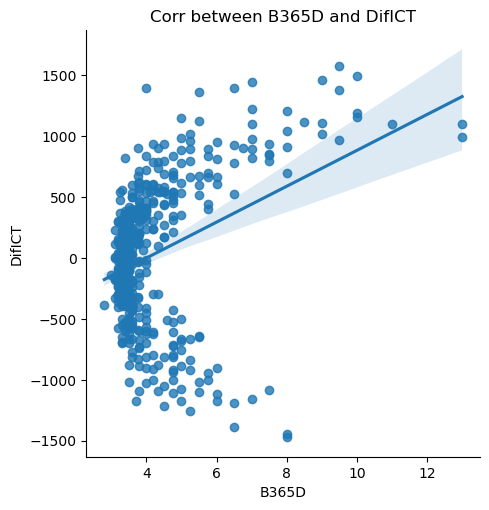

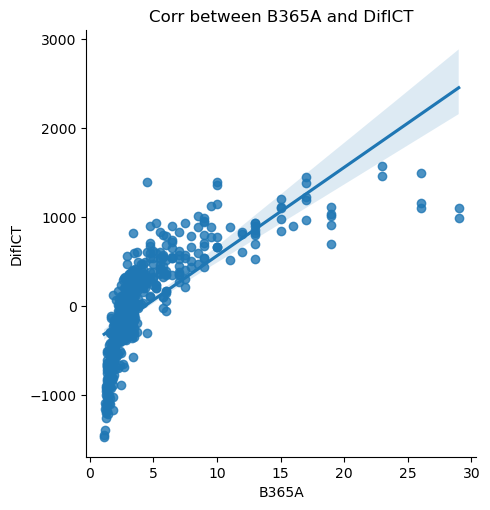

In [34]:
#scatter plots between odds and DifICT
sns.lmplot(x='B365H',y='DifICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365H and DifICT")
plt.savefig(fname = '../figures/Corr between B365H and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365D',y='DifICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365D and DifICT")
plt.savefig(fname = '../figures/Corr between B365D and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365A',y='DifICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365A and DifICT")
plt.savefig(fname = '../figures/Corr between B365A and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

[ 0.99781182 -0.00707661  0.06121283 -0.06239719  0.04126072  0.00591132
  0.03895573  0.01011961 -0.04004851 -0.00469456]


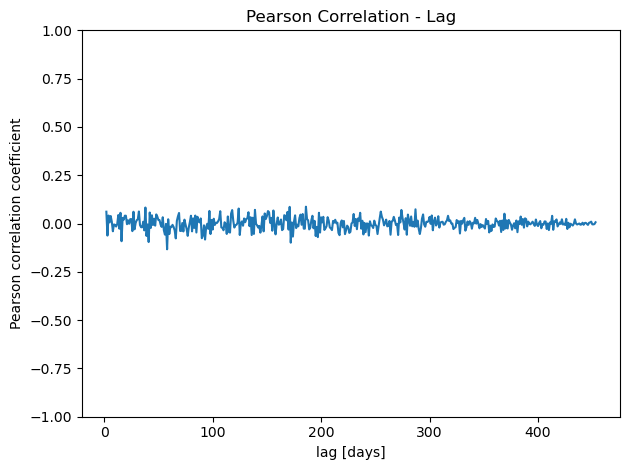

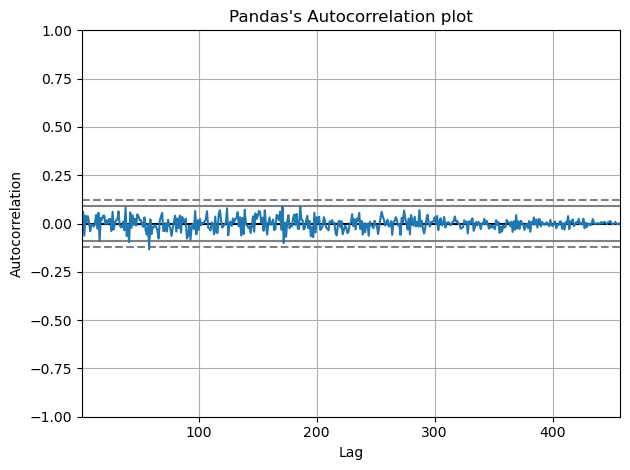

In [35]:
#auto correlation plot
lags = np.arange(457)
corr_coefs = np.zeros(457)

for i in np.arange(len(lags)):
    x = final_dataset['Result'].iloc[i:-1].reset_index(drop=True) # recent observations
    y = final_dataset['Result'].iloc[:-i-1].reset_index(drop=True) # lag-shifted observations
    # the shapes must be the same
    if x.shape != y.shape:
        raise ValueError('shape mismatch!')
    # Pearson correlation multiplied by the fraction of time series used
    corr_coefs[i] = x.corr(y,method='pearson')*x.shape[0]/final_dataset['Result'].shape[0]
print(corr_coefs[:10])

pearson_corr_lag = plt.plot(lags[2:],corr_coefs[2:])
plt.ylim([-1,1])
plt.xlabel('lag [days]')
plt.ylabel('Pearson correlation coefficient')
plt.title('Pearson Correlation - Lag')
plt.tight_layout()
plt.savefig(fname = '../figures/Pearson Correlation - Lag', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

# a one-liner
panda_auto_corr = pd.plotting.autocorrelation_plot(final_dataset['Result'])
plt.title("Pandas's Autocorrelation plot")
plt.tight_layout()
plt.savefig(fname = '../figures/Pandas Autocorrelation plot', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

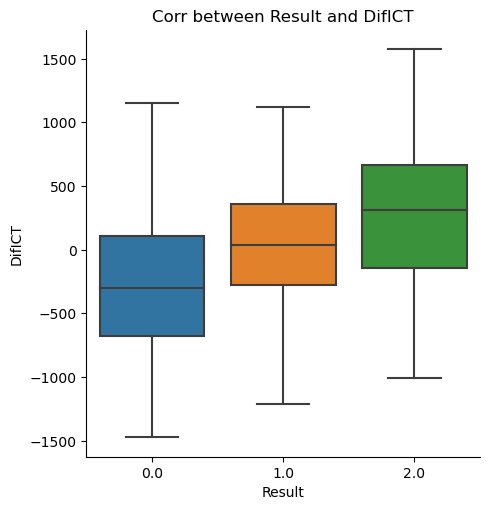

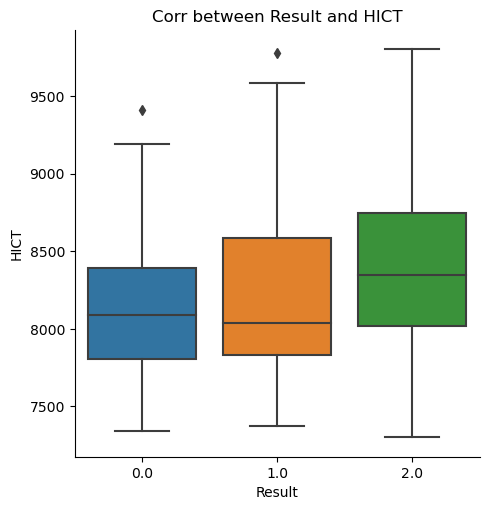

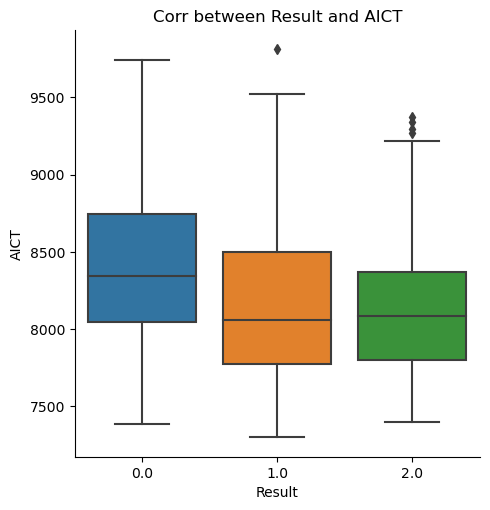

In [36]:
#box plot for result variable with DifICT, HICT, AICT
sns.catplot(data=final_dataset, x="Result", y="DifICT", kind="box")
plt.title("Corr between Result and DifICT")
plt.savefig(fname = '../figures/Corr between Result and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.catplot(data=final_dataset, x="Result", y="HICT", kind="box")
plt.title("Corr between Result and HICT")
plt.savefig(fname = '../figures/Corr between Result and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.catplot(data=final_dataset, x="Result", y="AICT", kind="box")
plt.title("Corr between Result and AICT")
plt.savefig(fname = '../figures/Corr between Result and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

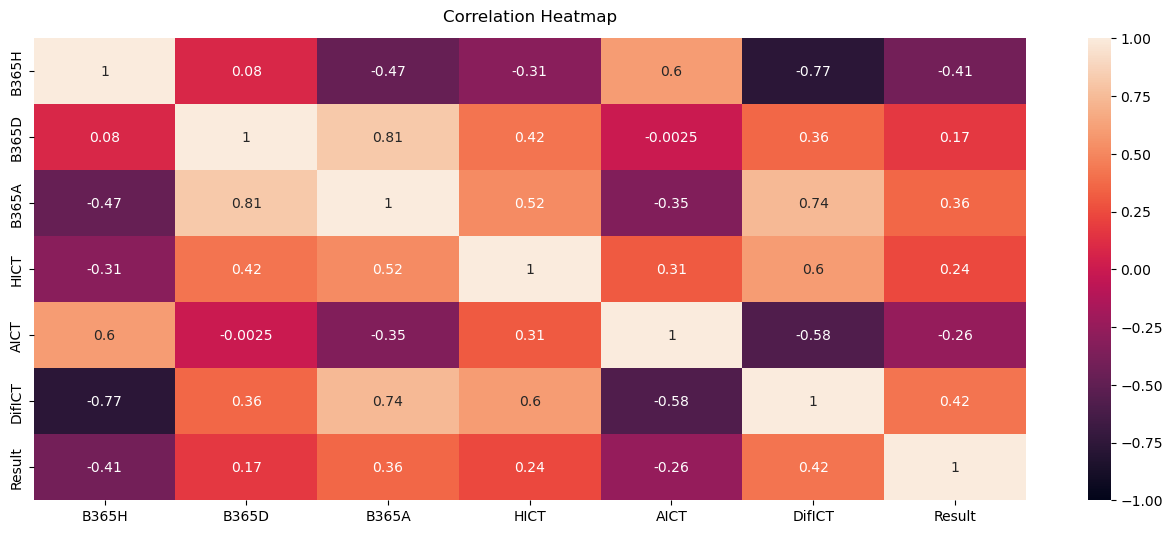

In [37]:
#Correlation Heatmap of all features
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(final_dataset.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig(fname = '../figures/Correlation Heatmap - All Features', format = 'png', dpi = 300, bbox_inches='tight')

In [38]:
#pointbiserial
from scipy.stats import pointbiserialr

copy = final_dataset
copy = copy.drop('Result', axis=1)
copy = copy.drop('Referee', axis=1)
result = final_dataset.copy()

from scipy import stats
corr_list = []
y = result['Result'].astype(float)

for column in copy:
    x=copy[column]
    corr = stats.pointbiserialr(list(x), list(y))
    corr_list.append(corr[0])
print(corr_list)

[-0.41221816029361436, 0.16942449104528334, 0.3609873022870327, 0.23713297665884991, -0.25696913103474944, 0.41921754451477955]


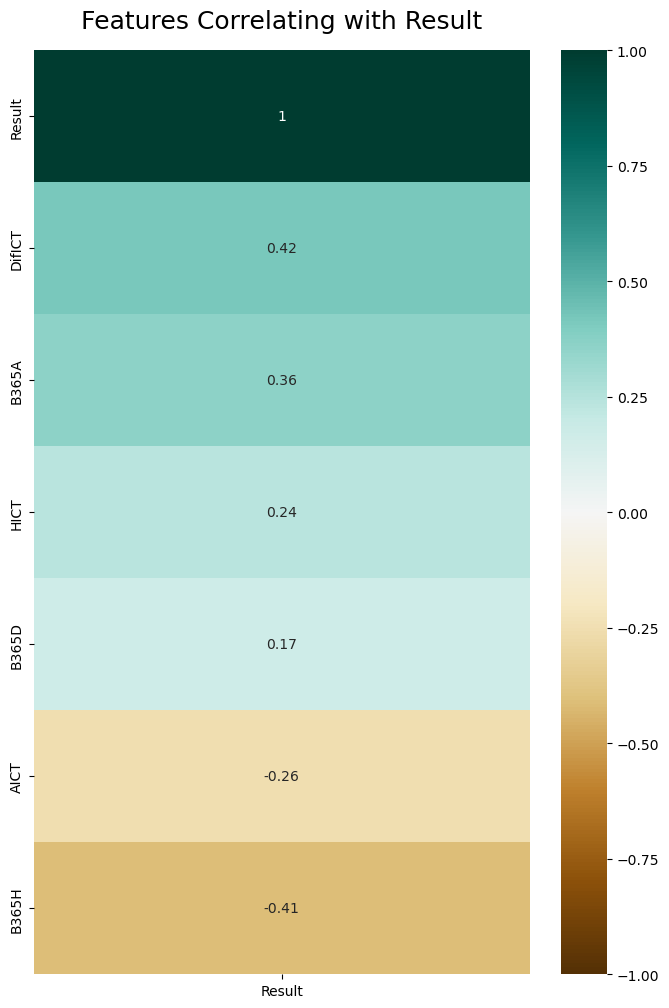

In [39]:
#Correlation Heatmap of all features with target variable
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(final_dataset.corr()[['Result']].sort_values(by='Result', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Result', fontdict={'fontsize':18}, pad=16);
plt.savefig(fname = '../figures/Features Correlating with Result', format = 'png', dpi = 300, bbox_inches='tight')

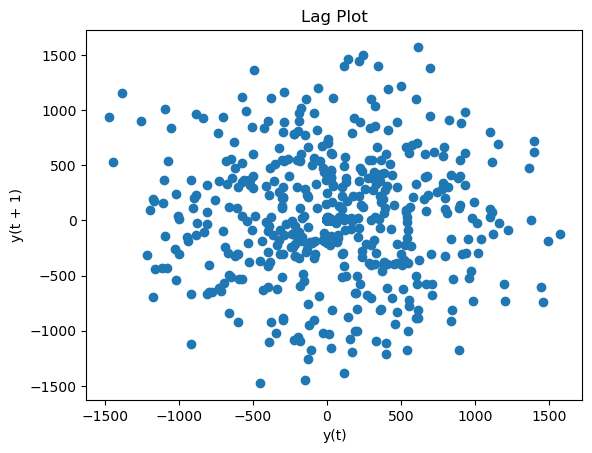

In [40]:
#lag plot
Referee = final_dataset['Referee']
Result = final_dataset['Result']
B365H = final_dataset['B365H']
B365D = final_dataset['B365D']
B365A = final_dataset['B365A']
HICT = final_dataset['HICT']
AICT = final_dataset['AICT']
lag_plot = final_dataset[['DifICT', 'B365A', 'B365D', 'B365H']]

pd.plotting.lag_plot(lag_plot, lag=1)
plt.title('Lag Plot')
plt.savefig(fname = '../figures/Lag Plot', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [41]:
# final_dataset = final_dataset.loc[final_dataset['Result'] != 1]
# final_dataset

# Lagging

In [42]:
#creation of data with 7 lags

#features to lag
Referee = final_dataset['Referee']
Result = final_dataset['Result']
B365H = final_dataset['B365H']
B365D = final_dataset['B365D']
B365A = final_dataset['B365A']
HICT = final_dataset['HICT']
AICT = final_dataset['AICT']
DifICT = final_dataset['DifICT']

y7 = final_dataset['Result']
X7 = pd.concat([Referee, Result, 
                
                
B365H.shift(7),B365H.shift(6),B365H.shift(5),B365H.shift(4),B365H.shift(3),B365H.shift(2), B365H.shift(1),B365H, 
                
B365D.shift(7),B365D.shift(6), B365D.shift(5),B365D.shift(4),B365D.shift(3), B365D.shift(2),B365D.shift(1),B365D, 

B365A.shift(7),B365A.shift(6), B365A.shift(5),B365A.shift(4), B365A.shift(3),B365A.shift(2),B365A.shift(1),B365A, 

HICT.shift(7),HICT.shift(6), HICT.shift(5),HICT.shift(4),HICT.shift(3),HICT.shift(2),HICT.shift(1),HICT, 
               
AICT.shift(7),AICT.shift(6), AICT.shift(5),AICT.shift(4),AICT.shift(3),AICT.shift(2),AICT.shift(1),AICT, 
               
DifICT.shift(7),DifICT.shift(6), DifICT.shift(5),DifICT.shift(4),DifICT.shift(3),DifICT.shift(2),DifICT.shift(1),DifICT],
              
               axis=1)

X7.columns = ['Referee', 'Result',
              
              'B365H lag 7 matches','B365H lag 6 matches','B365H lag 5 matches', 'B365H lag 4 matches', 
              'B365H lag 3 matches','B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
             
              'B365D lag 7 matches', 'B365D lag 6 matches', 'B365D lag 5 matches', 'B365D lag 4 matches', 
              'B365D lag 3 matches', 'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
             
              'B365A lag 7 matches', 'B365A lag 6 matches', 'B365A lag 5 matches', 'B365A lag 4 matches', 
              'B365A lag 3 matches','B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
             
              'HICT lag 7 matches', 'HICT lag 6 matches', 'HICT lag 5 matches', 'HICT lag 4 matches', 
              'HICT lag 3 matches','HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
             
              'AICT lag 7 matches', 'AICT lag 6 matches', 'AICT lag 5 matches', 'AICT lag 4 matches', 
              'AICT lag 3 matches','AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match',
              
              'DifICT lag 7 matches', 'DifICT lag 6 matches', 'DifICT lag 5 matches', 'DifICT lag 4 matches', 
              'DifICT lag 3 matches','DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match'] 

# print(X7.tail(10))
# print(y7.tail(10))

In [43]:
#creation of data with 5 lags
y5 = final_dataset['Result']
X5 = pd.concat([Referee, Result, B365H.shift(5),B365H.shift(4),B365H.shift(3),B365H.shift(2),
               B365H.shift(1),B365H, B365D.shift(5),B365D.shift(4),B365D.shift(3),
               B365D.shift(2),B365D.shift(1),B365D, B365A.shift(5),B365A.shift(4),
               B365A.shift(3),B365A.shift(2),B365A.shift(1),B365A, HICT.shift(5),
               HICT.shift(4),HICT.shift(3),HICT.shift(2),HICT.shift(1),HICT, 
               AICT.shift(5),AICT.shift(4),AICT.shift(3),AICT.shift(2),AICT.shift(1),AICT, 
               DifICT.shift(5),DifICT.shift(4),DifICT.shift(3),DifICT.shift(2),DifICT.shift(1),DifICT],
              axis=1)

X5.columns = ['Referee', 'Result',
             
             'B365H lag 5 matches', 'B365H lag 4 matches', 'B365H lag 3 matches', 
             'B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
             
             'B365D lag 5 matches', 'B365D lag 4 matches', 'B365D lag 3 matches', 
             'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
             
             'B365A lag 5 matches', 'B365A lag 4 matches', 'B365A lag 3 matches', 
             'B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
             
             'HICT lag 5 matches', 'HICT lag 4 matches', 'HICT lag 3 matches', 
             'HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
             
             'AICT lag 5 matches', 'AICT lag 4 matches', 'AICT lag 3 matches', 
             'AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match',
             
             'DifICT lag 5 matches', 'DifICT lag 4 matches', 'DifICT lag 3 matches', 
             'DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match'] 

# print(X5.tail(10))
# print(y5.tail(10))

In [44]:
#lag 3

y3 = final_dataset['Result']
X3 = pd.concat([Referee, Result, B365H.shift(3),B365H.shift(2),
               B365H.shift(1),B365H, B365D.shift(3), B365D.shift(2),B365D.shift(1),B365D, B365A.shift(3),
               B365A.shift(2),B365A.shift(1),B365A, HICT.shift(3),HICT.shift(2),HICT.shift(1),HICT, 
               AICT.shift(3),AICT.shift(2),AICT.shift(1),AICT, DifICT.shift(3),DifICT.shift(2),DifICT.shift(1),
               DifICT],axis=1)

X3.columns = ['Referee','Result','B365H lag 3 matches', 'B365H lag 2 matches', 'B365H lag 1 match', 
             'B365H most recent match','B365D lag 3 matches','B365D lag 2 matches', 'B365D lag 1 match', 
             'B365D most recent match','B365A lag 3 matches','B365A lag 2 matches', 'B365A lag 1 match', 
             'B365A most recent match', 'HICT lag 3 matches','HICT lag 2 matches', 'HICT lag 1 match', 
             'HICT most recent match','AICT lag 3 matches','AICT lag 2 matches', 'AICT lag 1 match', 
             'AICT most recent match', 'DifICT lag 3 matches','DifICT lag 2 matches', 'DifICT lag 1 match', 
             'DifICT most recent match'] 

# print(X3.tail(10))
# print(y3.tail(10))

In [45]:
#lag 1
y1 = final_dataset['Result']
X1 = pd.concat([Referee, Result, B365H.shift(1),B365H, B365D.shift(1),B365D,B365A.shift(1),B365A, HICT.shift(1),
               HICT ,AICT.shift(1),AICT,DifICT.shift(1), DifICT],axis=1)

X1.columns = ['Referee', 'Result','B365H lag 1 match', 
             'B365H most recent match', 'B365D lag 1 match', 
             'B365D most recent match', 'B365A lag 1 match', 
             'B365A most recent match', 'HICT lag 1 match', 
             'HICT most recent match','AICT lag 1 match', 
             'AICT most recent match', 'DifICT lag 1 match', 
             'DifICT most recent match'] 

# print(X1.tail(10))
# print(y1.tail(10))

# Encoding

In [46]:


# collect which encoder to use on each feature
onehot_ftrs_7 = ['Referee']
minmax_ftrs_7 = ['HICT lag 7 matches', 'HICT lag 6 matches','HICT lag 5 matches', 'HICT lag 4 matches', 
                 'HICT lag 3 matches', 'HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
            
                 'AICT lag 7 matches', 'AICT lag 6 matches','AICT lag 5 matches', 'AICT lag 4 matches', 
                 'AICT lag 3 matches','AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match']
               
std_ftrs_7 = ['B365H lag 7 matches', 'B365H lag 6 matches', 'B365H lag 5 matches', 'B365H lag 4 matches', 
              'B365H lag 3 matches','B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
              
              'B365D lag 7 matches', 'B365D lag 6 matches', 'B365D lag 5 matches', 'B365D lag 4 matches', 
              'B365D lag 3 matches', 'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
              
              'B365A lag 7 matches', 'B365A lag 6 matches', 'B365A lag 5 matches', 'B365A lag 4 matches', 
              'B365A lag 3 matches', 'B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
              
              'DifICT lag 7 matches', 'DifICT lag 6 matches','DifICT lag 5 matches', 'DifICT lag 4 matches', 
              'DifICT lag 3 matches', 'DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match']
    
# collect all the encoders
preprocessor_7 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs_7),
        ('minmax', MinMaxScaler(), minmax_ftrs_7),
        ('std', StandardScaler(), std_ftrs_7)])

#create dataframe for splitting
X7_lagged = X7.iloc[7:].reset_index(drop = True)
X7_lagged = X7_lagged.drop(['Result'], axis = 1)
y7_lagged = y7.iloc[7:].reset_index(drop = True)

y7_lagged.to_csv('../results/Tables/y7_lagged.csv')
X7_lagged.to_csv('../results/Tables/X7_lagged.csv')


In [47]:
# collect which encoder to use on each feature
onehot_ftrs_5 = ['Referee']
minmax_ftrs_5 = ['HICT lag 5 matches', 'HICT lag 4 matches', 'HICT lag 3 matches', 
               'HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
            
               'AICT lag 5 matches', 'AICT lag 4 matches', 'AICT lag 3 matches', 
               'AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match']
               
std_ftrs_5 = ['B365H lag 5 matches', 'B365H lag 4 matches', 'B365H lag 3 matches', 
            'B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
             
            'B365D lag 5 matches', 'B365D lag 4 matches', 'B365D lag 3 matches', 
            'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
             
            'B365A lag 5 matches', 'B365A lag 4 matches', 'B365A lag 3 matches', 
            'B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
             
            'DifICT lag 5 matches', 'DifICT lag 4 matches', 'DifICT lag 3 matches', 
            'DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match']
    
# collect all the encoders
preprocessor_5 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs_5),
        ('minmax', MinMaxScaler(), minmax_ftrs_5),
        ('std', StandardScaler(), std_ftrs_5)])

#create dataframe for splitting
X5_lagged = X5.iloc[5:].reset_index(drop = True)
X5_lagged = X5_lagged.drop(['Result'], axis = 1)

y5_lagged = y5.iloc[5:].reset_index(drop = True)

In [48]:
# collect which encoder to use on each feature
onehot_ftrs_3 = ['Referee']
minmax_ftrs_3 = ['HICT lag 3 matches', 
               'HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
            
               'AICT lag 3 matches', 
               'AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match']
               
std_ftrs_3 = ['B365H lag 3 matches', 
            'B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
             
           'B365D lag 3 matches', 
            'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
             
            'B365A lag 3 matches', 
            'B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
             
            'DifICT lag 3 matches', 
            'DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match']
    
# collect all the encoders
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs_3),
        ('minmax', MinMaxScaler(), minmax_ftrs_3),
        ('std', StandardScaler(), std_ftrs_3)])

#create dataframe for splitting
X3_lagged = X3.iloc[3:].reset_index(drop = True)
X3_lagged = X3_lagged.drop(['Result'], axis = 1)

y3_lagged = y3.iloc[3:].reset_index(drop = True)

In [49]:
# collect which encoder to use on each feature
onehot_ftrs_1 = ['Referee']
minmax_ftrs_1 = ['HICT lag 1 match', 'HICT most recent match',       
            
               'AICT lag 1 match', 'AICT most recent match']
               
std_ftrs_1 = ['B365H lag 1 match', 'B365H most recent match',
             
           'B365D lag 1 match', 'B365D most recent match',
             
             'B365A lag 1 match', 'B365A most recent match',       
             
            'DifICT lag 1 match', 'DifICT most recent match']
    
# collect all the encoders
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs_1),
        ('minmax', MinMaxScaler(), minmax_ftrs_1),
        ('std', StandardScaler(), std_ftrs_1)])

#create dataframe for splitting
X1_lagged = X1.iloc[1:].reset_index(drop = True)
X1_lagged = X1_lagged.drop(['Result'], axis = 1)

y1_lagged = y1.iloc[1:].reset_index(drop = True)

# Models

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import statistics as stat
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from catboost import CatBoostClassifier
import lightgbm as LGB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
import pickle

RF score: 51.0%, std: 8.0%
L1_saga score: 51.0%, std: 2.0%
L2 score: 52.0%, std: 1.0%
CATBOOST score: 53.0%, std: 3.0%
EN score: 53.0%, std: 2.0%
SVC score: 47.5%, std: 2.5%
Lightgbm score: 51.0%, std: 4.0%


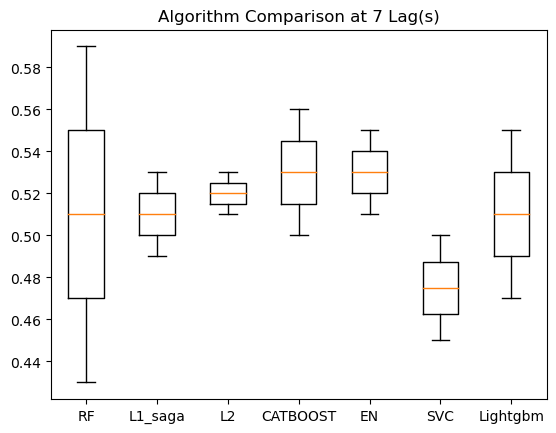

RF score: 53.5%, std: 3.5%
L1_saga score: 53.5%, std: 6.5%
L2 score: 47.5%, std: 1.5%
CATBOOST score: 48.0%, std: 8.0%
EN score: 53.0%, std: 3.0%
SVC score: 41.5%, std: 0.5%
Lightgbm score: 45.5%, std: 7.5%


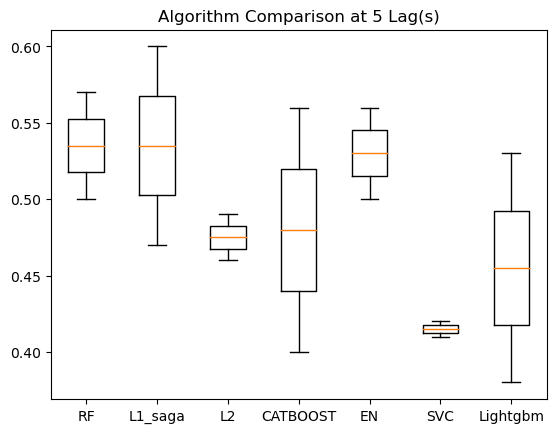

RF score: 47.5%, std: 5.0%
L1_saga score: 52.5%, std: 5.9%
L2 score: 48.5%, std: 0.0%
CATBOOST score: 44.6%, std: 8.9%
EN score: 51.5%, std: 3.0%
SVC score: 43.6%, std: 3.0%
Lightgbm score: 51.5%, std: 4.0%


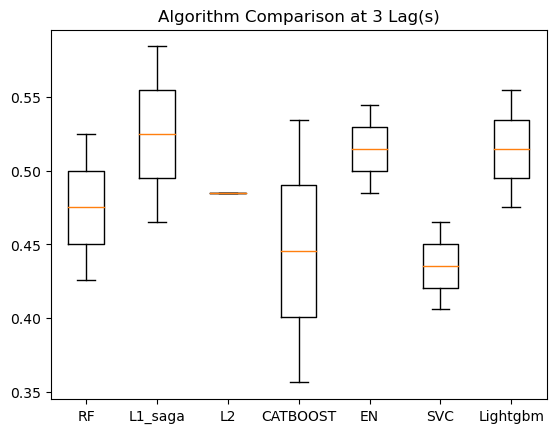

RF score: 52.5%, std: 2.0%
L1_saga score: 54.5%, std: 2.0%
L2 score: 54.5%, std: 1.0%
CATBOOST score: 50.5%, std: 6.9%
EN score: 54.0%, std: 1.5%
SVC score: 51.5%, std: 2.0%
Lightgbm score: 50.5%, std: 5.9%


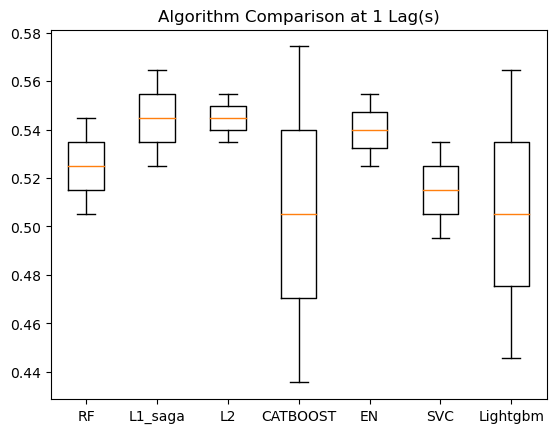

In [51]:
#function that compares models with no tuning
def Modelcomparison(X, y, preprocessor, lags): 
    ''' Returns a plot that has '''
    models = []
    models.append(('RF', RandomForestClassifier()))
    models.append(('L1_saga', LogisticRegression(max_iter= 100000,
                                                 penalty = 'l1', 
                                                 solver = 'saga')))
    models.append(('L2', LogisticRegression(penalty = 'l2')))
    models.append(('CATBOOST', CatBoostClassifier(logging_level = 'Silent')))
    models.append(('EN', LogisticRegression(max_iter= 100000, 
                                                 penalty = 'elasticnet', 
                                                 solver = 'saga', 
                                                 l1_ratio = 0.5)))
    models.append(('SVC', SVC()))
    models.append(('Lightgbm', LGB.LGBMClassifier()))




    # Evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        
        # TimeSeries Cross validation
        tscv = TimeSeriesSplit(2)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        prep = Pipeline(steps=[('preprocessor', preprocessor)])
        X_train_prep = prep.fit_transform(X_train)
        feature_names = prep.get_feature_names_out()
        df_train = pd.DataFrame(data=X_train_prep, columns=feature_names)
        cv_results = cross_val_score(model, df_train, y_train, cv=tscv, scoring='f1_micro')
        results.append(cv_results)
        names.append(name)
        mean = cv_results.mean() * 100
        std = cv_results.std() * 100
        
        #print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
        print(f'{name} ' f'score: {mean:.1f}%,', f'std: {std:.1f}%')

    # Compare Algorithms
    plt.boxplot(results, labels=names)
    plt.title('Algorithm Comparison at {} Lag(s)'.format(lags))
    plt.savefig(fname = '../figures/Algorith Comparison at {} Lag(s)'.format(lags), format = 'png', dpi = 300, bbox_inches='tight')
    plt.show()
    
Modelcomparison(X7_lagged, y7_lagged, preprocessor_7, 7)
Modelcomparison(X5_lagged, y5_lagged, preprocessor_5, 5)
Modelcomparison(X3_lagged, y3_lagged, preprocessor_3, 3)
Modelcomparison(X1_lagged, y1_lagged, preprocessor_1, 1)

L1_liblinear score: 53.0%, std: 5.0%
L1_saga score: 51.0%, std: 2.0%
L2 score: 52.0%, std: 1.0%
EN score: 53.0%, std: 2.0%


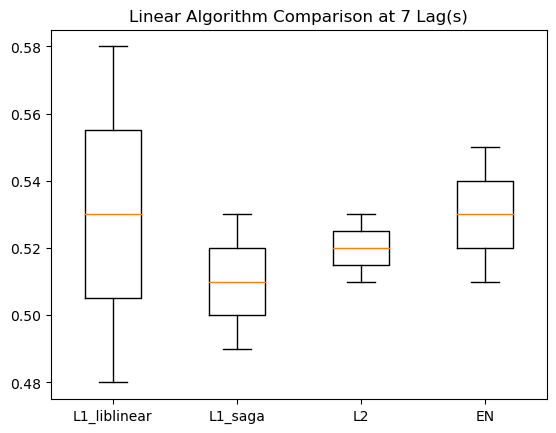

L1_liblinear score: 54.5%, std: 3.5%
L1_saga score: 53.5%, std: 6.5%
L2 score: 47.5%, std: 1.5%
EN score: 53.0%, std: 3.0%


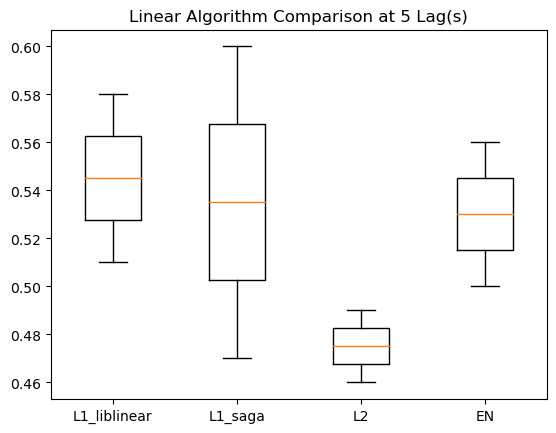

L1_liblinear score: 52.5%, std: 4.0%
L1_saga score: 52.5%, std: 5.9%
L2 score: 48.5%, std: 0.0%
EN score: 51.5%, std: 3.0%


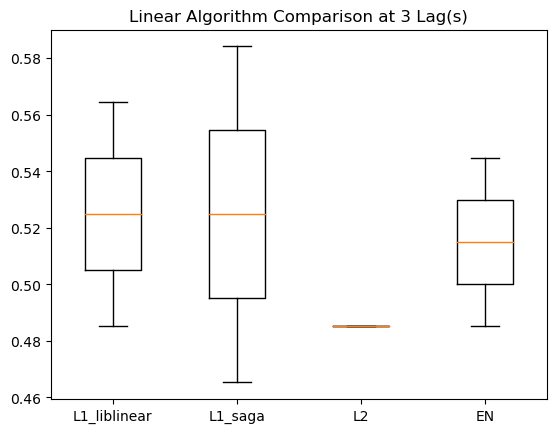

L1_liblinear score: 55.4%, std: 0.0%
L1_saga score: 54.5%, std: 2.0%
L2 score: 54.5%, std: 1.0%
EN score: 54.0%, std: 1.5%


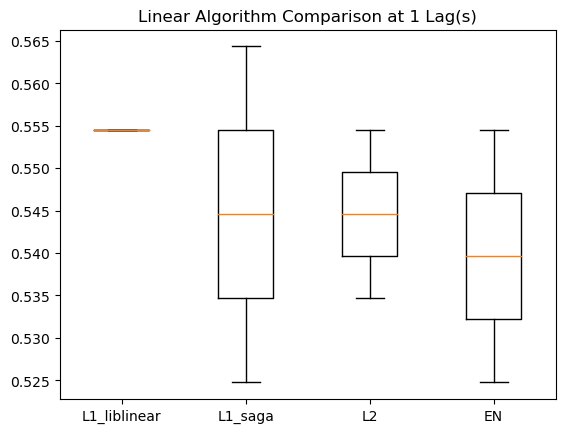

In [52]:
#function that compares models with no tuning (Specifically for different Logistic Regression solvers)
def Modelcomparison_log(X, y, preprocessor, lags): 
    '''  '''
    models = []
    models.append(('L1_liblinear', LogisticRegression(max_iter= 100000,
                                                 penalty = 'l1', 
                                                 solver = 'liblinear')))
    models.append(('L1_saga', LogisticRegression(max_iter= 100000,
                                                 penalty = 'l1', 
                                                 solver = 'saga')))
    models.append(('L2', LogisticRegression(penalty = 'l2')))
    models.append(('EN', LogisticRegression(max_iter= 100000, 
                                                 penalty = 'elasticnet', 
                                                 solver = 'saga', 
                                                 l1_ratio = 0.5)))

    # Evaluate each model in turn
    results = []
    names = []

    for name, model in models:
        # TimeSeries Cross validation
        tscv = TimeSeriesSplit(2)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        prep = Pipeline(steps=[('preprocessor', preprocessor)])
        X_train_prep = prep.fit_transform(X_train)
        feature_names = prep.get_feature_names_out()
        df_train = pd.DataFrame(data=X_train_prep, columns=feature_names)
        cv_results = cross_val_score(model, df_train, y_train, cv=tscv, scoring='f1_micro')
        results.append(cv_results)
        names.append(name)
        mean = cv_results.mean() * 100
        std = cv_results.std() * 100
        
        print(f'{name} ' f'score: {mean:.1f}%,', f'std: {std:.1f}%')

    # Compare Algorithms
    plt.boxplot(results, labels=names)
    plt.title('Linear Algorithm Comparison at {} Lag(s)'.format(lags))
    plt.savefig(fname = '../figures/Linear Alg Comparison at {} Lag(s)'.format(lags), format = 'png', dpi = 300, bbox_inches='tight')
    plt.show()
    
Modelcomparison_log(X7_lagged, y7_lagged, preprocessor_7, 7)
Modelcomparison_log(X5_lagged, y5_lagged, preprocessor_5, 5)
Modelcomparison_log(X3_lagged, y3_lagged, preprocessor_3, 3)
Modelcomparison_log(X1_lagged, y1_lagged, preprocessor_1, 1)

In [110]:
#ML Pipeline for L1
def MLpipe_RS_LR_Lasso(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    '''ML Pipeline for L1 Logistic Regression. Takes in a X df, the target variable, the number of splits for 
    timesplit, a preprocessor, the scoring method, the refit method, and lags of dataset
    Returns: best models, best test scores, confusion matrices, the lag used, and baseline scores of each split'''
    tscv = TimeSeriesSplit(n_splits)
    
    #create empty Variables
    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    #loop through random states
    for i in random_states:
        
        #set parameter grid
        param_grid = {'ml__penalty': ['l1'], 
              'ml__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'ml__solver': ['liblinear', 'saga'],
              'ml__random_state': [i],
                     }
        
        split_scores = []
            
        #save train states
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            #create pipeline
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            
            #use gridsearchcv to tune
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            
            #fit model
            gsearch.fit(X_train, y_train) 
            
            #save important info
            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            #predict and save accuracy scores/best models
            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            
            #if statement to determine baseline at split
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  
                
            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            #append baseline scores
            baseline_scores.append(baseline)
          
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))
            
            print('\nResult Distribution\n')
            print(y_test.value_counts())
            
            print('\nBaseline Score: {:.2f}'.format(baseline))
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
            
            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
        #create split scores
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    #create average scores
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags, baseline_scores


In [54]:
#ML Pipeline for L2
def MLpipe_RS_LR_Ridge(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    '''ML Pipeline for L2 Logistic Regression. Takes in a X df, the target variable, the number of splits for 
    timesplit, a preprocessor, the scoring method, the refit method, and lags of dataset
    Returns: best models, best test scores, confusion matrices, the lag used, and baseline scores of each split'''
    tscv = TimeSeriesSplit(n_splits)
    
    #create empty Variables
    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    #loop through random states
    for i in random_states:
        
        #set parameter grid
        param_grid = {'ml__penalty': ['l2'], 
              'ml__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'ml__solver': ['liblinear', 'saga'],
              'ml__random_state': [i]
             }
        
        split_scores = []
            
        #save train states
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            #create pipeline
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            
            #use gridsearchcv to tune
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            
            #fit model
            gsearch.fit(X_train, y_train) 
            
            #save important info
            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            #predict and save accuracy scores/best models
            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            
            #if statement to determine baseline at split
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  
                
            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            #append baseline scores
            baseline_scores.append(baseline)
          
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))
            
            print('\nResult Distribution\n')
            print(y_test.value_counts())
            
            print('\nBaseline Score: {:.2f}'.format(baseline))
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
            
            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
        #create split scores
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    #create average scores
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags, baseline_scores

In [55]:
#ML Pipeline for ElasticNet
def MLpipe_RS_LR_EN(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    '''ML Pipeline for Elastic Net Logistic Regression. Takes in a X df, the target variable, the number of splits for 
    timesplit, a preprocessor, the scoring method, the refit method, and lags of dataset
    Returns: best models, best test scores, confusion matrices, the lag used, and baseline scores of each split'''
    tscv = TimeSeriesSplit(n_splits)
    
    #create empty Variables
    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    #loop through random states
    for i in random_states:
        
        #set parameter grid
        param_grid = {'ml__penalty': ['elasticnet'], 
              'ml__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'ml__solver': ['saga'],
              'ml__random_state': [i],
              'ml__l1_ratio': [0.01, 0.99, 15]}
        
        split_scores = []
            
        #save train states
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            #create pipeline
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            
            #use gridsearchcv to tune
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            
            #fit model
            gsearch.fit(X_train, y_train) 
            
            #save important info
            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            #predict and save accuracy scores/best models
            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            
            #if statement to determine baseline at split
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  
                
            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            #append baseline scores
            baseline_scores.append(baseline)
          
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))
            
            print('\nResult Distribution\n')
            print(y_test.value_counts())
            
            print('\nBaseline Score: {:.2f}'.format(baseline))
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
            
            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
        #create split scores
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    #create average scores
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags, baseline_scores

In [56]:
#ML Pipeline for SVC
def MLpipe_RS_SVC(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    '''ML Pipeline for SVC. Takes in a X df, the target variable, the number of splits for 
    timesplit, a preprocessor, the scoring method, the refit method, and lags of dataset
    Returns: best models, best test scores, confusion matrices, the lag used, and baseline scores of each split'''
    tscv = TimeSeriesSplit(n_splits)
    
    #create empty Variables
    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    #loop through random states
    for i in random_states:
        
        #set parameter grid
        param_grid = {'ml__C': [1, 3, 10, 30, 100],
              'ml__kernel': ['linear'],
              'ml__gamma': ['auto', 'scale'],
              'ml__degree': range(1, 6, 1),
              'ml__probability': [True],
              'ml__random_state': [i]}
        
        split_scores = []
            
        #save train states
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            #create pipeline
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            
            #use gridsearchcv to tune
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            
            #fit model
            gsearch.fit(X_train, y_train) 
            
            #save important info
            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            #predict and save accuracy scores/best models
            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            
            #if statement to determine baseline at split
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  
                
            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            #append baseline scores
            baseline_scores.append(baseline)
          
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))
            
            print('\nResult Distribution\n')
            print(y_test.value_counts())
            
            print('\nBaseline Score: {:.2f}'.format(baseline))
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
            
            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
        #create split scores
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    #create average scores
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags, baseline_scores

In [75]:
#ML Pipeline for Random Forest
def MLpipe_RS_RF(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    '''ML Pipeline for Random Forest. Takes in a X df, the target variable, the number of splits for 
    timesplit, a preprocessor, the scoring method, the refit method, and lags of dataset
    Returns: best models, best test scores, confusion matrices, the lag used, and baseline scores of each split'''
    tscv = TimeSeriesSplit(n_splits)
    
    #create empty Variables
    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    #loop through random states
    for i in random_states:
        
        #set parameter grid
        param_grid = {'ml__max_depth': [10],
                      'ml__min_samples_leaf': [1, 3,5],
                      'ml__n_estimators': [50,100,200,500],
                      'ml__max_features': ['auto', 'sqrt', 'log2'],
                      'ml__random_state': [i]
             }
        
        split_scores = []
            
        #save train states
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            #create pipeline
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            
            #use gridsearchcv to tune
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            
            #fit model
            gsearch.fit(X_train, y_train) 
            
            #save important info
            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            #predict and save accuracy scores/best models
            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            
            #if statement to determine baseline at split
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  
                
            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            #append baseline scores
            baseline_scores.append(baseline)
          
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))
            
            print('\nResult Distribution\n')
            print(y_test.value_counts())
            
            print('\nBaseline Score: {:.2f}'.format(baseline))
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
            
            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
        #create split scores
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    #create average scores
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags



In [76]:
#ML Pipeline for CATBOOST
def MLpipe_RS_CAT(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    '''ML Pipeline for CATBOOST. Takes in a X df, the target variable, the number of splits for 
    timesplit, a preprocessor, the scoring method, the refit method, and lags of dataset
    Returns: best models, best test scores, confusion matrices, the lag used, and baseline scores of each split'''
    tscv = TimeSeriesSplit(n_splits)
    
    #create empty Variables
    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    #loop through random states
    for i in random_states:
        
        #set parameter grid
        param_grid = {'ml__depth':[3, 1, 10],
              'ml__random_seed': [i],
              'ml__iterations':[1, 10, 25],
              'ml__learning_rate':[.01, 0.03], 
              'ml__l2_leaf_reg':[5, 10, 100],
              'ml__border_count':[32, 5],
              'ml__thread_count':[4]}
        
        split_scores = []
            
        #save train states
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            #create pipeline
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            
            #use gridsearchcv to tune
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            
            #fit model
            gsearch.fit(X_train, y_train) 
            
            #save important info
            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            #predict and save accuracy scores/best models
            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)

            #if statement to determine baseline at split
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length

            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length

            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length

            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  

            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length

            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length

            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            #append baseline scores
            baseline_scores.append(baseline)

            print('---------------------------------------------------------------------------------------------------')

            print('\nBest Parameters\n')
            print(best_param)

            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))

            print('\nResult Distribution\n')
            print(y_test.value_counts())

            print('\nBaseline Score: {:.2f}'.format(baseline))
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))

        #create split scores
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    #create average scores
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags


In [77]:
#ML Pipeline for Lightgbm
def MLpipe_RS_lgb(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    '''ML Pipeline for LightGBM. Takes in a X df, the target variable, the number of splits for 
    timesplit, a preprocessor, the scoring method, the refit method, and lags of dataset
    Returns: best models, best test scores, confusion matrices, the lag used, and baseline scores of each split'''

    tscv = TimeSeriesSplit(n_splits)
    
    #create empty Variables
    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    #loop through random states
    for i in random_states:        
        
        #set parameter grid
        param_grid ={
            'ml__n_estimators': [5],
            'ml__num_leaves': [3,6,8,31], 
            'ml__max_depth': [40],
            'ml__colsample_bytree': [0.99],
            'ml__min_child_samples': [5,20,25,50], 
            'ml__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            'ml__random_state': [i]}
        
        split_scores = []
            
        #save train states
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            #create pipeline
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            
            #use gridsearchcv to tune
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            
            #fit model
            gsearch.fit(X_train, y_train) 
            
            #save important info
            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            #predict and save accuracy scores/best models
            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)

            #if statement to determine baseline at split
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length

            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length

            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length

            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  

            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length

            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length

            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            #append baseline scores
            baseline_scores.append(baseline)

            print('---------------------------------------------------------------------------------------------------')

            print('\nBest Parameters\n')
            print(best_param)

            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))

            print('\nResult Distribution\n')
            print(y_test.value_counts())

            print('\nBaseline Score: {:.2f}'.format(baseline))
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))

        #create split scores
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    #create average scores
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags


In [85]:
#ML Pipeline for Lightgbm (v2)
def MLpipe_RS_lgbv2(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    '''ML Pipeline for LightGBM. Takes in a X df, the target variable, the number of splits for 
    timesplit, a preprocessor, the scoring method, the refit method, and lags of dataset
    Returns: best models, best test scores, confusion matrices, the lag used, and baseline scores of each split'''
    
    X_other = X.iloc[:270]
    X_test = X.iloc[270:]
    y_other = y.iloc[:270]
    y_test = y.iloc[270:]
    print(y_test.value_counts())

    tscv = TimeSeriesSplit(n_splits)
    
    #create empty Variables
    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    
    #loop through random states
    for i in random_states:
        
        #set parameter grid
        param_grid ={
            'ml__n_estimators': [5],
            'ml__num_leaves': [3,6,8,31], 
            'ml__max_depth': [40],
            'ml__colsample_bytree': [0.99],
            'ml__min_child_samples': [5,20,25,50], 
            'ml__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            'ml__random_state': [i]}
        
        #create pipeline
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])

        #use gridsearchcv to tune
        gsearch = GridSearchCV(pipe, cv=tscv.split(X_other), param_grid= param_grid, scoring = scoring, refit = refit)
        
        #fit model
        gsearch.fit(X_other, y_other) 

        #save important info
        best_models.append(gsearch)
        best_param = gsearch.best_params_
        #feature_names = best_model[:-1].get_feature_names_out()
        
        #predict and save accuracy scores/best models
        y_pred = best_models[-1].predict(X_test)
        test_score = accuracy_score(y_test,y_pred)
        best_scores.append(test_score)
        cm.append(confusion_matrix(y_test,y_pred))
        print('---------------------------------------------------------------------------------------------------')

        print('\nBest Parameters\n')
        print(best_param)

        print('\nConfusion Matrix\n')
        print(confusion_matrix(y_test,y_pred))

        print('Accuracy: {:.2f}\n'.format(test_score))

        print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
        print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
        print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

        print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
        print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
        print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

        print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
        print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
        print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

        print('\nClassification Report\n')
        print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))
        
    #create average scores
    score = stat.mean(best_scores)
    score = score.round(3)
    std = stat.stdev(best_scores)
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags




In [111]:
#creation of Lasso models
lasso = LogisticRegression(max_iter=1)

lasso7, score_lasso7, cm_lasso7, lags_lasso7, baselinelasso7 = MLpipe_RS_LR_Lasso(X7_lagged, y7_lagged, lasso, 2,  preprocessor_7,'f1_micro','f1_micro',7)
lasso5, score_lasso5, cm_lasso5, lags_lasso5, baselinelasso5= MLpipe_RS_LR_Lasso(X5_lagged, y5_lagged, lasso, 2, preprocessor_5,'f1_micro','f1_micro',5)
lasso3, score_lasso3, cm_lasso3, lags_lasso3, baselinelasso3= MLpipe_RS_LR_Lasso(X3_lagged, y3_lagged, lasso, 2, preprocessor_3,'f1_macro','f1_micro',3)
lasso1, score_lasso1, cm_lasso1, lags_lasso1, baselinelasso1= MLpipe_RS_LR_Lasso(X1_lagged, y1_lagged, lasso, 2, preprocessor_1,'f1_macro','f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 0.1, 'ml__penalty': 'l1', 'ml__random_state': 1, 'ml__solver': 'saga'}

Confusion Matrix

[[28  9 22]
 [ 8 10 12]
 [ 9 10 42]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.51
Macro Recall: 0.50
Macro F1-score: 0.50

Weighted Precision: 0.54
Weighted Recall: 0.53
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 1       0.62      0.47      0.54        59
     Class 2       0.34      0.33      0.34        30
     Class 3       0.55      0.69      0.61        61

    accuracy                           0.53       150
   macro avg       0.51      0.50      0.50       150
weighted avg       0.54      0.53      0.53       150

--------------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 0.1, 'ml__penalty': 'l1', 'ml__random_state': 90, 'ml__solver': 'liblinear'}

Confusion Matrix

[[32  0 27]
 [12  0 18]
 [ 8  1 52]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.56

Micro Precision: 0.56
Micro Recall: 0.56
Micro F1-score: 0.56

Macro Precision: 0.38
Macro Recall: 0.46
Macro F1-score: 0.41

Weighted Precision: 0.46
Weighted Recall: 0.56
Weighted F1-score: 0.49

Classification Report

              precision    recall  f1-score   support

     Class 1       0.62      0.54      0.58        59
     Class 2       0.00      0.00      0.00        30
     Class 3       0.54      0.85      0.66        61

    accuracy                           0.56       150
   macro avg       0.38      0.46      0.41       150
weighted avg       0.46      0.56      0.49       150

--------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__penalty': 'l1', 'ml__random_state': 42, 'ml__solver': 'saga'}

Confusion Matrix

[[18  6 15]
 [12  7 21]
 [11  9 51]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.51

Micro Precision: 0.51
Micro Recall: 0.51
Micro F1-score: 0.51

Macro Precision: 0.45
Macro Recall: 0.45
Macro F1-score: 0.44

Weighted Precision: 0.48
Weighted Recall: 0.51
Weighted F1-score: 0.48

Classification Report

              precision    recall  f1-score   support

     Class 1       0.44      0.46      0.45        39
     Class 2       0.32      0.17      0.23        40
     Class 3       0.59      0.72      0.65        71

    accuracy                           0.51       150
   macro avg       0.45      0.45      0.44       150
weighted avg       0.48      0.51      0.48       150

---------------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 100, 'ml__penalty': 'l1', 'ml__random_state': 10, 'ml__solver': 'liblinear'}

Confusion Matrix

[[24 11 24]
 [11  6 13]
 [ 8  9 45]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.45
Macro Recall: 0.44
Macro F1-score: 0.44

Weighted Precision: 0.49
Weighted Recall: 0.50
Weighted F1-score: 0.48

Classification Report

              precision    recall  f1-score   support

     Class 1       0.56      0.41      0.47        59
     Class 2       0.23      0.20      0.21        30
     Class 3       0.55      0.73      0.63        62

    accuracy                           0.50       151
   macro avg       0.45      0.44      0.44       151
weighted avg       0.49      0.50      0.48       151

--------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 100, 'ml__penalty': 'l1', 'ml__random_state': 1, 'ml__solver': 'liblinear'}

Confusion Matrix

[[26  9 24]
 [11  4 15]
 [ 8  7 48]]

Result Distribution

2.0    63
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.51

Micro Precision: 0.51
Micro Recall: 0.51
Micro F1-score: 0.51

Macro Precision: 0.44
Macro Recall: 0.45
Macro F1-score: 0.43

Weighted Precision: 0.49
Weighted Recall: 0.51
Weighted F1-score: 0.49

Classification Report

              precision    recall  f1-score   support

     Class 1       0.58      0.44      0.50        59
     Class 2       0.20      0.13      0.16        30
     Class 3       0.55      0.76      0.64        63

    accuracy                           0.51       152
   macro avg       0.44      0.45      0.43       152
weighted avg       0.49      0.51      0.49       152

---------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 10, 'ml__penalty': 'l1', 'ml__random_state': 90, 'ml__solver': 'saga'}

Confusion Matrix

[[26  9 24]
 [ 9  4 17]
 [ 3  6 54]]

Result Distribution

2.0    63
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.49
Macro Recall: 0.48
Macro F1-score: 0.46

Weighted Precision: 0.54
Weighted Recall: 0.55
Weighted F1-score: 0.52

Classification Report

              precision    recall  f1-score   support

     Class 1       0.68      0.44      0.54        59
     Class 2       0.21      0.13      0.16        30
     Class 3       0.57      0.86      0.68        63

    accuracy                           0.55       152
   macro avg       0.49      0.48      0.46       152
weighted avg       0.54      0.55      0.52       152

--------------------------

In [62]:
#creation of Ridge models
ridge = LogisticRegression(max_iter=1)

ridge7, score_ridge7, cm_ridge7, lags_ridge7, baselineridge7 = MLpipe_RS_LR_Ridge(X7_lagged, y7_lagged, ridge, 2,  preprocessor_7,'f1_micro','f1_micro',7)
ridge5, score_ridge5, cm_ridge5, lags_ridge5, baselineridge5 = MLpipe_RS_LR_Ridge(X5_lagged, y5_lagged, ridge, 2, preprocessor_5,'f1_micro','f1_micro',5)
ridge3, score_ridge3, cm_ridge3, lags_ridge3, baselineridge3 = MLpipe_RS_LR_Ridge(X3_lagged, y3_lagged, ridge, 2, preprocessor_3,'f1_macro','f1_micro',3)
ridge1, score_ridge1, cm_ridge1, lags_rigde1, baselineridge1 = MLpipe_RS_LR_Ridge(X1_lagged, y1_lagged, ridge, 2, preprocessor_1,'f1_macro','f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 0.01, 'ml__penalty': 'l2', 'ml__random_state': 1, 'ml__solver': 'saga'}

Confusion Matrix

[[22 11 26]
 [ 7 11 12]
 [ 5 10 46]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.51
Macro Recall: 0.50
Macro F1-score: 0.49

Weighted Precision: 0.55
Weighted Recall: 0.53
Weighted F1-score: 0.52

Classification Report

              precision    recall  f1-score   support

     Class 1       0.65      0.37      0.47        59
     Class 2       0.34      0.37      0.35        30
     Class 3       0.55      0.75      0.63        61

    accuracy                           0.53       150
   macro avg       0.51      0.50      0.49       150
weighted avg       0.55      0.53      0.52       150

-------------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 0.1, 'ml__penalty': 'l2', 'ml__random_state': 90, 'ml__solver': 'liblinear'}

Confusion Matrix

[[25  9 25]
 [11  4 15]
 [ 5 10 46]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.44
Macro Recall: 0.44
Macro F1-score: 0.43

Weighted Precision: 0.49
Weighted Recall: 0.50
Weighted F1-score: 0.48

Classification Report

              precision    recall  f1-score   support

     Class 1       0.61      0.42      0.50        59
     Class 2       0.17      0.13      0.15        30
     Class 3       0.53      0.75      0.63        61

    accuracy                           0.50       150
   macro avg       0.44      0.44      0.43       150
weighted avg       0.49      0.50      0.48       150

--------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 0.001, 'ml__penalty': 'l2', 'ml__random_state': 42, 'ml__solver': 'saga'}

Confusion Matrix

[[16  0 23]
 [10  0 30]
 [ 9  0 62]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.52

Micro Precision: 0.52
Micro Recall: 0.52
Micro F1-score: 0.52

Macro Precision: 0.33
Macro Recall: 0.43
Macro F1-score: 0.37

Weighted Precision: 0.37
Weighted Recall: 0.52
Weighted F1-score: 0.43

Classification Report

              precision    recall  f1-score   support

     Class 1       0.46      0.41      0.43        39
     Class 2       0.00      0.00      0.00        40
     Class 3       0.54      0.87      0.67        71

    accuracy                           0.52       150
   macro avg       0.33      0.43      0.37       150
weighted avg       0.37      0.52      0.43       150

-----------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__penalty': 'l2', 'ml__random_state': 10, 'ml__solver': 'liblinear'}

Confusion Matrix

[[26 11 22]
 [ 8  4 18]
 [ 4  5 53]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.48
Macro Recall: 0.48
Macro F1-score: 0.46

Weighted Precision: 0.54
Weighted Recall: 0.55
Weighted F1-score: 0.52

Classification Report

              precision    recall  f1-score   support

     Class 1       0.68      0.44      0.54        59
     Class 2       0.20      0.13      0.16        30
     Class 3       0.57      0.85      0.68        62

    accuracy                           0.55       151
   macro avg       0.48      0.48      0.46       151
weighted avg       0.54      0.55      0.52       151

----------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__penalty': 'l2', 'ml__random_state': 1, 'ml__solver': 'liblinear'}

Confusion Matrix

[[26  6 27]
 [ 9  3 18]
 [ 6  3 54]]

Result Distribution

2.0    63
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.48
Macro Recall: 0.47
Macro F1-score: 0.44

Weighted Precision: 0.52
Weighted Recall: 0.55
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.63      0.44      0.52        59
     Class 2       0.25      0.10      0.14        30
     Class 3       0.55      0.86      0.67        63

    accuracy                           0.55       152
   macro avg       0.48      0.47      0.44       152
weighted avg       0.52      0.55      0.51       152

-----------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__penalty': 'l2', 'ml__random_state': 90, 'ml__solver': 'liblinear'}

Confusion Matrix

[[26  6 27]
 [ 9  3 18]
 [ 6  3 54]]

Result Distribution

2.0    63
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.48
Macro Recall: 0.47
Macro F1-score: 0.44

Weighted Precision: 0.52
Weighted Recall: 0.55
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.63      0.44      0.52        59
     Class 2       0.25      0.10      0.14        30
     Class 3       0.55      0.86      0.67        63

    accuracy                           0.55       152
   macro avg       0.48      0.47      0.44       152
weighted avg       0.52      0.55      0.51       152

----------------------

In [65]:
#creation of ElasticNet models
en = LogisticRegression(max_iter=1)

EN7_LR, score_en7, cm_en7, lags_en7, baselineen7 = MLpipe_RS_LR_EN(X7_lagged, y7_lagged, en, 2,  preprocessor_7,'f1_micro','f1_micro',7)
EN5_LR, score_en5, cm_en5, lags_en5, baselineen5 = MLpipe_RS_LR_EN(X5_lagged, y5_lagged, en, 2, preprocessor_5,'f1_micro','f1_micro',5)
EN3_LR, score_en3, cm_en3, lags_en3,baselineen3 = MLpipe_RS_LR_EN(X3_lagged, y3_lagged, en, 2, preprocessor_3,'f1_macro','f1_micro',3)
EN1_LR, score_en1, cm_en1, lags_en1,baselineen1 = MLpipe_RS_LR_EN(X1_lagged, y1_lagged, en, 2, preprocessor_1,'f1_macro','f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 0.1, 'ml__l1_ratio': 0.99, 'ml__penalty': 'elasticnet', 'ml__random_state': 1, 'ml__solver': 'saga'}

Confusion Matrix

[[28  9 22]
 [ 8 10 12]
 [ 9 10 42]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.51
Macro Recall: 0.50
Macro F1-score: 0.50

Weighted Precision: 0.54
Weighted Recall: 0.53
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 1       0.62      0.47      0.54        59
     Class 2       0.34      0.33      0.34        30
     Class 3       0.55      0.69      0.61        61

    accuracy                           0.53       150
   macro avg       0.51      0.50      0.50       150
weighted avg       0.54      0.53      0.53       1

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__l1_ratio': 0.01, 'ml__penalty': 'elasticnet', 'ml__random_state': 60, 'ml__solver': 'saga'}

Confusion Matrix

[[21  7 11]
 [18  7 15]
 [18 13 40]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.45

Micro Precision: 0.45
Micro Recall: 0.45
Micro F1-score: 0.45

Macro Precision: 0.41
Macro Recall: 0.43
Macro F1-score: 0.41

Weighted Precision: 0.45
Weighted Recall: 0.45
Weighted F1-score: 0.45

Classification Report

              precision    recall  f1-score   support

     Class 1       0.37      0.54      0.44        39
     Class 2       0.26      0.17      0.21        40
     Class 3       0.61      0.56      0.58        71

    accuracy                           0.45       150
   macro avg       0.41      0.43      0.41       150
weighted avg       0.45      0.45      0.45       15

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__l1_ratio': 0.99, 'ml__penalty': 'elasticnet', 'ml__random_state': 42, 'ml__solver': 'saga'}

Confusion Matrix

[[27 10 22]
 [ 8  6 16]
 [ 6 10 45]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.52

Micro Precision: 0.52
Micro Recall: 0.52
Micro F1-score: 0.52

Macro Precision: 0.48
Macro Recall: 0.47
Macro F1-score: 0.46

Weighted Precision: 0.53
Weighted Recall: 0.52
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.66      0.46      0.54        59
     Class 2       0.23      0.20      0.21        30
     Class 3       0.54      0.74      0.62        61

    accuracy                           0.52       150
   macro avg       0.48      0.47      0.46       150
weighted avg       0.53      0.52      0.51       15

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 100, 'ml__l1_ratio': 0.01, 'ml__penalty': 'elasticnet', 'ml__random_state': 1, 'ml__solver': 'saga'}

Confusion Matrix

[[19  9 11]
 [13  6 21]
 [12 17 43]]

Result Distribution

2.0    72
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.45

Micro Precision: 0.45
Micro Recall: 0.45
Micro F1-score: 0.45

Macro Precision: 0.40
Macro Recall: 0.41
Macro F1-score: 0.40

Weighted Precision: 0.43
Weighted Recall: 0.45
Weighted F1-score: 0.44

Classification Report

              precision    recall  f1-score   support

     Class 1       0.43      0.49      0.46        39
     Class 2       0.19      0.15      0.17        40
     Class 3       0.57      0.60      0.59        72

    accuracy                           0.45       151
   macro avg       0.40      0.41      0.40       151
weighted avg       0.43      0.45      0.44       1

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__l1_ratio': 0.01, 'ml__penalty': 'elasticnet', 'ml__random_state': 90, 'ml__solver': 'saga'}

Confusion Matrix

[[23  3 33]
 [ 7  4 19]
 [ 5  5 52]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.52

Micro Precision: 0.52
Micro Recall: 0.52
Micro F1-score: 0.52

Macro Precision: 0.50
Macro Recall: 0.45
Macro F1-score: 0.44

Weighted Precision: 0.53
Weighted Recall: 0.52
Weighted F1-score: 0.49

Classification Report

              precision    recall  f1-score   support

     Class 1       0.66      0.39      0.49        59
     Class 2       0.33      0.13      0.19        30
     Class 3       0.50      0.84      0.63        62

    accuracy                           0.52       151
   macro avg       0.50      0.45      0.44       151
weighted avg       0.53      0.52      0.49       15

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__l1_ratio': 0.99, 'ml__penalty': 'elasticnet', 'ml__random_state': 42, 'ml__solver': 'saga'}

Confusion Matrix

[[25  1 13]
 [13  1 26]
 [20  1 52]]

Result Distribution

2.0    73
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.51

Micro Precision: 0.51
Micro Recall: 0.51
Micro F1-score: 0.51

Macro Precision: 0.45
Macro Recall: 0.46
Macro F1-score: 0.40

Weighted Precision: 0.47
Weighted Recall: 0.51
Weighted F1-score: 0.45

Classification Report

              precision    recall  f1-score   support

     Class 1       0.43      0.64      0.52        39
     Class 2       0.33      0.03      0.05        40
     Class 3       0.57      0.71      0.63        73

    accuracy                           0.51       152
   macro avg       0.45      0.46      0.40       152
weighted avg       0.47      0.51      0.45       15

In [66]:
#creation of SVC models
svc = SVC()

svc7, score_svc7, cm_svc5, lags_svc7, baselinesvc7 = MLpipe_RS_SVC(X7_lagged, y7_lagged, svc, 2, preprocessor_7, 'accuracy', 'f1_micro',7)
svc5, score_svc5, cm_svc5, lags_svc5,baselinesvc5 = MLpipe_RS_SVC(X5_lagged, y5_lagged, svc, 2, preprocessor_5, 'accuracy', 'f1_micro',5)
svc3, score_svc3, cm_svc3, lags_svc3 ,baselinesvc3= MLpipe_RS_SVC(X3_lagged, y3_lagged, svc, 2, preprocessor_3, 'accuracy', 'f1_micro',3)
svc1, score_svc1, cm_svc1, lags_svc1 ,baselinesvc1= MLpipe_RS_SVC(X1_lagged, y1_lagged, svc, 2, preprocessor_1, 'accuracy', 'f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__degree': 1, 'ml__gamma': 'auto', 'ml__kernel': 'linear', 'ml__probability': True, 'ml__random_state': 1}

Confusion Matrix

[[17  7 35]
 [ 5  5 20]
 [ 4  7 50]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.48

Micro Precision: 0.48
Micro Recall: 0.48
Micro F1-score: 0.48

Macro Precision: 0.46
Macro Recall: 0.42
Macro F1-score: 0.40

Weighted Precision: 0.50
Weighted Recall: 0.48
Weighted F1-score: 0.44

Classification Report

              precision    recall  f1-score   support

     Class 1       0.65      0.29      0.40        59
     Class 2       0.26      0.17      0.20        30
     Class 3       0.48      0.82      0.60        61

    accuracy                           0.48       150
   macro avg       0.46      0.42      0.40       150
weighted avg       0.50      0.48      

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__degree': 1, 'ml__gamma': 'auto', 'ml__kernel': 'linear', 'ml__probability': True, 'ml__random_state': 60}

Confusion Matrix

[[22  8  9]
 [14 10 16]
 [16  9 46]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.52

Micro Precision: 0.52
Micro Recall: 0.52
Micro F1-score: 0.52

Macro Precision: 0.48
Macro Recall: 0.49
Macro F1-score: 0.48

Weighted Precision: 0.52
Weighted Recall: 0.52
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.42      0.56      0.48        39
     Class 2       0.37      0.25      0.30        40
     Class 3       0.65      0.65      0.65        71

    accuracy                           0.52       150
   macro avg       0.48      0.49      0.48       150
weighted avg       0.52      0.52     

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 10, 'ml__degree': 1, 'ml__gamma': 'auto', 'ml__kernel': 'linear', 'ml__probability': True, 'ml__random_state': 42}

Confusion Matrix

[[18  6 35]
 [ 8  1 21]
 [ 9  6 46]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.43

Micro Precision: 0.43
Micro Recall: 0.43
Micro F1-score: 0.43

Macro Precision: 0.35
Macro Recall: 0.36
Macro F1-score: 0.33

Weighted Precision: 0.40
Weighted Recall: 0.43
Weighted F1-score: 0.39

Classification Report

              precision    recall  f1-score   support

     Class 1       0.51      0.31      0.38        59
     Class 2       0.08      0.03      0.05        30
     Class 3       0.45      0.75      0.56        61

    accuracy                           0.43       150
   macro avg       0.35      0.36      0.33       150
weighted avg       0.40      0.43    

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 3, 'ml__degree': 1, 'ml__gamma': 'auto', 'ml__kernel': 'linear', 'ml__probability': True, 'ml__random_state': 1}

Confusion Matrix

[[23  7  9]
 [15  5 20]
 [19 12 41]]

Result Distribution

2.0    72
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.46

Micro Precision: 0.46
Micro Recall: 0.46
Micro F1-score: 0.46

Macro Precision: 0.40
Macro Recall: 0.43
Macro F1-score: 0.40

Weighted Precision: 0.44
Weighted Recall: 0.46
Weighted F1-score: 0.44

Classification Report

              precision    recall  f1-score   support

     Class 1       0.40      0.59      0.48        39
     Class 2       0.21      0.12      0.16        40
     Class 3       0.59      0.57      0.58        72

    accuracy                           0.46       151
   macro avg       0.40      0.43      0.40       151
weighted avg       0.44      0.46      

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 3, 'ml__degree': 1, 'ml__gamma': 'auto', 'ml__kernel': 'linear', 'ml__probability': True, 'ml__random_state': 90}

Confusion Matrix

[[23  7 29]
 [ 6  7 17]
 [12  4 46]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.48
Macro Recall: 0.46
Macro F1-score: 0.45

Weighted Precision: 0.50
Weighted Recall: 0.50
Weighted F1-score: 0.48

Classification Report

              precision    recall  f1-score   support

     Class 1       0.56      0.39      0.46        59
     Class 2       0.39      0.23      0.29        30
     Class 3       0.50      0.74      0.60        62

    accuracy                           0.50       151
   macro avg       0.48      0.46      0.45       151
weighted avg       0.50      0.50     

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__degree': 1, 'ml__gamma': 'auto', 'ml__kernel': 'linear', 'ml__probability': True, 'ml__random_state': 42}

Confusion Matrix

[[23  6 10]
 [20  4 16]
 [26  9 38]]

Result Distribution

2.0    73
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.43

Micro Precision: 0.43
Micro Recall: 0.43
Micro F1-score: 0.43

Macro Precision: 0.38
Macro Recall: 0.40
Macro F1-score: 0.37

Weighted Precision: 0.43
Weighted Recall: 0.43
Weighted F1-score: 0.41

Classification Report

              precision    recall  f1-score   support

     Class 1       0.33      0.59      0.43        39
     Class 2       0.21      0.10      0.14        40
     Class 3       0.59      0.52      0.55        73

    accuracy                           0.43       152
   macro avg       0.38      0.40      0.37       152
weighted avg       0.43      0.43     

In [79]:
#creation of RandomForest models
RF = RandomForestClassifier()

rf7, score_rf7, cm_rf5, lags_rf7 = MLpipe_RS_RF(X7_lagged, y7_lagged, RF, 2, preprocessor_7, 'accuracy', 'f1_micro',7)
rf5, score_rf5, cm_rf5, lags_rf5 = MLpipe_RS_RF(X5_lagged, y5_lagged, RF, 2, preprocessor_5, 'accuracy', 'f1_micro',5)
rf3, score_rf3, cm_rf3, lags_rf3= MLpipe_RS_RF(X3_lagged, y3_lagged, RF, 2, preprocessor_3, 'accuracy', 'f1_micro',3)
rf1, score_rf1, cm_rf1, lags_rf1= MLpipe_RS_RF(X1_lagged, y1_lagged, RF, 2, preprocessor_1, 'accuracy', 'f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__max_depth': 10, 'ml__max_features': 'auto', 'ml__min_samples_leaf': 5, 'ml__n_estimators': 200, 'ml__random_state': 1}

Confusion Matrix

[[32  3 24]
 [11  1 18]
 [ 7  0 54]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.48
Macro Recall: 0.49
Macro F1-score: 0.44

Weighted Precision: 0.53
Weighted Recall: 0.58
Weighted F1-score: 0.52

Classification Report

              precision    recall  f1-score   support

     Class 1       0.64      0.54      0.59        59
     Class 2       0.25      0.03      0.06        30
     Class 3       0.56      0.89      0.69        61

    accuracy                           0.58       150
   macro avg       0.48      0.49      0.44       150
weighted avg       0.53      0.58    

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__max_depth': 10, 'ml__max_features': 'auto', 'ml__min_samples_leaf': 5, 'ml__n_estimators': 200, 'ml__random_state': 60}

Confusion Matrix

[[26  3 10]
 [13  4 23]
 [14  6 51]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.54

Micro Precision: 0.54
Micro Recall: 0.54
Micro F1-score: 0.54

Macro Precision: 0.47
Macro Recall: 0.49
Macro F1-score: 0.46

Weighted Precision: 0.50
Weighted Recall: 0.54
Weighted F1-score: 0.50

Classification Report

              precision    recall  f1-score   support

     Class 1       0.49      0.67      0.57        39
     Class 2       0.31      0.10      0.15        40
     Class 3       0.61      0.72      0.66        71

    accuracy                           0.54       150
   macro avg       0.47      0.49      0.46       150
weighted avg       0.50      0.54   

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__max_depth': 10, 'ml__max_features': 'auto', 'ml__min_samples_leaf': 3, 'ml__n_estimators': 50, 'ml__random_state': 42}

Confusion Matrix

[[27  7 25]
 [11  3 16]
 [ 5  3 53]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.47
Macro Recall: 0.48
Macro F1-score: 0.45

Weighted Precision: 0.52
Weighted Recall: 0.55
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.63      0.46      0.53        59
     Class 2       0.23      0.10      0.14        30
     Class 3       0.56      0.87      0.68        61

    accuracy                           0.55       150
   macro avg       0.47      0.48      0.45       150
weighted avg       0.52      0.55    

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__max_depth': 10, 'ml__max_features': 'log2', 'ml__min_samples_leaf': 5, 'ml__n_estimators': 100, 'ml__random_state': 1}

Confusion Matrix

[[25  2 12]
 [14  5 21]
 [13  6 53]]

Result Distribution

2.0    72
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.49
Macro Recall: 0.50
Macro F1-score: 0.47

Weighted Precision: 0.52
Weighted Recall: 0.55
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.48      0.64      0.55        39
     Class 2       0.38      0.12      0.19        40
     Class 3       0.62      0.74      0.67        72

    accuracy                           0.55       151
   macro avg       0.49      0.50      0.47       151
weighted avg       0.52      0.55    

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__max_depth': 10, 'ml__max_features': 'auto', 'ml__min_samples_leaf': 3, 'ml__n_estimators': 100, 'ml__random_state': 90}

Confusion Matrix

[[32  2 25]
 [10  3 17]
 [ 8  3 51]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.57

Micro Precision: 0.57
Micro Recall: 0.57
Micro F1-score: 0.57

Macro Precision: 0.52
Macro Recall: 0.49
Macro F1-score: 0.47

Weighted Precision: 0.55
Weighted Recall: 0.57
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 1       0.64      0.54      0.59        59
     Class 2       0.38      0.10      0.16        30
     Class 3       0.55      0.82      0.66        62

    accuracy                           0.57       151
   macro avg       0.52      0.49      0.47       151
weighted avg       0.55      0.57   

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__max_depth': 10, 'ml__max_features': 'log2', 'ml__min_samples_leaf': 5, 'ml__n_estimators': 500, 'ml__random_state': 42}

Confusion Matrix

[[26  3 10]
 [14  5 21]
 [15  9 49]]

Result Distribution

2.0    73
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.46
Macro Recall: 0.49
Macro F1-score: 0.46

Weighted Precision: 0.49
Weighted Recall: 0.53
Weighted F1-score: 0.50

Classification Report

              precision    recall  f1-score   support

     Class 1       0.47      0.67      0.55        39
     Class 2       0.29      0.12      0.18        40
     Class 3       0.61      0.67      0.64        73

    accuracy                           0.53       152
   macro avg       0.46      0.49      0.46       152
weighted avg       0.49      0.53   

In [80]:
#creation of Catboost models
CATB = CatBoostClassifier(logging_level = 'Silent')

cat7, score_cat7, cm_cat7, lags_cat7 = MLpipe_RS_CAT(X7_lagged, y7_lagged, CATB, 2,  preprocessor_7,'f1_micro','f1_micro',7)
cat5, score_cat5, cm_cat5, lags_cat5 = MLpipe_RS_CAT(X5_lagged, y5_lagged, CATB, 2, preprocessor_5,'f1_micro','f1_micro',5)
cat3, score_cat3, cm_cat3, lags_cat3 = MLpipe_RS_CAT(X3_lagged, y3_lagged, CATB, 2, preprocessor_3,'f1_micro','f1_micro',3)
cat, score_cat, cm_cat, lags_cat= MLpipe_RS_CAT(X1_lagged, y1_lagged, CATB, 2, preprocessor_1,'f1_micro','f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__border_count': 32, 'ml__depth': 3, 'ml__iterations': 10, 'ml__l2_leaf_reg': 5, 'ml__learning_rate': 0.01, 'ml__random_seed': 1, 'ml__thread_count': 4}

Confusion Matrix

[[30  0 29]
 [11  1 18]
 [ 6  0 55]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.57

Micro Precision: 0.57
Micro Recall: 0.57
Micro F1-score: 0.57

Macro Precision: 0.73
Macro Recall: 0.48
Macro F1-score: 0.44

Weighted Precision: 0.67
Weighted Recall: 0.57
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.64      0.51      0.57        59
     Class 2       1.00      0.03      0.06        30
     Class 3       0.54      0.90      0.67        61

    accuracy                           0.57       150
   macro avg       0.73      0.48      0.44       150
weigh

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__border_count': 32, 'ml__depth': 3, 'ml__iterations': 10, 'ml__l2_leaf_reg': 5, 'ml__learning_rate': 0.03, 'ml__random_seed': 60, 'ml__thread_count': 4}

Confusion Matrix

[[28  0 11]
 [14  0 26]
 [19  0 52]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.35
Macro Recall: 0.48
Macro F1-score: 0.40

Weighted Precision: 0.40
Weighted Recall: 0.53
Weighted F1-score: 0.45

Classification Report

              precision    recall  f1-score   support

     Class 1       0.46      0.72      0.56        39
     Class 2       0.00      0.00      0.00        40
     Class 3       0.58      0.73      0.65        71

    accuracy                           0.53       150
   macro avg       0.35      0.48      0.40       150
weig

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__border_count': 32, 'ml__depth': 1, 'ml__iterations': 25, 'ml__l2_leaf_reg': 100, 'ml__learning_rate': 0.01, 'ml__random_seed': 42, 'ml__thread_count': 4}

Confusion Matrix

[[36  0 23]
 [12  0 18]
 [12  0 49]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.57

Micro Precision: 0.57
Micro Recall: 0.57
Micro F1-score: 0.57

Macro Precision: 0.38
Macro Recall: 0.47
Macro F1-score: 0.42

Weighted Precision: 0.46
Weighted Recall: 0.57
Weighted F1-score: 0.50

Classification Report

              precision    recall  f1-score   support

     Class 1       0.60      0.61      0.61        59
     Class 2       0.00      0.00      0.00        30
     Class 3       0.54      0.80      0.65        61

    accuracy                           0.57       150
   macro avg       0.38      0.47      0.42       150
we

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__border_count': 32, 'ml__depth': 3, 'ml__iterations': 10, 'ml__l2_leaf_reg': 5, 'ml__learning_rate': 0.01, 'ml__random_seed': 1, 'ml__thread_count': 4}

Confusion Matrix

[[26  0 13]
 [13  1 26]
 [15  0 57]]

Result Distribution

2.0    72
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.56

Micro Precision: 0.56
Micro Recall: 0.56
Micro F1-score: 0.56

Macro Precision: 0.69
Macro Recall: 0.49
Macro F1-score: 0.43

Weighted Precision: 0.67
Weighted Recall: 0.56
Weighted F1-score: 0.48

Classification Report

              precision    recall  f1-score   support

     Class 1       0.48      0.67      0.56        39
     Class 2       1.00      0.03      0.05        40
     Class 3       0.59      0.79      0.68        72

    accuracy                           0.56       151
   macro avg       0.69      0.49      0.43       151
weigh

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__border_count': 32, 'ml__depth': 1, 'ml__iterations': 10, 'ml__l2_leaf_reg': 100, 'ml__learning_rate': 0.01, 'ml__random_seed': 90, 'ml__thread_count': 4}

Confusion Matrix

[[36  0 23]
 [12  0 18]
 [11  0 51]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.39
Macro Recall: 0.48
Macro F1-score: 0.42

Weighted Precision: 0.47
Weighted Recall: 0.58
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.61      0.61      0.61        59
     Class 2       0.00      0.00      0.00        30
     Class 3       0.55      0.82      0.66        62

    accuracy                           0.58       151
   macro avg       0.39      0.48      0.42       151
we

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__border_count': 5, 'ml__depth': 3, 'ml__iterations': 10, 'ml__l2_leaf_reg': 100, 'ml__learning_rate': 0.03, 'ml__random_seed': 42, 'ml__thread_count': 4}

Confusion Matrix

[[30  0  9]
 [16  2 22]
 [21  0 52]]

Result Distribution

2.0    73
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.69
Macro Recall: 0.51
Macro F1-score: 0.44

Weighted Precision: 0.68
Weighted Recall: 0.55
Weighted F1-score: 0.49

Classification Report

              precision    recall  f1-score   support

     Class 1       0.45      0.77      0.57        39
     Class 2       1.00      0.05      0.10        40
     Class 3       0.63      0.71      0.67        73

    accuracy                           0.55       152
   macro avg       0.69      0.51      0.44       152
wei

In [81]:
#creation of LGB model
LGGclass =  LGB.LGBMClassifier()

lgb7, score_lgb7, cm_lgb7, lags_lgb7 = MLpipe_RS_lgb(X7_lagged, y7_lagged, LGGclass, 2,  preprocessor_7,'f1_micro','f1_micro',7)
lgb5, score_lgb5, cm_lgb5, lags_lgb5 = MLpipe_RS_lgb(X5_lagged, y5_lagged, LGGclass, 2, preprocessor_5,'f1_micro','f1_micro',5)
lgb3, score_lgb3, cm_lgb3, lags_lgb3 = MLpipe_RS_lgb(X3_lagged, y3_lagged, LGGclass, 2, preprocessor_3,'f1_micro','f1_micro',3)
lgb1, score_lgb, cm_lgb, lags_lgb  = MLpipe_RS_lgb(X1_lagged, y1_lagged, LGGclass, 2, preprocessor_1,'f1_micro','f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 20, 'ml__min_child_weight': 1e-05, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 1}

Confusion Matrix

[[34  0 25]
 [10  2 18]
 [ 6  0 55]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.61

Micro Precision: 0.61
Micro Recall: 0.61
Micro F1-score: 0.61

Macro Precision: 0.75
Macro Recall: 0.51
Macro F1-score: 0.48

Weighted Precision: 0.70
Weighted Recall: 0.61
Weighted F1-score: 0.55

Classification Report

              precision    recall  f1-score   support

     Class 1       0.68      0.58      0.62        59
     Class 2       1.00      0.07      0.12        30
     Class 3       0.56      0.90      0.69        61

    accuracy                           0.61       150
   macro avg       0.75      0.51    

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 20, 'ml__min_child_weight': 1e-05, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 60}

Confusion Matrix

[[27  0 12]
 [14  1 25]
 [17  0 54]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.69
Macro Recall: 0.49
Macro F1-score: 0.42

Weighted Precision: 0.67
Weighted Recall: 0.55
Weighted F1-score: 0.47

Classification Report

              precision    recall  f1-score   support

     Class 1       0.47      0.69      0.56        39
     Class 2       1.00      0.03      0.05        40
     Class 3       0.59      0.76      0.67        71

    accuracy                           0.55       150
   macro avg       0.69      0.49   

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 5, 'ml__min_child_weight': 10.0, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 42}

Confusion Matrix

[[36  0 23]
 [10  2 18]
 [11  1 49]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.61
Macro Recall: 0.49
Macro F1-score: 0.46

Weighted Precision: 0.60
Weighted Recall: 0.58
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 1       0.63      0.61      0.62        59
     Class 2       0.67      0.07      0.12        30
     Class 3       0.54      0.80      0.65        61

    accuracy                           0.58       150
   macro avg       0.61      0.49     

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 20, 'ml__min_child_weight': 1e-05, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 1}

Confusion Matrix

[[27  0 12]
 [14  1 25]
 [15  4 53]]

Result Distribution

2.0    72
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.54

Micro Precision: 0.54
Micro Recall: 0.54
Micro F1-score: 0.54

Macro Precision: 0.42
Macro Recall: 0.48
Macro F1-score: 0.42

Weighted Precision: 0.46
Weighted Recall: 0.54
Weighted F1-score: 0.47

Classification Report

              precision    recall  f1-score   support

     Class 1       0.48      0.69      0.57        39
     Class 2       0.20      0.03      0.04        40
     Class 3       0.59      0.74      0.65        72

    accuracy                           0.54       151
   macro avg       0.42      0.48    

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 25, 'ml__min_child_weight': 1e-05, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 90}

Confusion Matrix

[[36  0 23]
 [10  2 18]
 [11  1 50]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.62
Macro Recall: 0.49
Macro F1-score: 0.47

Weighted Precision: 0.60
Weighted Recall: 0.58
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 1       0.63      0.61      0.62        59
     Class 2       0.67      0.07      0.12        30
     Class 3       0.55      0.81      0.65        62

    accuracy                           0.58       151
   macro avg       0.62      0.49   

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 50, 'ml__min_child_weight': 1e-05, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 42}

Confusion Matrix

[[27  0 12]
 [14  1 25]
 [18  2 53]]

Result Distribution

2.0    73
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.46
Macro Recall: 0.48
Macro F1-score: 0.42

Weighted Precision: 0.49
Weighted Recall: 0.53
Weighted F1-score: 0.47

Classification Report

              precision    recall  f1-score   support

     Class 1       0.46      0.69      0.55        39
     Class 2       0.33      0.03      0.05        40
     Class 3       0.59      0.73      0.65        73

    accuracy                           0.53       152
   macro avg       0.46      0.48   

In [86]:
#LGB V2

lgb7v2, score_lgb7v2, cm_lgb7v2, lags_lgb7v2 = MLpipe_RS_lgbv2(X7_lagged, y7_lagged, LGGclass, 2,  preprocessor_7,'f1_micro','f1_micro',7)
lgb5v2, score_lgb5v2, cm_lgb5v2, lags_lgb5v2 = MLpipe_RS_lgbv2(X5_lagged, y5_lagged, LGGclass, 2, preprocessor_5,'f1_micro','f1_micro',5)
lgb3v2, score_lgb3v2, cm_lgb3v2, lags_lgb3v2 = MLpipe_RS_lgbv2(X3_lagged, y3_lagged, LGGclass, 2, preprocessor_3,'f1_micro','f1_micro',3)
lgb1v2, score_lgbv2, cm_lgbv2, lags_lgbv2  = MLpipe_RS_lgbv2(X1_lagged, y1_lagged, LGGclass, 2, preprocessor_1,'f1_micro','f1_micro',1)


2.0    87
0.0    49
1.0    44
Name: Result, dtype: int64
---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 5, 'ml__min_child_weight': 10.0, 'ml__n_estimators': 5, 'ml__num_leaves': 6, 'ml__random_state': 1}

Confusion Matrix

[[35  2 12]
 [16  3 25]
 [23  3 61]]
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.49
Macro Recall: 0.49
Macro F1-score: 0.45

Weighted Precision: 0.52
Weighted Recall: 0.55
Weighted F1-score: 0.50

Classification Report

              precision    recall  f1-score   support

     Class 0       0.47      0.71      0.57        49
     Class 1       0.38      0.07      0.12        44
     Class 2       0.62      0.70      0.66        87

    accuracy                           0.55       180
   macro avg       0.49      0.49      0.45       180
weighted avg       0.52      

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 5, 'ml__min_child_weight': 10.0, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 60}

Confusion Matrix

[[34  0 16]
 [16  0 28]
 [21  3 64]]
Accuracy: 0.54

Micro Precision: 0.54
Micro Recall: 0.54
Micro F1-score: 0.54

Macro Precision: 0.36
Macro Recall: 0.47
Macro F1-score: 0.41

Weighted Precision: 0.42
Weighted Recall: 0.54
Weighted F1-score: 0.47

Classification Report

              precision    recall  f1-score   support

     Class 0       0.48      0.68      0.56        50
     Class 1       0.00      0.00      0.00        44
     Class 2       0.59      0.73      0.65        88

    accuracy                           0.54       182
   macro avg       0.36      0.47      0.41       182
weighted avg       0.42      0.54      0.47       182

------------------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 5, 'ml__min_child_weight': 10.0, 'ml__n_estimators': 5, 'ml__num_leaves': 6, 'ml__random_state': 10}

Confusion Matrix

[[35  2 15]
 [16  3 25]
 [18  7 65]]
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.46
Macro Recall: 0.49
Macro F1-score: 0.45

Weighted Precision: 0.50
Weighted Recall: 0.55
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 0       0.51      0.67      0.58        52
     Class 1       0.25      0.07      0.11        44
     Class 2       0.62      0.72      0.67        90

    accuracy                           0.55       186
   macro avg       0.46      0.49      0.45       186
weighted avg       0.50      0.55      0.51       186

------------------------------

In [91]:
print(score_lgb7)
print(score_lgb3)
print(score_lgb3)
print(score_lgb)

[0.6066666666666667, 0.5466666666666666, 0.6066666666666667, 0.5466666666666666, 0.6066666666666667, 0.5466666666666666, 0.6066666666666667, 0.5466666666666666, 0.6066666666666667, 0.5466666666666666]
[0.5827814569536424, 0.5364238410596026, 0.5827814569536424, 0.5364238410596026, 0.5827814569536424, 0.5364238410596026, 0.5827814569536424, 0.5364238410596026, 0.5827814569536424, 0.5364238410596026]
[0.5827814569536424, 0.5364238410596026, 0.5827814569536424, 0.5364238410596026, 0.5827814569536424, 0.5364238410596026, 0.5827814569536424, 0.5364238410596026, 0.5827814569536424, 0.5364238410596026]
[0.5986842105263158, 0.5328947368421053, 0.5986842105263158, 0.5328947368421053, 0.5986842105263158, 0.5328947368421053, 0.5986842105263158, 0.5328947368421053, 0.5986842105263158, 0.5328947368421053]


In [88]:
print(score_lgb7v2)
print(score_lgb3v2)
print(score_lgb3v2)
print(score_lgbv2)

[0.55, 0.5444444444444444, 0.5388888888888889, 0.5444444444444444, 0.5388888888888889]
[0.5380434782608695, 0.5380434782608695, 0.5380434782608695, 0.5380434782608695, 0.5380434782608695]
[0.5380434782608695, 0.5380434782608695, 0.5380434782608695, 0.5380434782608695, 0.5380434782608695]
[0.553763440860215, 0.553763440860215, 0.553763440860215, 0.553763440860215, 0.553763440860215]


In [92]:
#save models for rf
pickle.dump(rf7[0][1], open('../results/RF/RF7_1.pkl', 'wb'))
pickle.dump(rf7[1][1], open('../results/RF/RF7_2.pkl', 'wb'))
pickle.dump(rf7[2][1], open('../results/RF/RF7_3.pkl', 'wb'))
pickle.dump(rf7[3][1], open('../results/RF/RF7_4.pkl', 'wb'))
pickle.dump(rf7[4][1], open('../results/RF/RF7_5.pkl', 'wb'))
pickle.dump(rf7[5][1], open('../results/RF/RF7_6.pkl', 'wb'))
pickle.dump(rf7[6][1], open('../results/RF/RF7_7.pkl', 'wb'))
pickle.dump(rf7[7][1], open('../results/RF/RF7_8.pkl', 'wb'))
pickle.dump(rf7[8][1], open('../results/RF/RF7_9.pkl', 'wb'))
pickle.dump(rf7[9][1], open('../results/RF/RF7_10.pkl', 'wb'))

pickle.dump(rf5[0][1], open('../results/RF/RF5_1.pkl', 'wb'))
pickle.dump(rf5[1][1], open('../results/RF/RF5_2.pkl', 'wb'))
pickle.dump(rf5[2][1], open('../results/RF/RF5_3.pkl', 'wb'))
pickle.dump(rf5[3][1], open('../results/RF/RF5_4.pkl', 'wb'))
pickle.dump(rf5[4][1], open('../results/RF/RF5_5.pkl', 'wb'))
pickle.dump(rf5[5][1], open('../results/RF/RF5_6.pkl', 'wb'))
pickle.dump(rf5[6][1], open('../results/RF/RF5_7.pkl', 'wb'))
pickle.dump(rf5[7][1], open('../results/RF/RF5_8.pkl', 'wb'))
pickle.dump(rf5[8][1], open('../results/RF/RF5_9.pkl', 'wb'))
pickle.dump(rf5[9][1], open('../results/RF/RF5_10.pkl', 'wb'))

pickle.dump(rf3[0][1], open('../results/RF/RF3_1.pkl', 'wb'))
pickle.dump(rf3[1][1], open('../results/RF/RF3_2.pkl', 'wb'))
pickle.dump(rf3[2][1], open('../results/RF/RF3_3.pkl', 'wb'))
pickle.dump(rf3[3][1], open('../results/RF/RF3_4.pkl', 'wb'))
pickle.dump(rf3[4][1], open('../results/RF/RF3_5.pkl', 'wb'))
pickle.dump(rf3[5][1], open('../results/RF/RF3_6.pkl', 'wb'))
pickle.dump(rf3[6][1], open('../results/RF/RF3_7.pkl', 'wb'))
pickle.dump(rf3[7][1], open('../results/RF/RF3_8.pkl', 'wb'))
pickle.dump(rf3[8][1], open('../results/RF/RF3_9.pkl', 'wb'))
pickle.dump(rf3[9][1], open('../results/RF/RF3_10.pkl', 'wb'))

pickle.dump(rf1[0][1], open('../results/RF/RF1_1.pkl', 'wb'))
pickle.dump(rf1[1][1], open('../results/RF/RF1_2.pkl', 'wb'))
pickle.dump(rf1[2][1], open('../results/RF/RF1_3.pkl', 'wb'))
pickle.dump(rf1[3][1], open('../results/RF/RF1_4.pkl', 'wb'))
pickle.dump(rf1[4][1], open('../results/RF/RF1_5.pkl', 'wb'))
pickle.dump(rf1[5][1], open('../results/RF/RF1_6.pkl', 'wb'))
pickle.dump(rf1[6][1], open('../results/RF/RF1_7.pkl', 'wb'))
pickle.dump(rf1[7][1], open('../results/RF/RF1_8.pkl', 'wb'))
pickle.dump(rf1[8][1], open('../results/RF/RF1_9.pkl', 'wb'))
pickle.dump(rf1[9][1], open('../results/RF/RF1_10.pkl', 'wb'))

In [93]:
#save models for cat
pickle.dump(cat7[0][1], open('../results/CATBOOST/cat7_1.pkl', 'wb'))
pickle.dump(cat7[1][1], open('../results/CATBOOST/cat7_2.pkl', 'wb'))
pickle.dump(cat7[2][1], open('../results/CATBOOST/cat7_3.pkl', 'wb'))
pickle.dump(cat7[3][1], open('../results/CATBOOST/cat7_4.pkl', 'wb'))
pickle.dump(cat7[4][1], open('../results/CATBOOST/cat7_5.pkl', 'wb'))
pickle.dump(cat7[5][1], open('../results/CATBOOST/cat7_6.pkl', 'wb'))
pickle.dump(cat7[6][1], open('../results/CATBOOST/cat7_7.pkl', 'wb'))
pickle.dump(cat7[7][1], open('../results/CATBOOST/cat7_8.pkl', 'wb'))
pickle.dump(cat7[8][1], open('../results/CATBOOST/cat7_9.pkl', 'wb'))
pickle.dump(cat7[9][1], open('../results/CATBOOST/cat7_10.pkl', 'wb'))

pickle.dump(cat5[0][1], open('../results/CATBOOST/cat5_1.pkl', 'wb'))
pickle.dump(cat5[1][1], open('../results/CATBOOST/cat5_2.pkl', 'wb'))
pickle.dump(cat5[2][1], open('../results/CATBOOST/cat5_3.pkl', 'wb'))
pickle.dump(cat5[3][1], open('../results/CATBOOST/cat5_4.pkl', 'wb'))
pickle.dump(cat5[4][1], open('../results/CATBOOST/cat5_5.pkl', 'wb'))
pickle.dump(cat5[5][1], open('../results/CATBOOST/cat5_6.pkl', 'wb'))
pickle.dump(cat5[6][1], open('../results/CATBOOST/cat5_7.pkl', 'wb'))
pickle.dump(cat5[7][1], open('../results/CATBOOST/cat5_8.pkl', 'wb'))
pickle.dump(cat5[8][1], open('../results/CATBOOST/cat5_9.pkl', 'wb'))
pickle.dump(cat5[9][1], open('../results/CATBOOST/cat5_10.pkl', 'wb'))

pickle.dump(cat3[0][1], open('../results/CATBOOST/cat3_1.pkl', 'wb'))
pickle.dump(cat3[1][1], open('../results/CATBOOST/cat3_2.pkl', 'wb'))
pickle.dump(cat3[2][1], open('../results/CATBOOST/cat3_3.pkl', 'wb'))
pickle.dump(cat3[3][1], open('../results/CATBOOST/cat3_4.pkl', 'wb'))
pickle.dump(cat3[4][1], open('../results/CATBOOST/cat3_5.pkl', 'wb'))
pickle.dump(cat3[5][1], open('../results/CATBOOST/cat3_6.pkl', 'wb'))
pickle.dump(cat3[6][1], open('../results/CATBOOST/cat3_7.pkl', 'wb'))
pickle.dump(cat3[7][1], open('../results/CATBOOST/cat3_8.pkl', 'wb'))
pickle.dump(cat3[8][1], open('../results/CATBOOST/cat3_9.pkl', 'wb'))
pickle.dump(cat3[9][1], open('../results/CATBOOST/cat3_10.pkl', 'wb'))

pickle.dump(cat[0][1], open('../results/CATBOOST/cat1_1.pkl', 'wb'))
pickle.dump(cat[1][1], open('../results/CATBOOST/cat1_2.pkl', 'wb'))
pickle.dump(cat[2][1], open('../results/CATBOOST/cat1_3.pkl', 'wb'))
pickle.dump(cat[3][1], open('../results/CATBOOST/cat1_4.pkl', 'wb'))
pickle.dump(cat[4][1], open('../results/CATBOOST/cat1_5.pkl', 'wb'))
pickle.dump(cat[5][1], open('../results/CATBOOST/cat1_6.pkl', 'wb'))
pickle.dump(cat[6][1], open('../results/CATBOOST/cat1_7.pkl', 'wb'))
pickle.dump(cat[7][1], open('../results/CATBOOST/cat1_8.pkl', 'wb'))
pickle.dump(cat[8][1], open('../results/CATBOOST/cat1_9.pkl', 'wb'))
pickle.dump(cat[9][1], open('../results/CATBOOST/cat1_10.pkl', 'wb'))

In [94]:
#save models for svc
pickle.dump(svc7[0][1], open('../results/SVC/SVC7_1.pkl', 'wb'))
pickle.dump(svc7[1][1], open('../results/SVC/SVC7_2.pkl', 'wb'))
pickle.dump(svc7[2][1], open('../results/SVC/SVC7_3.pkl', 'wb'))
pickle.dump(svc7[3][1], open('../results/SVC/SVC7_4.pkl', 'wb'))
pickle.dump(svc7[4][1], open('../results/SVC/SVC7_5.pkl', 'wb'))
pickle.dump(svc7[5][1], open('../results/SVC/SVC7_6.pkl', 'wb'))
pickle.dump(svc7[6][1], open('../results/SVC/SVC7_7.pkl', 'wb'))
pickle.dump(svc7[7][1], open('../results/SVC/SVC7_8.pkl', 'wb'))
pickle.dump(svc7[8][1], open('../results/SVC/SVC7_9.pkl', 'wb'))
pickle.dump(svc7[9][1], open('../results/SVC/SVC7_10.pkl', 'wb'))

pickle.dump(svc5[0][1], open('../results/SVC/SVC5_1.pkl', 'wb'))
pickle.dump(svc5[1][1], open('../results/SVC/SVC5_2.pkl', 'wb'))
pickle.dump(svc5[2][1], open('../results/SVC/SVC5_3.pkl', 'wb'))
pickle.dump(svc5[3][1], open('../results/SVC/SVC5_4.pkl', 'wb'))
pickle.dump(svc5[4][1], open('../results/SVC/SVC5_5.pkl', 'wb'))
pickle.dump(svc5[5][1], open('../results/SVC/SVC5_6.pkl', 'wb'))
pickle.dump(svc5[6][1], open('../results/SVC/SVC5_7.pkl', 'wb'))
pickle.dump(svc5[7][1], open('../results/SVC/SVC5_8.pkl', 'wb'))
pickle.dump(svc5[8][1], open('../results/SVC/SVC5_9.pkl', 'wb'))
pickle.dump(svc5[9][1], open('../results/SVC/SVC5_10.pkl', 'wb'))

pickle.dump(svc5[0][1], open('../results/SVC/SVC3_1.pkl', 'wb'))
pickle.dump(svc5[1][1], open('../results/SVC/SVC3_2.pkl', 'wb'))
pickle.dump(svc5[2][1], open('../results/SVC/SVC3_3.pkl', 'wb'))
pickle.dump(svc5[3][1], open('../results/SVC/SVC3_4.pkl', 'wb'))
pickle.dump(svc5[4][1], open('../results/SVC/SVC3_5.pkl', 'wb'))
pickle.dump(svc5[5][1], open('../results/SVC/SVC3_6.pkl', 'wb'))
pickle.dump(svc5[6][1], open('../results/SVC/SVC3_7.pkl', 'wb'))
pickle.dump(svc5[7][1], open('../results/SVC/SVC3_8.pkl', 'wb'))
pickle.dump(svc5[8][1], open('../results/SVC/SVC3_9.pkl', 'wb'))
pickle.dump(svc5[9][1], open('../results/SVC/SVC3_10.pkl', 'wb'))

pickle.dump(svc3[0][1], open('../results/SVC/SVC1_1.pkl', 'wb'))
pickle.dump(svc3[1][1], open('../results/SVC/SVC1_2.pkl', 'wb'))
pickle.dump(svc3[2][1], open('../results/SVC/SVC1_3.pkl', 'wb'))
pickle.dump(svc3[3][1], open('../results/SVC/SVC1_4.pkl', 'wb'))
pickle.dump(svc3[4][1], open('../results/SVC/SVC1_5.pkl', 'wb'))
pickle.dump(svc3[5][1], open('../results/SVC/SVC1_6.pkl', 'wb'))
pickle.dump(svc3[6][1], open('../results/SVC/SVC1_7.pkl', 'wb'))
pickle.dump(svc3[7][1], open('../results/SVC/SVC1_8.pkl', 'wb'))
pickle.dump(svc3[8][1], open('../results/SVC/SVC1_9.pkl', 'wb'))
pickle.dump(svc3[9][1], open('../results/SVC/SVC1_10.pkl', 'wb'))

In [95]:
#save models for elasticnet
pickle.dump(EN7_LR[0][1], open('../results/ElasticNet/ElasticNet7_1.pkl', 'wb'))
pickle.dump(EN7_LR[1][1], open('../results/ElasticNet/ElasticNet7_2.pkl', 'wb'))
pickle.dump(EN7_LR[2][1], open('../results/ElasticNet/ElasticNet7_3.pkl', 'wb'))
pickle.dump(EN7_LR[3][1], open('../results/ElasticNet/ElasticNet7_4.pkl', 'wb'))
pickle.dump(EN7_LR[4][1], open('../results/ElasticNet/ElasticNet7_5.pkl', 'wb'))
pickle.dump(EN7_LR[5][1], open('../results/ElasticNet/ElasticNet7_6.pkl', 'wb'))
pickle.dump(EN7_LR[6][1], open('../results/ElasticNet/ElasticNet7_7.pkl', 'wb'))
pickle.dump(EN7_LR[7][1], open('../results/ElasticNet/ElasticNet7_8.pkl', 'wb'))
pickle.dump(EN7_LR[8][1], open('../results/ElasticNet/ElasticNet7_9.pkl', 'wb'))
pickle.dump(EN7_LR[9][1], open('../results/ElasticNet/ElasticNet7_10.pkl', 'wb'))

pickle.dump(EN5_LR[0][1], open('../results/ElasticNet/ElasticNet5_1.pkl', 'wb'))
pickle.dump(EN5_LR[1][1], open('../results/ElasticNet/ElasticNet5_2.pkl', 'wb'))
pickle.dump(EN5_LR[2][1], open('../results/ElasticNet/ElasticNet5_3.pkl', 'wb'))
pickle.dump(EN5_LR[3][1], open('../results/ElasticNet/ElasticNet5_4.pkl', 'wb'))
pickle.dump(EN5_LR[4][1], open('../results/ElasticNet/ElasticNet5_5.pkl', 'wb'))
pickle.dump(EN5_LR[5][1], open('../results/ElasticNet/ElasticNet5_6.pkl', 'wb'))
pickle.dump(EN5_LR[6][1], open('../results/ElasticNet/ElasticNet5_7.pkl', 'wb'))
pickle.dump(EN5_LR[7][1], open('../results/ElasticNet/ElasticNet5_8.pkl', 'wb'))
pickle.dump(EN5_LR[8][1], open('../results/ElasticNet/ElasticNet5_9.pkl', 'wb'))
pickle.dump(EN5_LR[9][1], open('../results/ElasticNet/ElasticNet5_10.pkl', 'wb'))

pickle.dump(EN3_LR[0][1], open('../results/ElasticNet/ElasticNet3_1.pkl', 'wb'))
pickle.dump(EN3_LR[1][1], open('../results/ElasticNet/ElasticNet3_2.pkl', 'wb'))
pickle.dump(EN3_LR[2][1], open('../results/ElasticNet/ElasticNet3_3.pkl', 'wb'))
pickle.dump(EN3_LR[3][1], open('../results/ElasticNet/ElasticNet3_4.pkl', 'wb'))
pickle.dump(EN3_LR[4][1], open('../results/ElasticNet/ElasticNet3_5.pkl', 'wb'))
pickle.dump(EN3_LR[5][1], open('../results/ElasticNet/ElasticNet3_6.pkl', 'wb'))
pickle.dump(EN3_LR[6][1], open('../results/ElasticNet/ElasticNet3_7.pkl', 'wb'))
pickle.dump(EN3_LR[7][1], open('../results/ElasticNet/ElasticNet3_8.pkl', 'wb'))
pickle.dump(EN3_LR[8][1], open('../results/ElasticNet/ElasticNet3_9.pkl', 'wb'))
pickle.dump(EN3_LR[9][1], open('../results/ElasticNet/ElasticNet3_10.pkl', 'wb'))

pickle.dump(EN1_LR[0][1], open('../results/ElasticNet/ElasticNet1_1.pkl', 'wb'))
pickle.dump(EN1_LR[1][1], open('../results/ElasticNet/ElasticNet1_2.pkl', 'wb'))
pickle.dump(EN1_LR[2][1], open('../results/ElasticNet/ElasticNet1_3.pkl', 'wb'))
pickle.dump(EN1_LR[3][1], open('../results/ElasticNet/ElasticNet1_4.pkl', 'wb'))
pickle.dump(EN1_LR[4][1], open('../results/ElasticNet/ElasticNet1_5.pkl', 'wb'))
pickle.dump(EN1_LR[5][1], open('../results/ElasticNet/ElasticNet1_6.pkl', 'wb'))
pickle.dump(EN1_LR[6][1], open('../results/ElasticNet/ElasticNet1_7.pkl', 'wb'))
pickle.dump(EN1_LR[7][1], open('../results/ElasticNet/ElasticNet1_8.pkl', 'wb'))
pickle.dump(EN1_LR[8][1], open('../results/ElasticNet/ElasticNet1_9.pkl', 'wb'))
pickle.dump(EN1_LR[9][1], open('../results/ElasticNet/ElasticNet1_10.pkl', 'wb'))

In [96]:
#save models for l2
pickle.dump(ridge7[0][1], open('../results/L2/Ridge7_1.pkl', 'wb'))
pickle.dump(ridge7[1][1], open('../results/L2/Ridge7_2.pkl', 'wb'))
pickle.dump(ridge7[2][1], open('../results/L2/Ridge7_3.pkl', 'wb'))
pickle.dump(ridge7[3][1], open('../results/L2/Ridge7_4.pkl', 'wb'))
pickle.dump(ridge7[4][1], open('../results/L2/Ridge7_5.pkl', 'wb'))
pickle.dump(ridge7[5][1], open('../results/L2/Ridge7_6.pkl', 'wb'))
pickle.dump(ridge7[6][1], open('../results/L2/Ridge7_7.pkl', 'wb'))
pickle.dump(ridge7[7][1], open('../results/L2/Ridge7_8.pkl', 'wb'))
pickle.dump(ridge7[8][1], open('../results/L2/Ridge7_9.pkl', 'wb'))
pickle.dump(ridge7[9][1], open('../results/L2/Ridge7_10.pkl', 'wb'))

pickle.dump(ridge5[0][1], open('../results/L2/Ridge5_1.pkl', 'wb'))
pickle.dump(ridge5[1][1], open('../results/L2/Ridge5_2.pkl', 'wb'))
pickle.dump(ridge5[2][1], open('../results/L2/Ridge5_3.pkl', 'wb'))
pickle.dump(ridge5[3][1], open('../results/L2/Ridge5_4.pkl', 'wb'))
pickle.dump(ridge5[4][1], open('../results/L2/Ridge5_5.pkl', 'wb'))
pickle.dump(ridge5[5][1], open('../results/L2/Ridge5_6.pkl', 'wb'))
pickle.dump(ridge5[6][1], open('../results/L2/Ridge5_7.pkl', 'wb'))
pickle.dump(ridge5[7][1], open('../results/L2/Ridge5_8.pkl', 'wb'))
pickle.dump(ridge5[8][1], open('../results/L2/Ridge5_9.pkl', 'wb'))
pickle.dump(ridge5[9][1], open('../results/L2/Ridge5_10.pkl', 'wb'))

pickle.dump(ridge3[0][1], open('../results/L2/Ridge3_1.pkl', 'wb'))
pickle.dump(ridge3[1][1], open('../results/L2/Ridge3_2.pkl', 'wb'))
pickle.dump(ridge3[2][1], open('../results/L2/Ridge3_3.pkl', 'wb'))
pickle.dump(ridge3[3][1], open('../results/L2/Ridge3_4.pkl', 'wb'))
pickle.dump(ridge3[4][1], open('../results/L2/Ridge3_5.pkl', 'wb'))
pickle.dump(ridge3[5][1], open('../results/L2/Ridge3_6.pkl', 'wb'))
pickle.dump(ridge3[6][1], open('../results/L2/Ridge3_7.pkl', 'wb'))
pickle.dump(ridge3[7][1], open('../results/L2/Ridge3_8.pkl', 'wb'))
pickle.dump(ridge3[8][1], open('../results/L2/Ridge3_9.pkl', 'wb'))
pickle.dump(ridge3[9][1], open('../results/L2/Ridge3_10.pkl', 'wb'))

pickle.dump(ridge1[0][1], open('../results/L2/Ridge1_1.pkl', 'wb'))
pickle.dump(ridge1[1][1], open('../results/L2/Ridge1_2.pkl', 'wb'))
pickle.dump(ridge1[2][1], open('../results/L2/Ridge1_3.pkl', 'wb'))
pickle.dump(ridge1[3][1], open('../results/L2/Ridge1_4.pkl', 'wb'))
pickle.dump(ridge1[4][1], open('../results/L2/Ridge1_5.pkl', 'wb'))
pickle.dump(ridge1[5][1], open('../results/L2/Ridge1_6.pkl', 'wb'))
pickle.dump(ridge1[6][1], open('../results/L2/Ridget1_7.pkl', 'wb'))
pickle.dump(ridge1[7][1], open('../results/L2/Ridge1_8.pkl', 'wb'))
pickle.dump(ridge1[8][1], open('../results/L2/Ridge1_9.pkl', 'wb'))
pickle.dump(ridge1[9][1], open('../results/L2/Ridge1_10.pkl', 'wb'))

In [112]:
#save models for l1
pickle.dump(lasso7[0][1], open('../results/L1/Lasso7_1.pkl', 'wb'))
pickle.dump(lasso7[1][1], open('../results/L1/Lasso7_2.pkl', 'wb'))
pickle.dump(lasso7[2][1], open('../results/L1/Lasso7_3.pkl', 'wb'))
pickle.dump(lasso7[3][1], open('../results/L1/Lasso7_4.pkl', 'wb'))
pickle.dump(lasso7[4][1], open('../results/L1/Lasso7_5.pkl', 'wb'))
pickle.dump(lasso7[5][1], open('../results/L1/Lasso7_6.pkl', 'wb'))
pickle.dump(lasso7[6][1], open('../results/L1/Lasso7_7.pkl', 'wb'))
pickle.dump(lasso7[7][1], open('../results/L1/Lasso7_8.pkl', 'wb'))
pickle.dump(lasso7[8][1], open('../results/L1/Lasso7_9.pkl', 'wb'))
pickle.dump(lasso7[9][1], open('../results/L1/Lasso7_10.pkl', 'wb'))

pickle.dump(lasso5[0][1], open('../results/L1/Lasso5_1.pkl', 'wb'))
pickle.dump(lasso5[1][1], open('../results/L1/Lasso5_2.pkl', 'wb'))
pickle.dump(lasso5[2][1], open('../results/L1/Lasso5_3.pkl', 'wb'))
pickle.dump(lasso5[3][1], open('../results/L1/Lasso5_4.pkl', 'wb'))
pickle.dump(lasso5[4][1], open('../results/L1/Lasso5_5.pkl', 'wb'))
pickle.dump(lasso5[5][1], open('../results/L1/Lasso5_6.pkl', 'wb'))
pickle.dump(lasso5[6][1], open('../results/L1/Lasso5_7.pkl', 'wb'))
pickle.dump(lasso5[7][1], open('../results/L1/Lasso5_8.pkl', 'wb'))
pickle.dump(lasso5[8][1], open('../results/L1/Lasso5_9.pkl', 'wb'))
pickle.dump(lasso5[9][1], open('../results/L1/Lasso5_10.pkl', 'wb'))

pickle.dump(lasso3[0][1], open('../results/L1/Lasso3_1.pkl', 'wb'))
pickle.dump(lasso3[1][1], open('../results/L1/Lasso3_2.pkl', 'wb'))
pickle.dump(lasso3[2][1], open('../results/L1/Lasso3_3.pkl', 'wb'))
pickle.dump(lasso3[3][1], open('../results/L1/Lasso3_4.pkl', 'wb'))
pickle.dump(lasso3[4][1], open('../results/L1/Lasso3_5.pkl', 'wb'))
pickle.dump(lasso3[5][1], open('../results/L1/Lasso3_6.pkl', 'wb'))
pickle.dump(lasso3[6][1], open('../results/L1/Lasso3_7.pkl', 'wb'))
pickle.dump(lasso3[7][1], open('../results/L1/Lasso3_8.pkl', 'wb'))
pickle.dump(lasso3[8][1], open('../results/L1/Lasso3_9.pkl', 'wb'))
pickle.dump(lasso3[9][1], open('../results/L1/Lasso3_10.pkl', 'wb'))

pickle.dump(lasso1[0][1], open('../results/L1/Lasso1_1.pkl', 'wb'))
pickle.dump(lasso1[1][1], open('../results/L1/Lasso1_2.pkl', 'wb'))
pickle.dump(lasso1[2][1], open('../results/L1/Lasso1_3.pkl', 'wb'))
pickle.dump(lasso1[3][1], open('../results/L1/Lasso1_4.pkl', 'wb'))
pickle.dump(lasso1[4][1], open('../results/L1/Lasso1_5.pkl', 'wb'))
pickle.dump(lasso1[5][1], open('../results/L1/Lasso1_6.pkl', 'wb'))
pickle.dump(lasso1[6][1], open('../results/L1/Lasso1_7.pkl', 'wb'))
pickle.dump(lasso1[7][1], open('../results/L1/Lasso1_8.pkl', 'wb'))
pickle.dump(lasso1[8][1], open('../results/L1/Lasso1_9.pkl', 'wb'))
pickle.dump(lasso1[9][1], open('../results/L1/Lasso1_10.pkl', 'wb'))

In [163]:
#save models for lightgbm

pickle.dump(lgb7[0][1], open('../results/LightGBM/Llgb71.pkl', 'wb'))
pickle.dump(lgb7[1][1], open('../results/LightGBM/lgb72.pkl', 'wb'))
pickle.dump(lgb7[2][1], open('../results/LightGBM/lgb73.pkl', 'wb'))
pickle.dump(lgb7[3][1], open('../results/LightGBM/lgb74.pkl', 'wb'))
pickle.dump(lgb7[4][1], open('../results/LightGBM/lgb75.pkl', 'wb'))
pickle.dump(lgb7[5][1], open('../results/LightGBM/lgb76.pkl', 'wb'))

pickle.dump(lgb7[6][1], open('../results/LightGBM/lgb77.pkl', 'wb')) #best model
pickle.dump(lgb7[6], open('../results/LightGBM/lgb77_pipeline.pkl', 'wb'))

pickle.dump(lgb7[7][1], open('../results/LightGBM/lgb78.pkl', 'wb'))
pickle.dump(lgb7[8][1], open('../results/LightGBM/lgb79.pkl', 'wb'))
pickle.dump(lgb7[9][1], open('../results/LightGBM/lgb710.pkl', 'wb'))

pickle.dump(lgb5[0][1], open('../results/LightGBM/lgb51.pkl', 'wb'))
pickle.dump(lgb5[1][1], open('../results/LightGBM/lgb52.pkl', 'wb'))
pickle.dump(lgb5[2][1], open('../results/LightGBM/lgb53.pkl', 'wb'))
pickle.dump(lgb5[3][1], open('../results/LightGBM/lgb54.pkl', 'wb'))
pickle.dump(lgb5[4][1], open('../results/LightGBM/lgb55.pkl', 'wb'))
pickle.dump(lgb5[5][1], open('../results/LightGBM/lgb56.pkl', 'wb'))
pickle.dump(lgb5[6][1], open('../results/LightGBM/lgb57.pkl', 'wb'))
pickle.dump(lgb5[7][1], open('../results/LightGBM/lgb58.pkl', 'wb'))
pickle.dump(lgb5[8][1], open('../results/LightGBM/lgb59.pkl', 'wb'))
pickle.dump(lgb5[9][1], open('../results/LightGBM/lgb510.pkl', 'wb'))

pickle.dump(lgb3[0][1], open('../results/LightGBM/lgb31.pkl', 'wb'))
pickle.dump(lgb3[1][1], open('../results/LightGBM/lgb32.pkl', 'wb'))
pickle.dump(lgb3[2][1], open('../results/LightGBM/lgb33.pkl', 'wb'))
pickle.dump(lgb3[3][1], open('../results/LightGBM/lgb34.pkl', 'wb'))
pickle.dump(lgb3[4][1], open('../results/LightGBM/lgb35.pkl', 'wb'))
pickle.dump(lgb3[5][1], open('../results/LightGBM/lgb36.pkl', 'wb'))
pickle.dump(lgb3[6][1], open('../results/LightGBM/lgb37.pkl', 'wb'))
pickle.dump(lgb3[7][1], open('../results/LightGBM/lgb38.pkl', 'wb'))
pickle.dump(lgb3[8][1], open('../results/LightGBM/lgb39.pkl', 'wb'))
pickle.dump(lgb3[9][1], open('../results/LightGBM/lgb310.pkl', 'wb'))

pickle.dump(lgb1[0][1], open('../results/LightGBM/lgb11.pkl', 'wb'))
pickle.dump(lgb1[1][1], open('../results/LightGBM/lgb12.pkl', 'wb'))
pickle.dump(lgb1[2][1], open('../results/LightGBM/lgb13.pkl', 'wb'))
pickle.dump(lgb1[3][1], open('../results/LightGBM/lgb14.pkl', 'wb'))
pickle.dump(lgb1[4][1], open('../results/LightGBM/lgb15.pkl', 'wb'))
pickle.dump(lgb1[5][1], open('../results/LightGBM/lgb16.pkl', 'wb'))
pickle.dump(lgb1[6][1], open('../results/LightGBM/lgb17.pkl', 'wb'))
pickle.dump(lgb1[7][1], open('../results/LightGBM/lgb18.pkl', 'wb'))
pickle.dump(lgb1[8][1], open('../results/LightGBM/lgb19.pkl', 'wb'))
pickle.dump(lgb1[9][1], open('../results/LightGBM/lgb110.pkl', 'wb'))

## Results - Coding Portion/Analysis

In [99]:
#calculate overall baseline
lag7_baseline= (194/(194 + 145 + 111)) * 100
lag5_baseline= (196/(196+145+111)) * 100
lag3_baseline= (198/(198+145+111)) * 100
lag1_baseline = (199/(199+146+111)) * 100
print(f'Overall Baseline (7 Lags): {lag7_baseline:.3f}%')
print(f'Overall Baseline (5 Lags): {lag5_baseline:.3f}%')
print(f'Overall Baseline (3 Lags): {lag3_baseline:.3f}%')
print(f'Overall Baseline (1 Lag): {lag1_baseline:.3f}%')

Overall Baseline (7 Lags): 43.111%
Overall Baseline (5 Lags): 43.363%
Overall Baseline (3 Lags): 43.612%
Overall Baseline (1 Lag): 43.640%


In [114]:
#create lists of scores
en_scores = [['EN Lag 1', score_en1], ['EN Lag 3', score_en3],['EN Lag 5', score_en5], ['EN Lag 7', score_en7]]
ridge_scores = [['L2 Lag 1', score_ridge1], ['L2 Lag 3', score_ridge3],['L2 Lag 5', score_ridge5], ['L2 Lag 7', score_ridge7]]
lasso_scores = [['L1 Lag 1', score_lasso1], ['L1 Lag 3', score_lasso3],['L1 Lag 5', score_lasso5], ['L1 Lag 7', score_lasso7]]
svc_scores = [['SVC Lag 1', score_svc1], ['SVC Lag 3', score_svc3],['SVC Lag 5', score_svc5], ['SVC Lag 7', score_svc7]]
lgb_scores = [['LGB Lag 1', score_lgb], ['LGB Lag 3', score_lgb3],['LGB Lag 5', score_lgb5], ['LGB Lag 7', score_lgb7]]
cat_scores = [['CAT Lag 1', score_cat], ['CAT Lag 3', score_cat3],['CAT Lag 5', score_cat5], ['CAT Lag 7', score_cat7]]
rf_scores = [['RF Lag 1', score_rf1], ['RF Lag 3', score_rf3],['RF Lag 5', score_rf5], ['RF Lag 7', score_rf7]]



In [115]:
#function to transform scores into split 1 and split 2 scores
def transform_scores(lists):
    first_split = []
    second_split =[]
    for score in lists:
        first_split.append(score[1][0::2])
        second_split.append(score[1][1::2])
    return first_split, second_split

def set_column_sequence(dataframe, seq, front=True):
    '''Takes a dataframe and a subsequence of its columns,
       returns dataframe with seq as first columns if "front" is True,
       and seq as last columns if "front" is False.
    '''
    cols = seq[:]
    for x in dataframe.columns:
        if x not in cols:
            if front:
                cols.append(x)
            else:
                cols.insert(0, x)
    return dataframe[cols]

#function to create tables from scores
def make_table(scores, model_name):
    c1, c2 = transform_scores(scores)
    split1 = pd.DataFrame(c1, columns = ['R1','R2','R3','R4','R5']).T
    split1.columns = ['Lag 1', 'Lag 3', 'Lag 5', 'Lag 7']
    split1 = split1.melt()
    split1['Model Type'] = model_name
    split1['RS'] = split1.groupby('variable').cumcount()+1
    split1_table = set_column_sequence(split1, ['Model Type', 'variable'])
    split1_table['Split'] = 1
    split1_table.columns = ['Model Type', 'Lag', 'Score', 'RS', 'Split']
    

    split2 = pd.DataFrame(c2, columns = ['R1','R2','R3','R4','R5']).T
    split2.columns = ['Lag 1', 'Lag 3', 'Lag 5', 'Lag 7']
    split2 = split2.melt()
    split2['Model Type'] = model_name
    split2['RS'] = split2.groupby('variable').cumcount()+1
    split2_table = set_column_sequence(split2, ['Model Type', 'variable'])
    split2_table['Split'] = 2
    split2_table.columns = ['Model Type', 'Lag', 'Score', 'RS', 'Split']
    
    combined = pd.concat([split1_table, split2_table]).reset_index(drop=True)
    combined.columns = ['Model Type', 'Lag', 'Score', 'RS', 'Split']
    return split1_table, split2_table, combined

EN_1, EN_2, EN_c = make_table(en_scores,'EN')
L2_1, L2_2, L2_c = make_table(ridge_scores,'L2')
L1_1, L1_2, L1_c = make_table(lasso_scores,'L1')
svc_1, svc_2, svc_c = make_table(svc_scores,'SVC')
cat_1, cat_2, cat_c = make_table(cat_scores,'CATBOOST')
lgb_1, lgb_2, lgb_c = make_table(lgb_scores,'LightGBM')
rf_1, rf_2, rf_c = make_table(rf_scores,'RF')

#function that merges tables together
def merged(c1, c2, c3, c4, c5, c6, c7):
    
    df_merged = c1.append(c2)
    df_merged = df_merged.append(c3)
    df_merged = df_merged.append(c4)
    df_merged = df_merged.append(c5)
    df_merged = df_merged.append(c6)
    df_merged = df_merged.append(c7)
    df_merged.reset_index(drop = True)
    return df_merged

df_merged_1 = merged(EN_1, L1_1, L2_1, svc_1, cat_1,lgb_1, rf_1)
df_merged_2 = merged(EN_2, L1_2, L2_2, svc_1, cat_2,lgb_2, rf_2)
df_merged_c =merged(EN_c, L1_c, L2_c, svc_c, cat_c, lgb_c, rf_c)
top_models = df_merged_c.sort_values('Score', ascending = False).reset_index(drop=True)

In [116]:
#function to calculate mean
def calc_score(df, string):
    selected_df =df.loc[(df['Model Type'] == string)]
    mean = selected_df['Score'].mean()
    std = selected_df['Score'].std()
    sem = selected_df['Score'].sem()
    return [mean, std, sem]

#function to calculate mean of specifc lags
def calc_score_lag(df, string, lag):
    selected_df =df.loc[(df['Model Type'] == string) & (df['Lag'] == lag)]
    mean = selected_df['Score'].mean()
    std = selected_df['Score'].std()
    sem = selected_df['Score'].sem()
    return [mean, std, sem]

#function to calculate mean of specific rs
def calc_score_RS(df, string, num):
    selected_df =df.loc[(df['Model Type'] == string) & (df['RS'] == num)]
    mean = selected_df['Score'].mean()
    std = selected_df['Score'].std()
    sem = selected_df['Score'].sem()
    return [mean, std, sem]

#function to calculate df of mean std and sem
def merge_v2(df):
    s5 = calc_score(df, 'EN')
    s4 = calc_score(df, 'L1')
    s3= calc_score(df, 'L2')
    s2= calc_score(df, 'CATBOOST')
    s1 = calc_score(df, 'SVC')
    s6 = calc_score(df, 'LightGBM')
    s7 = calc_score(df, 'RF')
    s1df = pd.DataFrame(s1).T
    s2df = pd.DataFrame(s2).T
    s3df = pd.DataFrame(s3).T
    s4df = pd.DataFrame(s4).T
    s6df = pd.DataFrame(s6).T
    s5df = pd.DataFrame(s5).T
    s7df = pd.DataFrame(s7).T
    s1df.columns = ['Mean', 'STD', 'SEM']
    s2df.columns = ['Mean', 'STD', 'SEM']
    s3df.columns = ['Mean', 'STD', 'SEM']
    s4df.columns = ['Mean', 'STD', 'SEM']
    s5df.columns = ['Mean', 'STD', 'SEM']
    s6df.columns = ['Mean', 'STD', 'SEM']
    s7df.columns = ['Mean', 'STD', 'SEM']
    new_df = s1df.append(s2df)
    new_df = new_df.append(s3df)
    new_df = new_df.append(s4df)
    new_df = new_df.append(s5df)
    new_df = new_df.append(s6df)
    new_df = new_df.append(s7df)
    new_df = new_df.T
    new_df.columns = ['SVC', 'CATBOOST', 'L2', 'L1', 'EN','LightGBM', 'RF']
    new_df = new_df.T
    return new_df

#function to calculate mean sem and std of specific rs
def merge_v2_RS(df, num):
    s5 = calc_score_RS(df, 'EN', num)
    s4 = calc_score_RS(df, 'L1',num)
    s3= calc_score_RS(df, 'L2',num)
    s2= calc_score_RS(df, 'CATBOOST',num)
    s1 = calc_score_RS(df, 'SVC',num)
    s6 = calc_score_RS(df, 'LightGBM',num)
    s7 = calc_score_RS(df, 'RF',num)
    s1df = pd.DataFrame(s1).T
    s2df = pd.DataFrame(s2).T
    s3df = pd.DataFrame(s3).T
    s4df = pd.DataFrame(s4).T
    s5df = pd.DataFrame(s5).T
    s6df = pd.DataFrame(s6).T
    s7df = pd.DataFrame(s7).T
    s1df.columns = ['Mean', 'STD', 'SEM']
    s2df.columns = ['Mean', 'STD', 'SEM']
    s3df.columns = ['Mean', 'STD', 'SEM']
    s4df.columns = ['Mean', 'STD', 'SEM']
    s5df.columns = ['Mean', 'STD', 'SEM']
    s6df.columns = ['Mean', 'STD', 'SEM']
    s7df.columns = ['Mean', 'STD', 'SEM']
    new_df = s1df.append(s2df)
    new_df = new_df.append(s3df)
    new_df = new_df.append(s4df)
    new_df = new_df.append(s5df)
    new_df = new_df.append(s6df)
    new_df = new_df.append(s7df)
    new_df = new_df.T
    new_df.columns = ['SVC', 'CATBOOST', 'L2', 'L1', 'EN', 'LightGBM', 'RF']
    new_df= new_df.T
    return new_df

#function to calculate mean sem and std of specific lags
def merge_v2_lag(df, string):
    s5 = calc_score_lag(df, 'EN', string)
    s4 = calc_score_lag(df, 'L1',string)
    s3= calc_score_lag(df, 'L2',string)
    s2= calc_score_lag(df, 'CATBOOST',string)
    s1 = calc_score_lag(df, 'SVC',string)
    s6 = calc_score_lag(df, 'LightGBM',string)
    s7 = calc_score_lag(df, 'RF',string)
    s1df = pd.DataFrame(s1).T
    s2df = pd.DataFrame(s2).T
    s3df = pd.DataFrame(s3).T
    s4df = pd.DataFrame(s4).T
    s5df = pd.DataFrame(s5).T
    s6df = pd.DataFrame(s6).T
    s7df = pd.DataFrame(s7).T
    s1df.columns = ['Mean', 'STD', 'SEM']
    s2df.columns = ['Mean', 'STD', 'SEM']
    s3df.columns = ['Mean', 'STD', 'SEM']
    s4df.columns = ['Mean', 'STD', 'SEM']
    s5df.columns = ['Mean', 'STD', 'SEM']
    s6df.columns = ['Mean', 'STD', 'SEM']
    s7df.columns = ['Mean', 'STD', 'SEM']
    new_df = s1df.append(s2df)
    new_df = new_df.append(s3df)
    new_df = new_df.append(s4df)
    new_df = new_df.append(s5df)
    new_df = new_df.append(s6df)
    new_df = new_df.append(s7df)
    new_df = new_df.T
    new_df.columns = ['SVC', 'CATBOOST', 'L2', 'L1', 'EN', 'LightGBM', 'RF']
    new_df= new_df.T
    return new_df

#overall
model_stat_split1 = merge_v2(df_merged_1)
model_stat_split2 = merge_v2(df_merged_2)
model_stat_splitc = merge_v2(df_merged_c)

#RS1
model_stat_split1rs1 = merge_v2_RS(df_merged_1, 1)
model_stat_split2rs1 = merge_v2_RS(df_merged_2, 1)
model_stat_splitcrs1 = merge_v2_RS(df_merged_c, 1)

#RS2
model_stat_split1rs2 = merge_v2_RS(df_merged_1, 2)
model_stat_split2rs2 = merge_v2_RS(df_merged_2, 2)
model_stat_splitcrs2 = merge_v2_RS(df_merged_c, 2)

#RS3
model_stat_split1rs3 = merge_v2_RS(df_merged_1, 3)
model_stat_split2rs3 = merge_v2_RS(df_merged_2, 3)
model_stat_splitcrs3 = merge_v2_RS(df_merged_c, 3)

#RS4
model_stat_split1rs4 = merge_v2_RS(df_merged_1, 4)
model_stat_split2rs4 = merge_v2_RS(df_merged_2, 4)
model_stat_splitcrs4 = merge_v2_RS(df_merged_c, 4)

#RS15
model_stat_split1rs5 = merge_v2_RS(df_merged_1, 5)
model_stat_split2rs5 = merge_v2_RS(df_merged_2, 5)
model_stat_splitcrs5 = merge_v2_RS(df_merged_c, 5)


#lag 1
model_stat_split1_lag1 = merge_v2_lag(df_merged_1, "Lag 1")
model_stat_split2_lag1= merge_v2_lag(df_merged_2, "Lag 1")
model_stat_splitc_lag1 = merge_v2_lag(df_merged_c, "Lag 1")

#lag 3
model_stat_split1_lag3 = merge_v2_lag(df_merged_1, "Lag 3")
model_stat_split2_lag3= merge_v2_lag(df_merged_2, "Lag 3")
model_stat_splitc_lag3 = merge_v2_lag(df_merged_c, "Lag 3")


#lag 5
model_stat_split1_lag5 = merge_v2_lag(df_merged_1, "Lag 5")
model_stat_split2_lag5= merge_v2_lag(df_merged_2, "Lag 5")
model_stat_splitc_lag5 = merge_v2_lag(df_merged_c, "Lag 5")


#lag 7
model_stat_split1_lag7 = merge_v2_lag(df_merged_1, "Lag 7")
model_stat_split2_lag7= merge_v2_lag(df_merged_2, "Lag 7")
model_stat_splitc_lag7 = merge_v2_lag(df_merged_c, "Lag 7")

#function to select scores at string
def selected_score(df, string):
    selected_df =df.loc[(df['Model Type'] == string)]
    return selected_df

#function to calculate mean at specific lag and make table
def create_mean_at_lag(df, s1, s2, s3, s4, s5,s6,s7, lag):
    s1m =  selected_score(df, s1)
    lag_model1 = s1m.loc[(s1m['Lag'] == lag)]
    
    s2m =  selected_score(df, s2)
    lag_model2 = s2m.loc[(s2m['Lag'] == lag)]
    
    s3m =  selected_score(df, s3)
    lag_model3 = s3m.loc[(s3m['Lag'] == lag)]
    
    s4m =  selected_score(df, s4)
    lag_model4 = s4m.loc[(s4m['Lag'] == lag)]
    
    s5m =  selected_score(df, s5)
    lag_model5 = s5m.loc[(s5m['Lag'] == lag)]
    
    s6m =  selected_score(df, s6)
    lag_model6 = s6m.loc[(s6m['Lag'] == lag)]
    
    s7m =  selected_score(df, s7)
    lag_model7 = s7m.loc[(s7m['Lag'] == lag)]
    
    mean1 = lag_model1['Score'].mean()
    mean2 = lag_model2['Score'].mean()
    mean3 = lag_model3['Score'].mean()
    mean4 = lag_model4['Score'].mean()
    mean5= lag_model5['Score'].mean()
    mean6= lag_model6['Score'].mean()
    mean7= lag_model7['Score'].mean()
    mean_df= pd.DataFrame([mean1, mean2,mean3,mean4,mean5, mean6, mean7]) 
    mean_df = mean_df.T
    mean_df.columns = [s1,s2,s3,s4,s5,s6,s7]
    mean_df = mean_df.T
    mean_df.columns = ['Score']

    return mean_df

#function to calculate mean at specific lag and make table
def create_mean_at_rs(df, s1, s2, s3, s4, s5,s6,s7, rs):
    s1m =  selected_score(df, s1)
    rs_model1 = s1m.loc[(s1m['RS'] == rs)]
    
    s2m =  selected_score(df, s2)
    rs_model2 = s2m.loc[(s2m['RS'] == rs)]
    
    s3m =  selected_score(df, s3)
    rs_model3 = s3m.loc[(s3m['RS'] == rs)]
    
    s4m =  selected_score(df, s4)
    rs_model4 = s4m.loc[(s4m['RS'] == rs)]
    
    s5m =  selected_score(df, s5)
    rs_model5 = s5m.loc[(s5m['RS'] == rs)]
    
    s6m =  selected_score(df, s6)
    rs_model6 = s6m.loc[(s6m['RS'] == rs)]
    
    s7m =  selected_score(df, s7)
    rs_model7 = s7m.loc[(s7m['RS'] == rs)]
    
    
    mean1 = rs_model1['Score'].mean()
    mean2 = rs_model2['Score'].mean()
    mean3 = rs_model3['Score'].mean()
    mean4 = rs_model4['Score'].mean()
    mean5= rs_model5['Score'].mean()
    mean6= rs_model6['Score'].mean()
    mean7= rs_model7['Score'].mean()
    mean_df= pd.DataFrame([mean1, mean2,mean3,mean4,mean5, mean6, mean7]) 
    mean_df = mean_df.T
    mean_df.columns = [s1,s2,s3,s4,s5,s6,s7]
    mean_df = mean_df.T
    mean_df.columns = ['Score']

    return mean_df


lag1_scores1 = create_mean_at_lag(df_merged_1, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF', 'Lag 1')
lag3_scores1 = create_mean_at_lag(df_merged_1, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF','Lag 3')
lag5_scores1 = create_mean_at_lag(df_merged_1, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF','Lag 5')
lag7_scores1 = create_mean_at_lag(df_merged_1, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF','Lag 7')

lag1_scores2 = create_mean_at_lag(df_merged_2, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF','Lag 1')
lag3_scores2 = create_mean_at_lag(df_merged_2, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF','Lag 3')
lag5_scores2 = create_mean_at_lag(df_merged_2, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF','Lag 5')
lag7_scores2 = create_mean_at_lag(df_merged_2, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF','Lag 7')

lag1_scoresc = create_mean_at_lag(df_merged_c, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF','Lag 1')
lag3_scoresc = create_mean_at_lag(df_merged_c, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF','Lag 3')
lag5_scoresc = create_mean_at_lag(df_merged_c, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF','Lag 5')
lag7_scoresc = create_mean_at_lag(df_merged_c, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF','Lag 7')


rs1_scores1 = create_mean_at_rs(df_merged_1, 'EN','SVC','L1','L2','CATBOOST','LightGBM','RF', 1)
rs2_scores1 = create_mean_at_rs(df_merged_1, 'EN','SVC','L1','L2','CATBOOST','LightGBM','RF', 2)
rs3_scores1 = create_mean_at_rs(df_merged_1, 'EN','SVC','L1','L2','CATBOOST','LightGBM','RF', 3)
rs4_scores1 = create_mean_at_rs(df_merged_1, 'EN','SVC','L1','L2','CATBOOST','LightGBM','RF', 4)
rs5_scores1 = create_mean_at_rs(df_merged_1, 'EN','SVC','L1','L2','CATBOOST','LightGBM','RF', 5)

rs1_scores2 = create_mean_at_rs(df_merged_2, 'EN','SVC','L1','L2','CATBOOST','LightGBM','RF', 1)
rs2_scores2 = create_mean_at_rs(df_merged_2, 'EN','SVC','L1','L2','CATBOOST','LightGBM','RF', 2)
rs3_scores2 = create_mean_at_rs(df_merged_2, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF',3)
rs4_scores2 = create_mean_at_rs(df_merged_2, 'EN','SVC','L1','L2','CATBOOST','LightGBM','RF', 4)
rs5_scores2 = create_mean_at_rs(df_merged_2, 'EN','SVC','L1','L2','CATBOOST','LightGBM','RF', 5)

rs1_scoresc = create_mean_at_rs(df_merged_c, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF',1)
rs2_scoresc = create_mean_at_rs(df_merged_c, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF',2)
rs3_scoresc = create_mean_at_rs(df_merged_c, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF',3)
rs4_scoresc = create_mean_at_rs(df_merged_c, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF',4)
rs5_scoresc = create_mean_at_rs(df_merged_c, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF',5)


In [117]:
#function to calculate std at specific lag and make table
def create_std_at_lag(df, s1, s2, s3, s4, s5,s6,s7, lag):
    s1m =  selected_score(df, s1)
    lag_model1 = s1m.loc[(s1m['Lag'] == lag)]
    
    s2m =  selected_score(df, s2)
    lag_model2 = s2m.loc[(s2m['Lag'] == lag)]
    
    s3m =  selected_score(df, s3)
    lag_model3 = s3m.loc[(s3m['Lag'] == lag)]
    
    s4m =  selected_score(df, s4)
    lag_model4 = s4m.loc[(s4m['Lag'] == lag)]
    
    s5m =  selected_score(df, s5)
    lag_model5 = s5m.loc[(s5m['Lag'] == lag)]
    
    s6m =  selected_score(df, s6)
    lag_model6 = s6m.loc[(s6m['Lag'] == lag)]
    
    s7m =  selected_score(df, s7)
    lag_model7 = s7m.loc[(s7m['Lag'] == lag)]
    
    std1 = lag_model1['Score'].std()
    std2 = lag_model2['Score'].std()
    std3 = lag_model3['Score'].std()
    std4 = lag_model4['Score'].std()
    std5= lag_model5['Score'].std()
    std6= lag_model6['Score'].std()
    std7= lag_model7['Score'].std()
    std_df= pd.DataFrame([std1, std2,std3,std4,std5, std6, std7]) 
    std_df = std_df.T
    std_df.columns = [s1,s2,s3,s4,s5,s6,s7]
    std_df = std_df.T
    std_df.columns = ['STD']
    return std_df
    
lag1_scores1s = create_std_at_lag(df_merged_1, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF', 'Lag 1')
lag3_scores1s = create_std_at_lag(df_merged_1, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF','Lag 3')
lag5_scores1s = create_std_at_lag(df_merged_1, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF','Lag 5')
lag7_scores1s = create_std_at_lag(df_merged_1, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF','Lag 7')

lag1_scores2s = create_std_at_lag(df_merged_2, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF','Lag 1')
lag3_scores2s = create_std_at_lag(df_merged_2, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF','Lag 3')
lag5_scores2s = create_std_at_lag(df_merged_2, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF','Lag 5')
lag7_scores2s = create_std_at_lag(df_merged_2, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF','Lag 7')

lag1_scorescs = create_std_at_lag(df_merged_c, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF','Lag 1')
lag3_scorescs = create_std_at_lag(df_merged_c, 'EN','SVC','L1','L2','CATBOOST', 'LightGBM','RF','Lag 3')
lag5_scorescs= create_std_at_lag(df_merged_c, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF','Lag 5')
lag7_scorescs = create_std_at_lag(df_merged_c, 'EN','SVC','L1','L2','CATBOOST','LightGBM', 'RF','Lag 7')



In [118]:
#function to combine different lag df
def all_lags(s1, s3, s5, s7):
    s1_copy = s1.copy()
    s1_copy['3 lags']= s3['Score']
    s1_copy['5 lags']= s5['Score']
    s1_copy['7 lags']= s7['Score']
    s1_copy.columns = ['1 Lag', '3 lags', '5 lags', '7 lags']
    return s1_copy

#function to combine different rs df
def all_rs(s1, s2, s3, s4,s5):
    s1_copy = s1.copy()
    s1_copy['10']= s2['Score']
    s1_copy['42']= s3['Score']
    s1_copy['60']= s3['Score']
    s1_copy['90']= s3['Score']
    s1_copy.columns = ['1', '10', '42', '60', '90']
    return s1_copy


all_lagsc = all_lags(lag1_scoresc, lag3_scoresc, lag5_scoresc, lag7_scoresc)
all_lags1 = all_lags(lag1_scores1, lag3_scores1, lag5_scores1, lag7_scores1)
all_lags2 = all_lags(lag1_scores2, lag3_scores2, lag5_scores2, lag7_scores2)


all_rs1 = all_rs(rs1_scores1, rs2_scores1, rs3_scores1, rs4_scores1, rs5_scores1)
all_rs2 = all_rs(rs1_scores2, rs2_scores2, rs3_scores2, rs4_scores2, rs5_scores2)
all_rsc = all_rs(rs1_scoresc, rs2_scoresc, rs3_scoresc, rs4_scoresc, rs5_scoresc)


In [122]:
#creation of variables by baseline split
lag1_split1_baseline = baselinesvc1[0]
lag1_split2_baseline = baselinesvc1[1]

lag3_split1_baseline = baselinesvc3[0]
lag3_split2_baseline = baselinesvc3[1]

lag5_split1_baseline = baselinesvc5[0]
lag5_split2_baseline = baselinesvc5[1]

lag7_split1_baseline = baselinesvc7[0]
lag7_split2_baseline = baselinesvc7[1]

#combining lag baselines by split
lag1baseline = [lag1_split1_baseline, lag1_split2_baseline]
lag3baseline = [lag3_split1_baseline, lag3_split2_baseline]
lag5baseline = [lag5_split1_baseline, lag5_split2_baseline]
lag7baseline = [lag7_split1_baseline, lag7_split2_baseline]

#calculation of std for baseline
std1 = stat.stdev(lag1baseline)
std3 = stat.stdev(lag3baseline)
std5 = stat.stdev(lag5baseline)
std7 = stat.stdev(lag7baseline)

#creation of baseline df
baseline_df = pd.DataFrame([lag1baseline, lag3baseline, lag5baseline, lag7baseline], columns = ['Split 1', 'Split 2'])
baseline_df = baseline_df.T
baseline_df.columns = ['Lag 1','Lag 3','Lag 5','Lag 7']
baseline_df = baseline_df.T
baseline_df['Combined'] = [stat.mean(lag1baseline),stat.mean(lag3baseline),stat.mean(lag5baseline),stat.mean(lag7baseline)]
baseline_df['STD'] = [std1, std3, std5, std7]



In [124]:
#merges all mean baselines and std baseline
joinedlist = baselineridge1 + baselinesvc3 + baselinesvc5 + baselinesvc5
mean_all_baselines = stat.mean(joinedlist)
std_all_baselines = stat.stdev(joinedlist)

#zscores = [(value - mean) / standard_deviation
overall_model_zscores = []
for mean,std in zip(model_stat_splitc.Mean, model_stat_splitc.STD):
    overall_model_zscores.append((mean - 0.4427692575810387) / std)
model_stat_splitc['zscore'] = overall_model_zscores


overall_model_zscores1 = []
for mean,std in zip(model_stat_split1.Mean, model_stat_split1.STD):
    overall_model_zscores1.append((mean - 0.4096007610084815) / std)
model_stat_split1['zscore'] = overall_model_zscores1


overall_model_zscores2 = []
for mean,std in zip(model_stat_split2.Mean, model_stat_split2.STD):
    overall_model_zscores2.append((mean - 0.4759377541535959) / std)
model_stat_split2['zscore'] = overall_model_zscores2


In [125]:
#continued adding zscores to lag stats for combined split
pdlag1 = pd.DataFrame([all_lagsc['1 Lag'].to_list(), lag1_scorescs['STD'].to_list()])
pdlag3 =pd.DataFrame([all_lagsc['3 lags'].to_list(), lag3_scorescs['STD'].to_list()])
pdlag5 =pd.DataFrame([all_lagsc['5 lags'].to_list(), lag5_scorescs['STD'].to_list()])
pdlag7= pd.DataFrame([all_lagsc['7 lags'].to_list(), lag7_scorescs['STD'].to_list()])
updatedpdlag1 = pdlag1.append(pdlag3)
updatedpdlag1 = updatedpdlag1.append(pdlag5)
updatedpdlag1= updatedpdlag1.append(pdlag7)


In [126]:
#continued adding zscores to lag stats for split 1
pdlag11 = pd.DataFrame([all_lags1['1 Lag'].to_list(), lag1_scores1s['STD'].to_list()])
pdlag31 =pd.DataFrame([all_lags1['3 lags'].to_list(), lag3_scores1s['STD'].to_list()])
pdlag51 =pd.DataFrame([all_lags1['5 lags'].to_list(), lag5_scores1s['STD'].to_list()])
pdlag71= pd.DataFrame([all_lags1['7 lags'].to_list(), lag7_scores1s['STD'].to_list()])
updatedpdlag11 = pdlag11.append(pdlag31)
updatedpdlag11 = updatedpdlag11.append(pdlag51)
updatedpdlag11= updatedpdlag11.append(pdlag71)


In [127]:
#continued adding zscores to lag stats for split 2
pdlag12 = pd.DataFrame([all_lags2['1 Lag'].to_list(), lag1_scores2s['STD'].to_list()])
pdlag32 =pd.DataFrame([all_lags2['3 lags'].to_list(), lag3_scores2s['STD'].to_list()])
pdlag52 =pd.DataFrame([all_lags2['5 lags'].to_list(), lag5_scores2s['STD'].to_list()])
pdlag72= pd.DataFrame([all_lags2['7 lags'].to_list(), lag7_scores2s['STD'].to_list()])
updatedpdlag12 = pdlag12.append(pdlag32)
updatedpdlag12 = updatedpdlag12.append(pdlag52)
updatedpdlag12= updatedpdlag12.append(pdlag72)


In [128]:
#updating columns for lag stats (all splits)
updatedpdlag1.columns = ['EN', 'SVC','L1','L2','CATBOOST', 'LightGBM', 'RF']
updatedpdlag1 = updatedpdlag1.T
updatedpdlag1.columns = ['1 Lag Mean', '1 Lag STD', '3 Lag Mean', '3 Lag STD', '5 Lag Mean', '5 Lag STD',
                           '7 Lag Mean', '7 Lag STD']

updatedpdlag12.columns = ['EN', 'SVC','L1','L2','CATBOOST', 'LightGBM', 'RF']
updatedpdlag12 = updatedpdlag12.T
updatedpdlag12.columns = ['1 Lag Mean', '1 Lag STD', '3 Lag Mean', '3 Lag STD', '5 Lag Mean', '5 Lag STD',
                           '7 Lag Mean', '7 Lag STD']

updatedpdlag11.columns = ['EN', 'SVC','L1','L2','CATBOOST', 'LightGBM', 'RF']
updatedpdlag11 = updatedpdlag11.T
updatedpdlag11.columns = ['1 Lag Mean', '1 Lag STD', '3 Lag Mean', '3 Lag STD', '5 Lag Mean', '5 Lag STD',
                           '7 Lag Mean', '7 Lag STD']

In [129]:
#creation of zscores for each lag
lag1_model_zscores = []
for mean,std in zip(updatedpdlag1['1 Lag Mean'], updatedpdlag1['1 Lag STD']):
    lag1_model_zscores.append((mean - 0.447368) / std)
    
lag3_model_zscores = []
for mean,std in zip(updatedpdlag1['3 Lag Mean'], updatedpdlag1['3 Lag STD']):
    lag3_model_zscores.append((mean - 0.443709) / std)
    
lag5_model_zscores = []
for mean,std in zip(updatedpdlag1['5 Lag Mean'], updatedpdlag1['5 Lag STD']):
    lag5_model_zscores.append((mean - 0.440000) / std)
    
lag7_model_zscores = []
for mean,std in zip(updatedpdlag1['7 Lag Mean'], updatedpdlag1['7 Lag STD']):
    lag7_model_zscores.append((mean - 0.440000) / std)

zscores_by_lags = pd.DataFrame([all_lagsc['1 Lag'].to_list(),updatedpdlag1['1 Lag STD'],lag1_model_zscores,
                               all_lagsc['3 lags'].to_list(),updatedpdlag1['3 Lag STD'],lag3_model_zscores,
                               all_lagsc['5 lags'].to_list(),updatedpdlag1['5 Lag STD'],lag5_model_zscores,
                               all_lagsc['7 lags'].to_list(),updatedpdlag1['7 Lag STD'],lag7_model_zscores], columns = ['EN', 'SVC', 'L1', 'L2', 'CATBOOST', 'LightGBM', 'RF'])
zscores_by_lags = zscores_by_lags.T

#changing of zscore lag df columns
zscores_by_lags.columns = ['1 Lag Mean','1 Lag STD', '1 Lag zscore', 
                           '3 Lag Mean','3 Lag STD', '3 Lag zscore', 
                           '5 Lag Mean', '3 Lag STD','5 Lag zscore',
                           '7 Lag Mean', '7 Lag STD','7 Lag zscore']


In [130]:
#chances scientific notation output to float 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [131]:
#setting of lag 1 columns
lag1_scoresc.columns = ['Score']
lag1_scores1.columns = ['Score']
lag1_scores2.columns = ['Score']

## Results - Plots

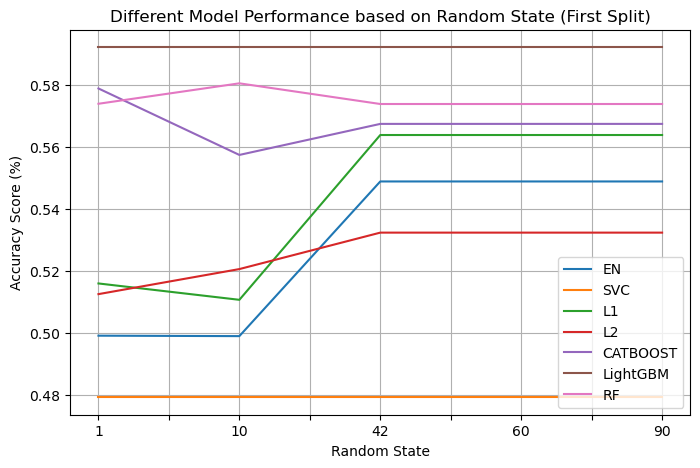

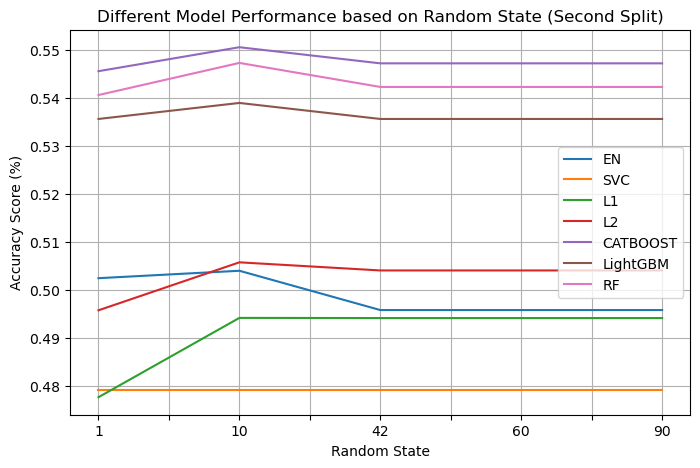

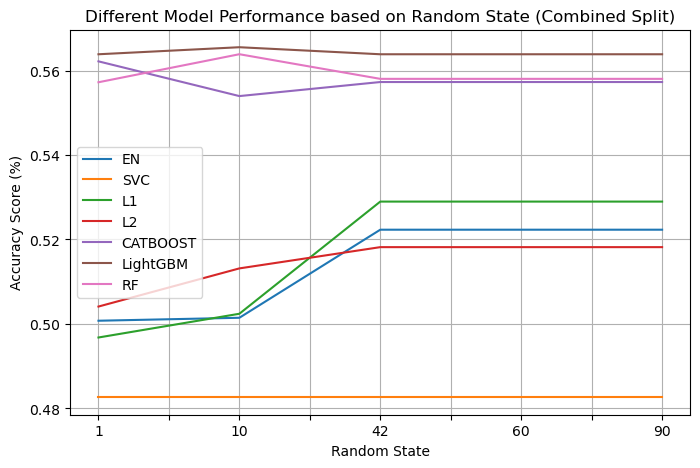

In [132]:
#Plots to show model Performance over all Random States
all_rs1.T.plot(figsize=(8,5), grid=True)
plt.xlabel('Random State')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on Random State (First Split)')
plt.savefig(fname = '../figures/Different Model Performance based on Random State (First Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

all_rs2.T.plot(figsize=(8,5), grid=True)
plt.xlabel('Random State')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on Random State (Second Split)')
plt.savefig(fname = '../figures/Different Model Performance based on Random State (Second Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

all_rsc.T.plot(figsize=(8,5), grid=True)
plt.xlabel('Random State')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on Random State (Combined Split)')
plt.savefig(fname = '../figures/Different Model Performance based on Random State (Combined Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()


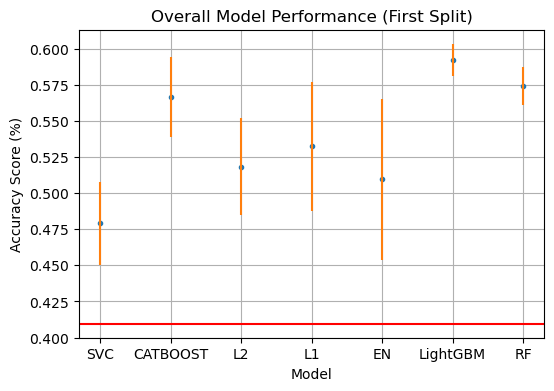

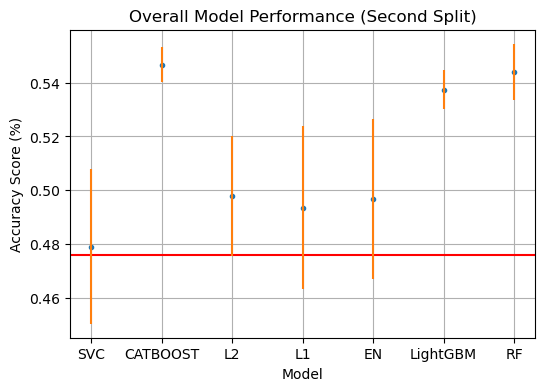

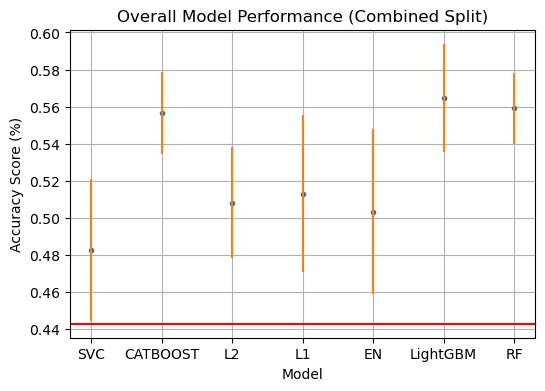

In [133]:
#Plots to show overall model Performance based on Split
model_stat_split1['Mean'].plot(figsize=(6,4), grid=True,ls = 'none', marker = '.')
plt.axhline(y=(stat.mean(baseline_df['Split 1'].to_list())), color='r', linestyle='-')
plt.xlabel('Model')
plt.ylabel('Accuracy Score (%)')
plt.title('Overall Model Performance (First Split)')
plt.errorbar(model_stat_split1.index, model_stat_split1['Mean'], yerr=model_stat_split1['STD'], ls = 'none')
plt.savefig(fname = '../figures/Overall Model Performance - First Split', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

model_stat_split2['Mean'].plot(figsize=(6,4), grid=True,ls = 'none', marker = '.')
plt.xlabel('Model')
plt.axhline(y=(stat.mean(baseline_df['Split 2'].to_list())), color='r', linestyle='-')
plt.ylabel('Accuracy Score (%)')
plt.title('Overall Model Performance (Second Split)')
plt.errorbar(model_stat_split2.index, model_stat_split2['Mean'], yerr=model_stat_split2['STD'], ls = 'none')
plt.savefig(fname = '../figures/Overall Model Performance - Second Split', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

model_stat_splitc['Mean'].plot(figsize=(6,4), grid=True,ls = 'none', marker = '.')
plt.xlabel('Model')
plt.axhline(y=0.4427692575810387, color='r', linestyle='-')
plt.ylabel('Accuracy Score (%)')
plt.title('Overall Model Performance (Combined Split)')
plt.errorbar(model_stat_splitc.index, model_stat_splitc['Mean'], yerr=model_stat_splitc['STD'], ls = 'none')
plt.savefig(fname = '../figures/Overall Model Performance - Combined Split', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()


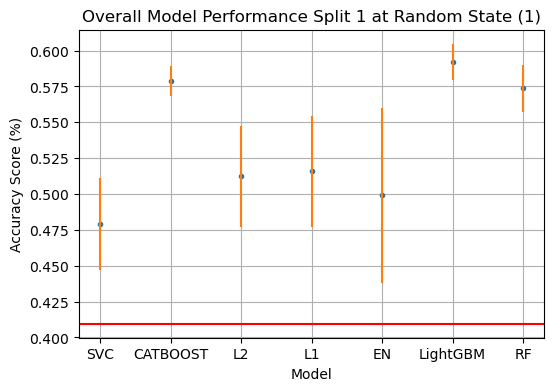

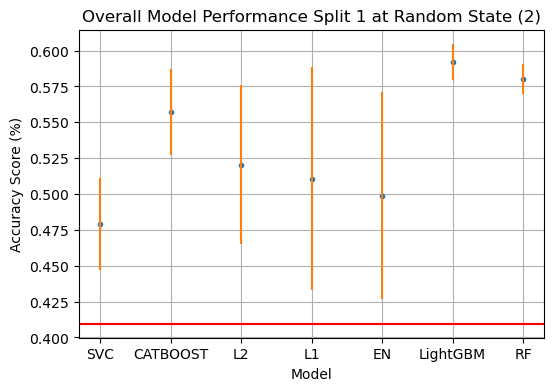

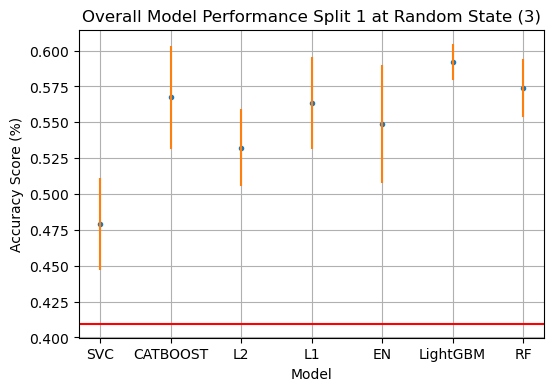

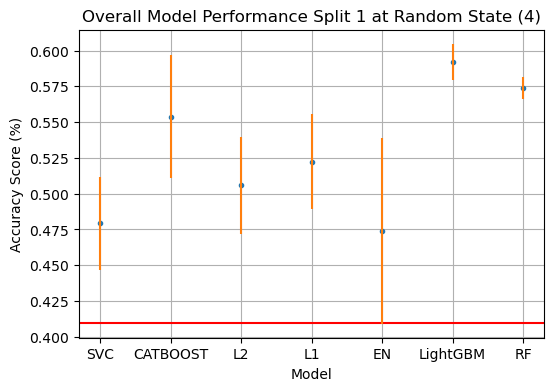

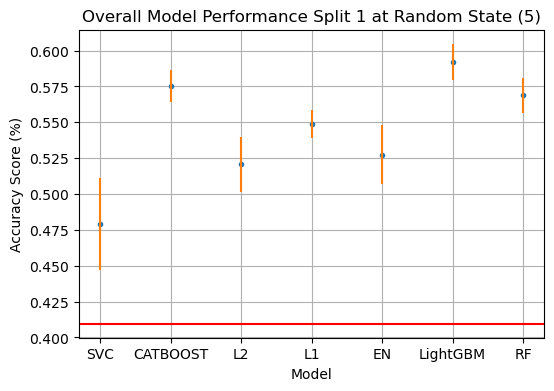

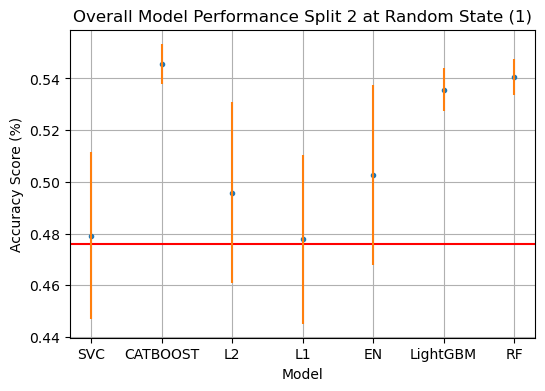

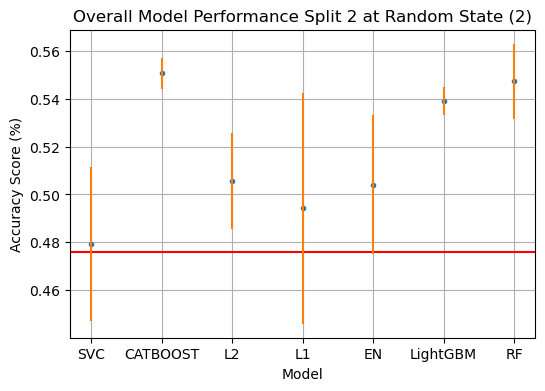

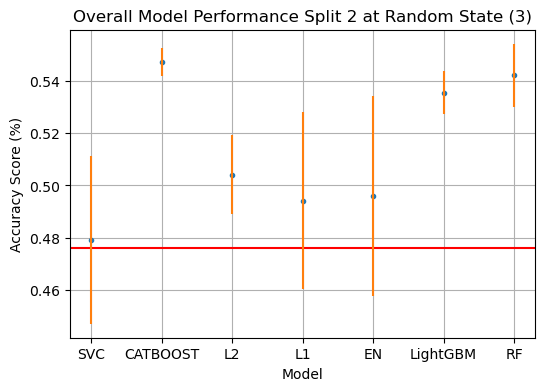

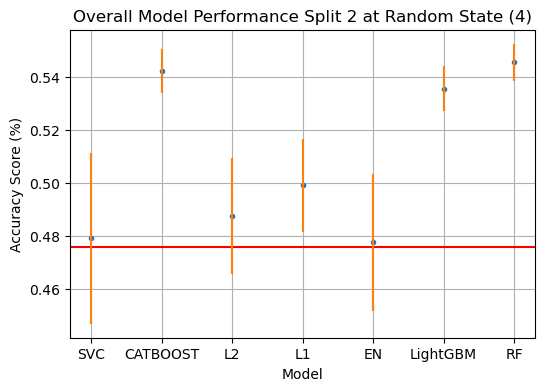

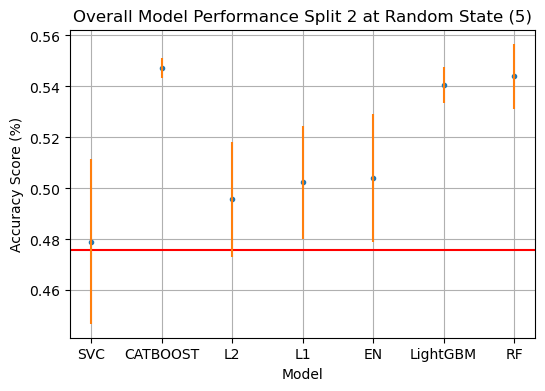

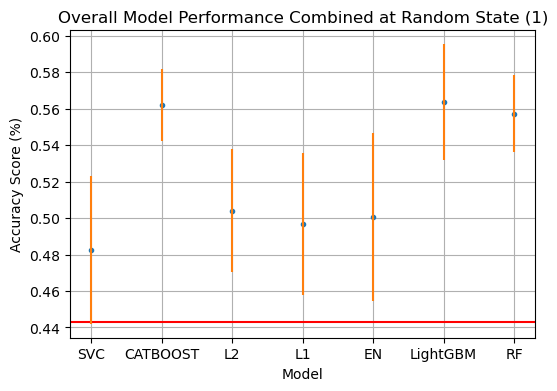

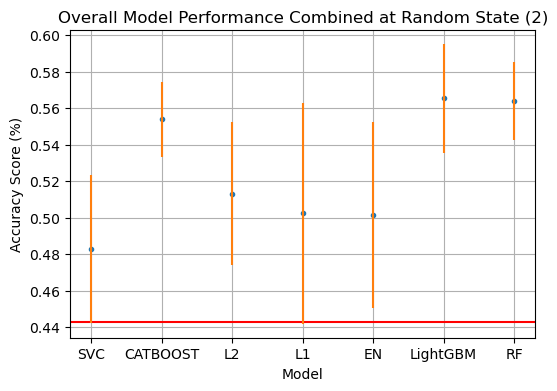

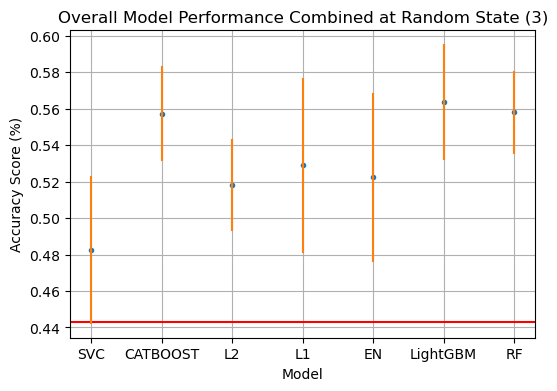

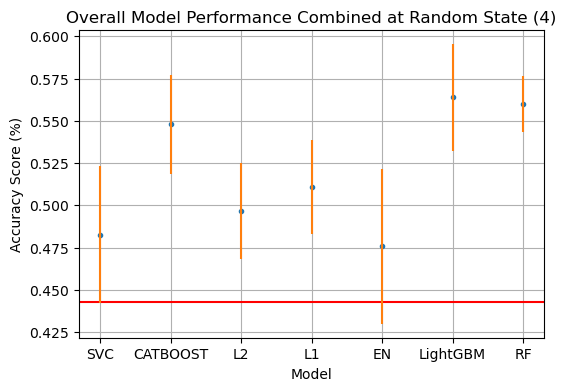

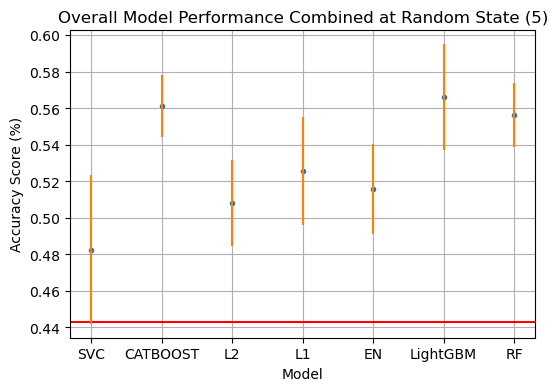

In [134]:
#Plots to show overall model Performance based on Split and RS
def plot_rs(df, rs, baseline, types):
    df['Mean'].plot(figsize=(6,4), grid=True,linestyle='None', marker = ".")
    plt.axhline(y=(stat.mean(baseline)), color='r', linestyle='-')
    plt.xlabel('Model')
    plt.ylabel('Accuracy Score (%)')
    plt.title('Overall Model Performance {} at Random State ({})'.format(types, rs))
    plt.errorbar(df.index, df['Mean'], yerr=df['STD'], ls='none')
    plt.savefig(fname = '../figures/Overall Model Performance - {} Split at Random State ({})'.format(types, rs), format = 'png', dpi = 300, bbox_inches='tight')
    plt.show()
    

plot_rs(model_stat_split1rs1, 1,baseline_df['Split 1'].to_list(),'Split 1')
plot_rs(model_stat_split1rs2, 2,baseline_df['Split 1'].to_list(),'Split 1')
plot_rs(model_stat_split1rs3, 3,baseline_df['Split 1'].to_list(),'Split 1')
plot_rs(model_stat_split1rs4, 4,baseline_df['Split 1'].to_list(),'Split 1')
plot_rs(model_stat_split1rs5, 5,baseline_df['Split 1'].to_list(),'Split 1')
                
plot_rs(model_stat_split2rs1, 1,baseline_df['Split 2'].to_list(),'Split 2')
plot_rs(model_stat_split2rs2, 2,baseline_df['Split 2'].to_list(),'Split 2')
plot_rs(model_stat_split2rs3, 3,baseline_df['Split 2'].to_list(),'Split 2')
plot_rs(model_stat_split2rs4, 4,baseline_df['Split 2'].to_list(),'Split 2')
plot_rs(model_stat_split2rs5, 5,baseline_df['Split 2'].to_list(),'Split 2')

                
plot_rs(model_stat_splitcrs1, 1,baseline_df['Combined'].to_list(),'Combined')
plot_rs(model_stat_splitcrs2, 2,baseline_df['Combined'].to_list(),'Combined')
plot_rs(model_stat_splitcrs3, 3,baseline_df['Combined'].to_list(),'Combined')
plot_rs(model_stat_splitcrs4, 4,baseline_df['Combined'].to_list(),'Combined')
plot_rs(model_stat_splitcrs5, 5,baseline_df['Combined'].to_list(),'Combined')


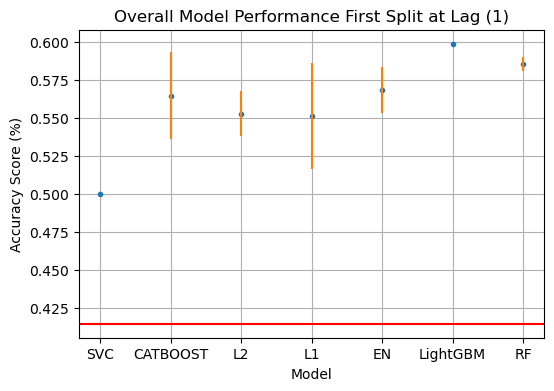

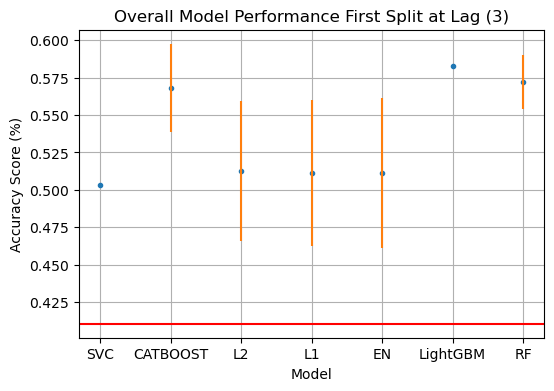

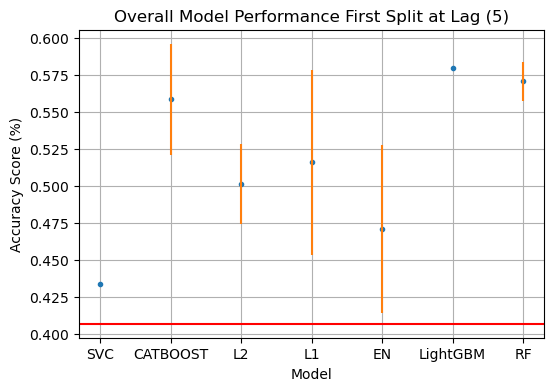

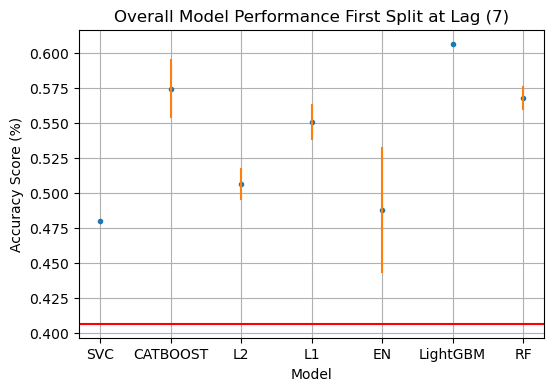

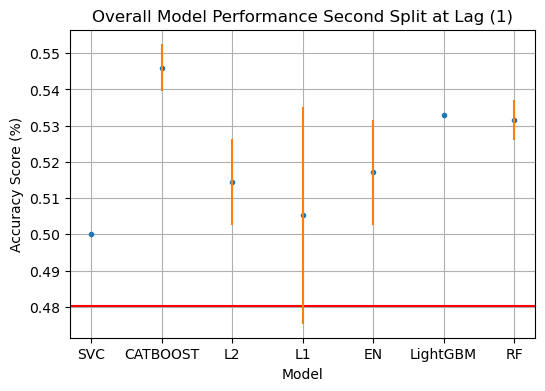

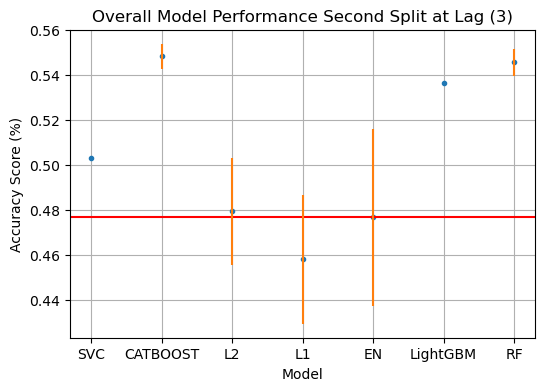

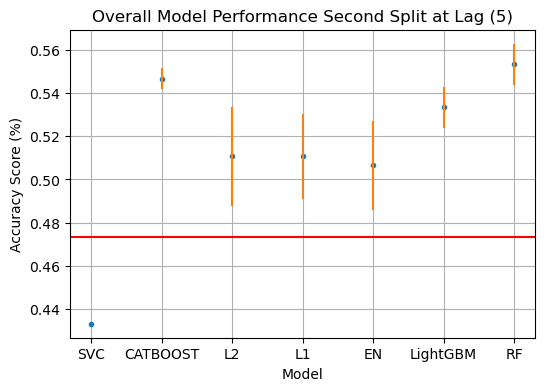

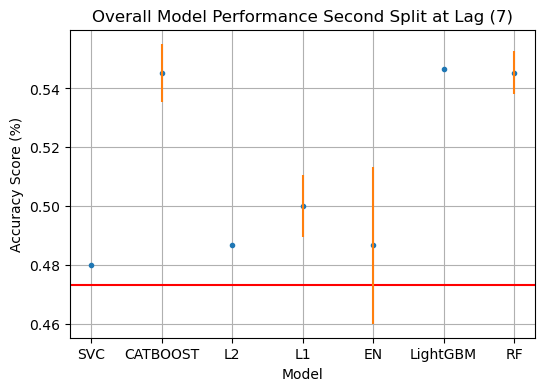

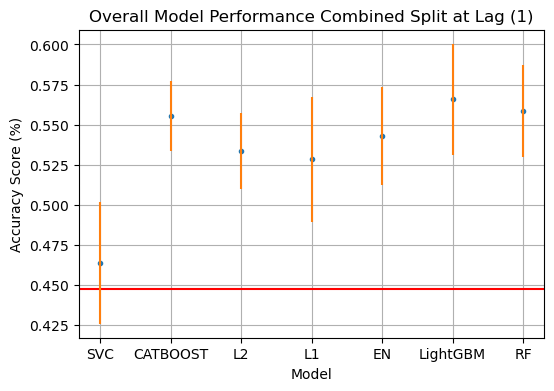

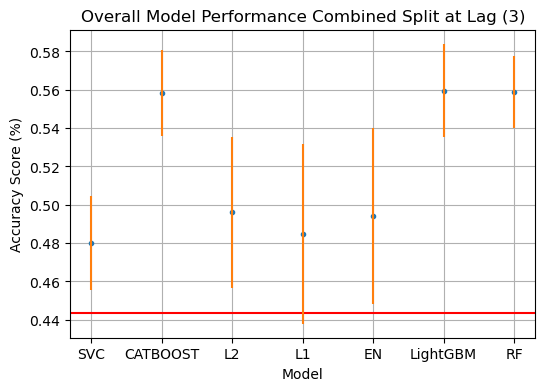

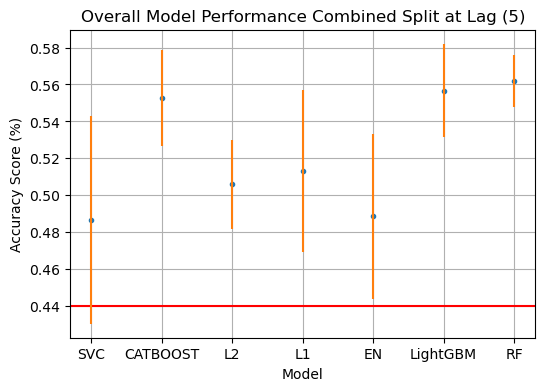

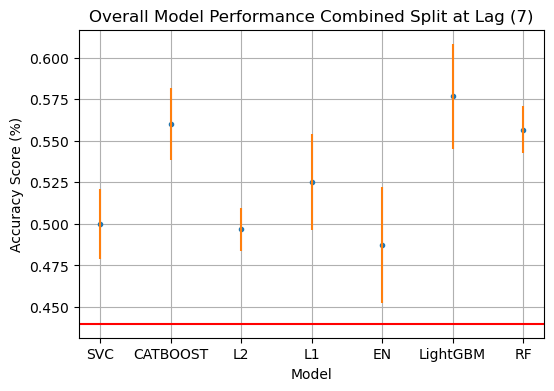

In [135]:
#Plots to show overall model Performance based on Split and lag
def plot_lag(df, split, lag, baseline):
    df['Mean'].plot(figsize=(6,4), grid=True,linestyle='None', marker = ".")
    plt.axhline(y=baseline, color='r', linestyle='-')
    plt.xlabel('Model')
    plt.ylabel('Accuracy Score (%)')
    plt.title('Overall Model Performance {} Split at Lag ({})'.format(split, lag))
    plt.errorbar(df.index, df['Mean'], yerr=df['STD'], ls='none')
    plt.savefig(fname = '../figures/Overall Model Performance - {} Split at Lag ({})'.format(split, lag), format = 'png', dpi = 300, bbox_inches='tight')
    plt.show()
    

plot_lag(model_stat_split1_lag1, 'First', 1, baseline_df['Split 1']['Lag 1'])
plot_lag(model_stat_split1_lag3, 'First', 3, baseline_df['Split 1']['Lag 3'])
plot_lag(model_stat_split1_lag5, 'First',5, baseline_df['Split 1']['Lag 5'])
plot_lag(model_stat_split1_lag7, 'First',7,baseline_df['Split 1']['Lag 7'])

plot_lag(model_stat_split2_lag1, 'Second',1,baseline_df['Split 2']['Lag 1'])
plot_lag(model_stat_split2_lag3, 'Second',3,baseline_df['Split 2']['Lag 3'])
plot_lag(model_stat_split2_lag5, 'Second',5,baseline_df['Split 2']['Lag 5'])
plot_lag(model_stat_split2_lag7, 'Second',7,baseline_df['Split 2']['Lag 7'])

plot_lag(model_stat_splitc_lag1,'Combined', 1,baseline_df['Combined']['Lag 1'])
plot_lag(model_stat_splitc_lag3,'Combined', 3,baseline_df['Combined']['Lag 3'])
plot_lag(model_stat_splitc_lag5,'Combined', 5,baseline_df['Combined']['Lag 5'])
plot_lag(model_stat_splitc_lag7,'Combined', 7,baseline_df['Combined']['Lag 7'])



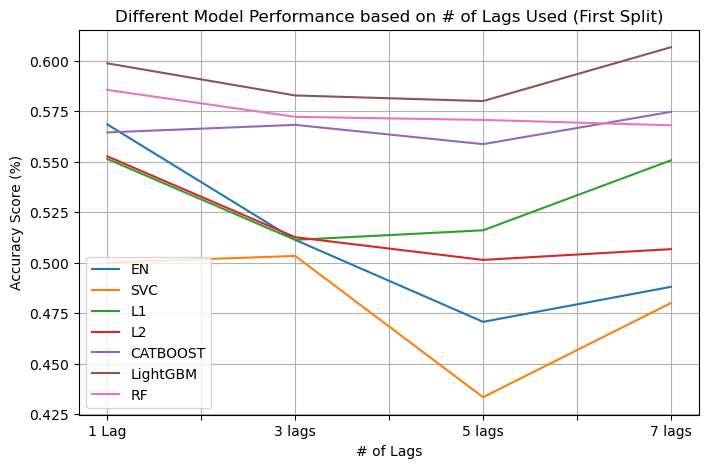

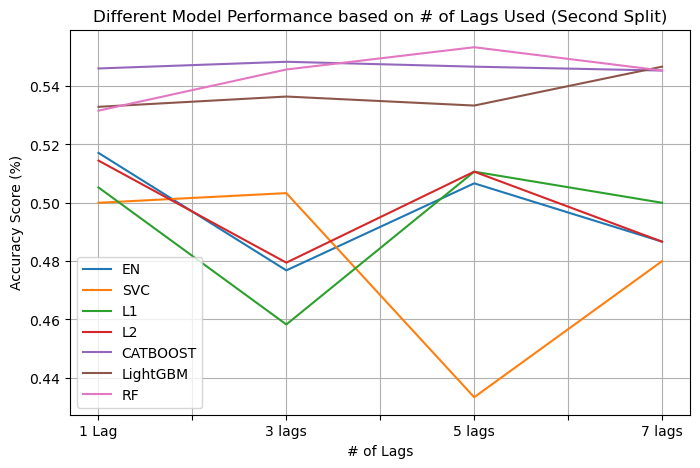

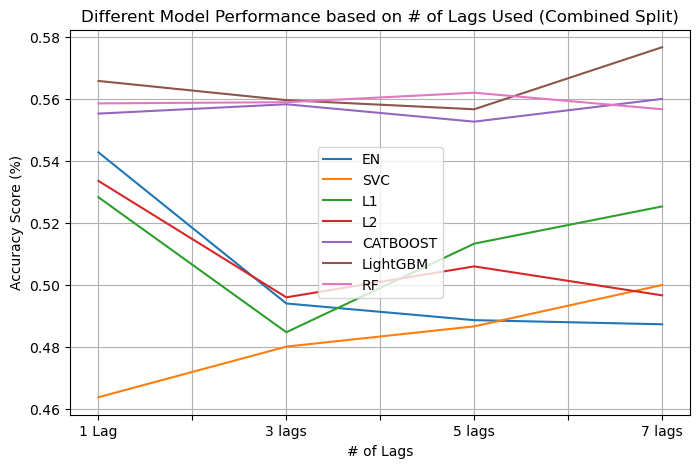

In [136]:
#Plots to show overall model Performance based on Split over all lags
all_lags1.T.plot(figsize=(8,5), grid=True)
plt.xlabel('# of Lags')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on # of Lags Used (First Split)')
plt.savefig(fname = '../figures/Different Model Performance based on # of Lags Used (First Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

all_lags2.T.plot(figsize=(8,5), grid=True)
plt.xlabel('# of Lags')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on # of Lags Used (Second Split)')
plt.savefig(fname = '../figures/Different Model Performance based on # of Lags Used (Second Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

all_lagsc.T.plot(figsize=(8,5), grid=True)
plt.xlabel('# of Lags')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on # of Lags Used (Combined Split)')
plt.savefig(fname = '../figures/Different Model Performance based on # of Lags Used (Combined Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()


## Results - Tables

In [137]:
#Prints top ten models
top_models['RS'] = top_models['RS'].replace(2, 10)
top_models['RS'] = top_models['RS'].replace(3, 42)
top_models['RS'] = top_models['RS'].replace(4, 60)
top_models['RS'] = top_models['RS'].replace(5, 90)

#saves all models to results folder
top_models.to_csv('../results/Tables/all_models.csv')

top_models.iloc[:10]

Model Type    Lag  Score  RS  Split
0   LightGBM  Lag 7  0.607   1      1
1   LightGBM  Lag 7  0.607  10      1
2   LightGBM  Lag 7  0.607  42      1
3   LightGBM  Lag 7  0.607  60      1
4   CATBOOST  Lag 7  0.607  42      1
5   LightGBM  Lag 7  0.607  90      1
6   LightGBM  Lag 1  0.599  42      1
7   LightGBM  Lag 1  0.599  90      1
8   LightGBM  Lag 1  0.599  60      1
9   LightGBM  Lag 1  0.599  10      1

In [138]:
#prints worse ten models
top_models.iloc[-10:]

Model Type    Lag  Score  RS  Split
270        SVC  Lag 5  0.433  42      1
271        SVC  Lag 1  0.428  90      2
272        SVC  Lag 1  0.428  60      2
273        SVC  Lag 1  0.428  42      2
274        SVC  Lag 1  0.428  10      2
275        SVC  Lag 1  0.428   1      2
276         L1  Lag 3  0.424  10      2
277         EN  Lag 7  0.413  60      1
278         EN  Lag 5  0.407  10      1
279         L1  Lag 5  0.407  10      1

In [139]:
#prints baseline scores of splits and std
baseline_df.to_csv('../results/Tables/baselinedf.csv')
baseline_df

Split 1  Split 2  Combined   STD
Lag 1    0.414    0.480     0.447 0.047
Lag 3    0.411    0.477     0.444 0.047
Lag 5    0.407    0.473     0.440 0.047
Lag 7    0.407    0.473     0.440 0.047

In [140]:
#shows lag mean and std for split 1
updatedpdlag11.to_csv('../results/Tables/lag_std_mean_split1.csv')
updatedpdlag11

1 Lag Mean  1 Lag STD  3 Lag Mean  3 Lag STD  5 Lag Mean  5 Lag STD  \
EN             0.568      0.015       0.511      0.050       0.471      0.057   
SVC            0.500      0.000       0.503      0.000       0.433      0.000   
L1             0.551      0.035       0.511      0.049       0.516      0.063   
L2             0.553      0.015       0.513      0.047       0.501      0.027   
CATBOOST       0.564      0.028       0.568      0.029       0.559      0.038   
LightGBM       0.599      0.000       0.583      0.000       0.580      0.000   
RF             0.586      0.005       0.572      0.018       0.571      0.013   

          7 Lag Mean  7 Lag STD  
EN             0.488      0.045  
SVC            0.480      0.000  
L1             0.551      0.013  
L2             0.507      0.012  
CATBOOST       0.575      0.021  
LightGBM       0.607      0.000  
RF             0.568      0.009

In [141]:
#shows lag mean and std for split 2
updatedpdlag11.to_csv('../results/Tables/lag_std_mean_split2.csv')
updatedpdlag12

1 Lag Mean  1 Lag STD  3 Lag Mean  3 Lag STD  5 Lag Mean  5 Lag STD  \
EN             0.517      0.014       0.477      0.039       0.507      0.021   
SVC            0.500      0.000       0.503      0.000       0.433      0.000   
L1             0.505      0.030       0.458      0.029       0.511      0.020   
L2             0.514      0.012       0.479      0.024       0.511      0.023   
CATBOOST       0.546      0.007       0.548      0.006       0.547      0.005   
LightGBM       0.533      0.000       0.536      0.000       0.533      0.009   
RF             0.532      0.006       0.546      0.006       0.553      0.009   

          7 Lag Mean  7 Lag STD  
EN             0.487      0.027  
SVC            0.480      0.000  
L1             0.500      0.011  
L2             0.487      0.000  
CATBOOST       0.545      0.010  
LightGBM       0.547      0.000  
RF             0.545      0.007

In [142]:
#shows lag mean and std for combined split
updatedpdlag1.to_csv('../results/Tables/lag_std_mean_splitc.csv')
updatedpdlag1

1 Lag Mean  1 Lag STD  3 Lag Mean  3 Lag STD  5 Lag Mean  5 Lag STD  \
EN             0.543      0.030       0.494      0.046       0.489      0.045   
SVC            0.464      0.038       0.480      0.024       0.487      0.056   
L1             0.528      0.039       0.485      0.047       0.513      0.044   
L2             0.534      0.024       0.496      0.039       0.506      0.024   
CATBOOST       0.555      0.022       0.558      0.023       0.553      0.026   
LightGBM       0.566      0.035       0.560      0.024       0.557      0.025   
RF             0.559      0.029       0.559      0.019       0.562      0.014   

          7 Lag Mean  7 Lag STD  
EN             0.487      0.035  
SVC            0.500      0.021  
L1             0.525      0.029  
L2             0.497      0.013  
CATBOOST       0.560      0.022  
LightGBM       0.577      0.032  
RF             0.557      0.014

In [143]:
#shows zscores for all models on different lags
zscores_by_lags.to_csv('../results/Tables/zscore_lag.csv')
zscores_by_lags[['1 Lag zscore','3 Lag zscore','5 Lag zscore','7 Lag zscore']]

1 Lag zscore  3 Lag zscore  5 Lag zscore  7 Lag zscore
EN               3.135         1.094         1.089         1.356
SVC              0.431         1.491         0.830         2.846
L1               2.069         0.877         1.671         2.949
L2               3.635         1.336         2.747         4.341
CATBOOST         4.960         5.087         4.333         5.511
LightGBM         3.415         4.743         4.596         4.322
RF               3.856         6.135         8.670         8.250

In [144]:
#shows all models stats on split 1
model_stat_split1.to_csv('../results/Tables/model_stats_split1.csv')
model_stat_split1.sort_values('zscore', ascending = False)

Mean   STD   SEM  zscore
LightGBM 0.592 0.011 0.003  16.086
RF       0.574 0.013 0.003  12.556
CATBOOST 0.567 0.028 0.006   5.635
L2       0.518 0.033 0.007   3.248
L1       0.532 0.045 0.010   2.754
SVC      0.479 0.029 0.006   2.428
EN       0.510 0.056 0.012   1.791

In [145]:
#shows all models stats on split 2
model_stat_split2.to_csv('../results/Tables/model_stats_split2.csv')
model_stat_split2.sort_values('zscore', ascending = False)

Mean   STD   SEM  zscore
CATBOOST 0.547 0.006 0.001  10.885
LightGBM 0.537 0.007 0.002   8.576
RF       0.544 0.010 0.002   6.534
L2       0.498 0.022 0.005   0.983
EN       0.497 0.030 0.007   0.707
L1       0.494 0.030 0.007   0.581
SVC      0.479 0.029 0.006   0.113

In [146]:
#shows all models stats, with zscore, on combined split
model_stat_splitc.to_csv('../results/Tables/model_stats_splitc.csv')
model_stat_splitc.sort_values('Mean', ascending = False)

Mean   STD   SEM  zscore
LightGBM 0.565 0.029 0.005   4.169
RF       0.559 0.019 0.003   6.054
CATBOOST 0.557 0.022 0.004   5.090
L1       0.513 0.042 0.007   1.654
L2       0.508 0.030 0.005   2.183
EN       0.503 0.045 0.007   1.356
SVC      0.483 0.038 0.006   1.037

## Best Model

In [193]:
best_model = pickle.load(open('../results/LightGBM/lgb77.pkl', 'rb'))
best_model_pipeline = pickle.load(open('../results/LightGBM/lgb77_pipeline.pkl', 'rb'))

In [160]:
#recreates best model prediciton using best parameters 
tscv = TimeSeriesSplit(2)
best_modellgb7 = []
best_scorelgb7 = []
cmlgb7 = []
feature_nameslgb7 = []

param_grid = {'ml__colsample_bytree': [0.99], 
 'ml__max_depth': [40], 
 'ml__min_child_samples':[20],
 'ml__min_child_weight': [1e-05], 
 'ml__n_estimators': [5],
 'ml__num_leaves': [3],
 'ml__random_state': [60]}

X =X7_lagged
y = y7_lagged

#stops model from computing second split
counter = 0

for train_index, test_index in tscv.split(X):
    if counter == 1:
        break
        
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipe = Pipeline(steps=[('preprocessor', preprocessor_7), ('ml', LGGclass)])
    gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = 'f1_micro', refit = 'f1_micro')
    gsearch.fit(X_train, y_train) 

    best_model = gsearch.best_estimator_
    best_score = gsearch.best_score_
    best_param = gsearch.best_params_
    feature_nameslgb7 = best_model[:-1].get_feature_names_out()

    y_pred = best_model.predict(X_test)
    test_score = accuracy_score(y_test,y_pred)
    best_scorelgb7.append(test_score)
    cmlgb7.append(confusion_matrix(y_test,y_pred))
    best_modellgb7.append(best_model)
    
    print('\nConfusion Matrix\n')
    print(confusion_matrix(y_test,y_pred))

    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
    counter += 1


Confusion Matrix

[[34  0 25]
 [10  2 18]
 [ 6  0 55]]

Accuracy: 0.61

Micro Precision: 0.61
Micro Recall: 0.61
Micro F1-score: 0.61

Macro Precision: 0.75
Macro Recall: 0.51
Macro F1-score: 0.48

Weighted Precision: 0.70
Weighted Recall: 0.61
Weighted F1-score: 0.55

Classification Report

              precision    recall  f1-score   support

     Class 1       0.68      0.58      0.62        59
     Class 2       1.00      0.07      0.12        30
     Class 3       0.56      0.90      0.69        61

    accuracy                           0.61       150
   macro avg       0.75      0.51      0.48       150
weighted avg       0.70      0.61      0.55       150



In [166]:
#prints important stats on best model
print(f'Baseline Score at 7 Lags: {0.406667:.3f}')
print(f'LightGBM Score (7 Lags - First Split - 60 RS): {best_scorelgb7[0]:.3f}')

print('Overall LightGBM Mean:', 0.564681)
print('Overall LightGBM STD:', round(stat.stdev(top_models.loc[top_models['Model Type'] == 'LightGBM']['Score'].to_list()),4))

print('Overall Baseline Mean:', round(mean_all_baselines,4))
print('Overall Baseline STD:', round(std_all_baselines,4))

print('LightGBM zscore (overall):' ,3.613937)
print('LightGBM zscore (at Lag 7):' ,2.899166)


Baseline Score at 7 Lags: 0.407
LightGBM Score (7 Lags - First Split - 60 RS): 0.607
Overall LightGBM Mean: 0.564681
Overall LightGBM STD: 0.0292
Overall Baseline Mean: 0.4428
Overall Baseline STD: 0.0337
LightGBM zscore (overall): 3.613937
LightGBM zscore (at Lag 7): 2.899166


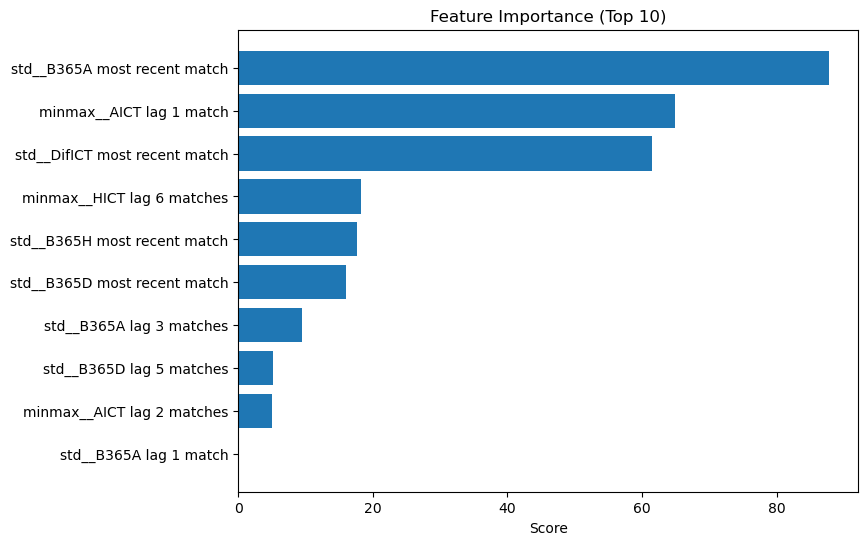

In [167]:
#creates different feature importance variables to use with shap and other feature importance plots
overall_best_model = best_modellgb7[0][1]
feature_values = best_modellgb7[0][0].transform(X7_lagged)
lgb7_matrix = pd.DataFrame(data=feature_values,columns=feature_nameslgb7)
feature_importance = overall_best_model.booster_.feature_importance(importance_type = 'gain')

#creates MDI feature importance plot
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx[-10:])), feature_importance[sorted_idx][-10:], align='center')
plt.yticks(range(len(sorted_idx[-10:])), np.array(feature_nameslgb7)[sorted_idx][-10:])
plt.title('Feature Importance (Top 10)')
plt.savefig(fname = '../figures/Feature Importance (MDI)', format = 'png', dpi = 300, bbox_inches='tight')
plt.xlabel("Score")
plt.show()

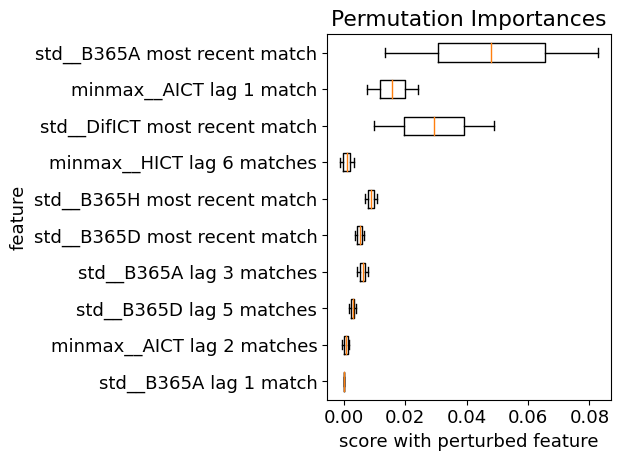

In [168]:
from sklearn.inspection import permutation_importance

#uses sklearn permuation importance to calculate and plot feature importance
perm_importance = permutation_importance(overall_best_model, feature_values, y7_lagged, n_repeats=30, random_state=0)
features_mean =perm_importance.importances_mean[sorted_idx][-10:]
features_std = perm_importance.importances_std[sorted_idx][-10:]
feature_names_perb =np.array(feature_nameslgb7)[sorted_idx][-10:]
df_perb = pd.DataFrame(features_mean.T,feature_names_perb)
df_perb['STD'] = features_std


plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6.4,4.8))
plt.boxplot(df_perb.T, labels=df_perb.T.columns,vert=False)
plt.title("Permutation Importances")
plt.savefig(fname = '../figures/Permutation Importances', format = 'png', dpi = 300, bbox_inches='tight')
plt.xlabel('score with perturbed feature')
plt.ylabel('feature')

plt.tight_layout()
plt.show()


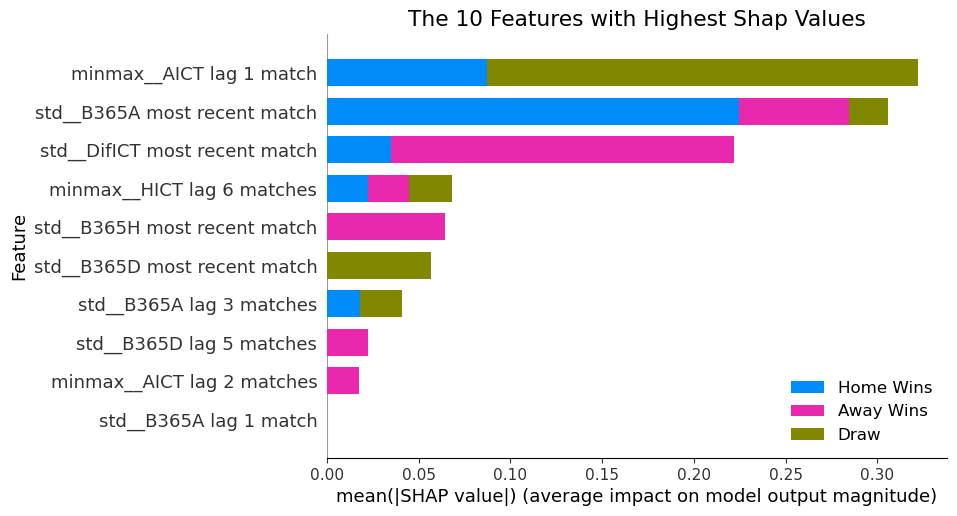

In [169]:
#uses shap to create summary plot of feature importance
import shap
shap.initjs()

explainer = shap.TreeExplainer(overall_best_model)
shap_values = explainer.shap_values(feature_values)
plt.title("The 10 Features with Highest Shap Values")
plt.ylabel("Feature")

shap.summary_plot(shap_values, lgb7_matrix, max_display = 10, class_names= ['Away Wins', 'Draw', 'Home Wins'])


In [170]:
#creates a forceplot showing a win
index = 30 # the index of the point to explain
print(explainer.expected_value[2]) # we explain class 2 predictions
shap.force_plot(explainer.expected_value[2], shap_values[2][index,:], features = feature_values[index,:],feature_names = lgb7_matrix.columns)


-0.8895917009287115


In [171]:
#creates a forceplot showing a draw
index = 40 # the index of the point to explain
print(explainer.expected_value[1]) # we explain class 1 predictions
shap.force_plot(explainer.expected_value[1], shap_values[1][index,:], features = feature_values[index,:],feature_names = lgb7_matrix.columns)


-1.3109534678062458


In [172]:
#creates a forceplot showing a loss
index = 4 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = feature_values[index,:],feature_names = lgb7_matrix.columns)



-1.1769460650713428


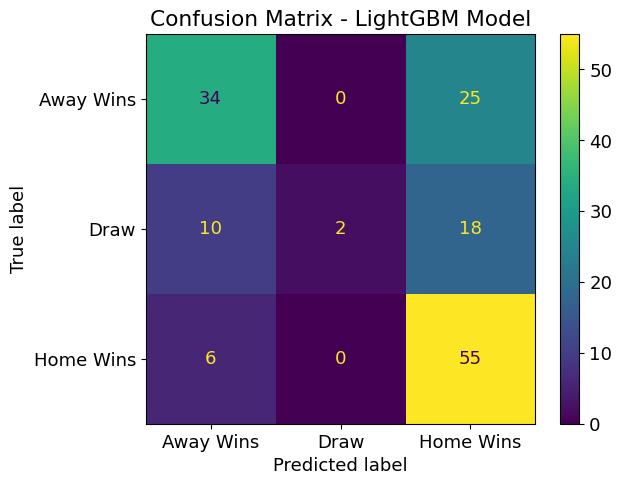

In [173]:
#creates a confusion matrix of best model (lightGBM)
disp = ConfusionMatrixDisplay(cmlgb7[0],display_labels=['Away Wins', 'Draw', 'Home Wins'])
disp.plot()
plt.tight_layout()
plt.title('Confusion Matrix - LightGBM Model')
plt.savefig(fname = '../figures/Confusion Matrix_LightGBM', format = 'png', dpi = 300, bbox_inches='tight')
plt.show() 